## Introduction
In this file, I have used the optuna library to optimize the hyperparameters for a feed forward neural network. The initial code is the same as the other file in which I preprocess the strain and stress data in a tensor form. I write several functions for different mathematical operations. I have also written the mathematical relationships between principal invariants and free energy etc that have been employed.

In [1]:
# Load data
import pandas as pd
import numpy as np

#### This function "deviatoric" calculates the deviatoric stress from a 3 by 3 list of stress. 

In [2]:
def deviatoric(sig):
    sig11 = sig[0,0]; sig12 = sig[0,1]; sig13 = sig[0,2]
    sig21 = sig[1,0]; sig22 = sig[1,1]; sig23 = sig[1,2]
    sig31 = sig[2,0]; sig32 = sig[2,1]; sig33 = sig[2,2]
    sigDev = np.array([[sig11,sig12,sig13],[sig21,sig22,sig23],[sig31,sig32,sig33]]) \
        - 1/3*(sig11+sig22+sig33)*np.eye(3)
    return sigDev

In [3]:
def readData(filepath=r'avgStrainStressInfoNEPureShearLoading.csv'):
    T = pd.read_csv(filepath)
    eps_nominal=T.iloc[:,0:6].values
    sigMatrix = T.iloc[:,6:12].values
    
    
    sigMatrixList = []
    for k in range(len(T.sig11)):
        sig = np.asarray([[T.sig11[k], T.sig12[k], T.sig13[k]],[T.sig12[k], T.sig22[k], T.sig23[k]],[T.sig13[k], T.sig23[k], T.sig33[k]]])
        sigMatrixList.append(sig)
    return eps_nominal, sigMatrix, sigMatrixList
        
eps_nominal, sigMatrix, sigMatrixList = readData()

In [4]:
sigMatrixList[0]

array([[ 5.881015e-02,  3.930000e-12, -1.410000e-12],
       [ 3.930000e-12,  5.032935e-03,  6.440000e-12],
       [-1.410000e-12,  6.440000e-12,  5.050588e-03]])

In [5]:
sigMatrix.shape

(918, 6)

In [6]:
eps_nominal[5,:]

array([ 1.076606e-03, -4.838850e-04, -4.838830e-04,  3.490000e-19,
       -6.240000e-19, -2.730000e-12])

In [7]:
fiber_direction = np.array([[1],[0],[0]])
fiber_direction.shape

(3, 1)

In [10]:
np.cbrt(8)
print(np.prod([1, 2, 3, 4]))

24


### F: Deformation gradient 
### C: Right Cauchy Tensor 
### b: Left Cauchy Tensor
$$ \bar{\mathbf{F}} = J^{-\frac{1}{3}} \mathbf{F}$$
$$ \bar{\mathbf{b}} = J^{-\frac{2}{3}} \mathbf{b} $$
$$ \bar{\mathbf{C}} = J^{-\frac{2}{3}} \mathbf{C} $$
$$ \mathbf{F} = \mathbf{R} \cdot \mathbf{U} = \mathbf{v} \cdot \mathbf{R}$$

$$ \mathbf{b} = \sum_{i=1}^{i=n}\lambda_i^2 n_i \otimes n_i$$
$$ \mathbf{U} = diag(\lambda_i)$$

In [6]:
def estimate_F_C(b,J):
    # Perform spectral decomposition of b
    eigenvalues, eigenvectors = np.linalg.eigh(b)
    
    # Since J = det(F), and for isotropic materials det(F) = det(v),
    # adjust the principal stretches to reflect volume change
    principal_stretches = np.sqrt(eigenvalues) * np.cbrt(J / np.prod(np.sqrt(eigenvalues)))

    # Reconstruct F using the principal stretches and the eigenvectors of b
    # Note: This reconstruction assumes F can be directly derived from b's eigendecomposition, 
    # which may not capture the full rotation effects in v. This is a simplification.
    U = np.diag(principal_stretches)
    F = eigenvectors @ U @ np.linalg.inv(eigenvectors)

    # Calculate C = F.T * F
    C = np.matmul(F.T, F)
    b_estimate = np.matmul(F, F.T)
    error = np.linalg.norm(b - b_estimate)

    return F, C,error

In [7]:
import torch

In [8]:
def doubleDotProduct(A,B):
    return np.trace(np.matmul(A.T,B))
    
def deviatoric(sig):
    return sig - 1/3*np.trace(sig)*np.eye(3)
class bases:
    def __init__(self,base1,base2,base3,base4,base5):
        self.base1 = torch.tensor(base1,dtype=torch.float32)
        self.base2 = torch.tensor(base2,dtype=torch.float32)
        self.base3 = torch.tensor(base3,dtype=torch.float32)
        self.base4 = torch.tensor(base4,dtype=torch.float32)
        self.base5 = torch.tensor(base5,dtype=torch.float32)
    def to_dict(self):
        return {
            'base1': self.base1,
            'base2': self.base2,
            'base3': self.base3,
            'base4': self.base4,
            'base5': self.base5,
        }
    def __repr__(self) -> str:
        return f'base1: {self.base1},\n base2: {self.base2},\n base3: {self.base3},\n base4: {self.base4},\n base5: {self.base5}\n'
def calc_bases(bbar,F,J,direction):
    dev_bbar = deviatoric(bbar)
    base1 = 2.0/J * dev_bbar
    base2 = -2.0/J * deviatoric(bbar @ bbar)
    Fbar = J**(-1/3)*F
    a_bar = Fbar @ direction
    a_bar_dash = bbar @ a_bar
    base3 = np.eye(3) 
    base4 = 2.0 * a_bar @ a_bar.T
    base5 = 2.0 * a_bar @ a_bar_dash.T + 2.0 * a_bar_dash @ a_bar.T
    return bases(base1,base2,base3,base4,base5)





def transforming_nominal_strain(eps_nominal):
    v_mat_lin = np.zeros((len(eps_nominal),6))
    b_mat_lin = np.zeros((len(eps_nominal),6))
    I1 = np.zeros((len(eps_nominal),1))
    I2 = np.zeros((len(eps_nominal),1))
    I3 = np.zeros((len(eps_nominal),1))
    I4 = np.zeros((len(eps_nominal),1))
    I5 = np.zeros((len(eps_nominal),1))
    I1_bar = np.zeros((len(eps_nominal),1))
    I2_bar = np.zeros((len(eps_nominal),1))
    I4_bar = np.zeros((len(eps_nominal),1))
    I5_bar = np.zeros((len(eps_nominal),1))
    fiber_direction = np.array([[1],[0],[0]])
    fiber_dyad = np.matmul(fiber_direction,fiber_direction.T)
    bases_data = []
    # eps_nominal = numpy array with 918 x 6
    for k in range(len(eps_nominal)):
        # eps11,eps22,eps33,eps12,eps13,eps23
        eps_nom = np.array([ [eps_nominal[k,0]  , eps_nominal[k,3], eps_nominal[k,4]], 
                    [eps_nominal[k,3], eps_nominal[k,1]  , eps_nominal[k,5]], 
                    [eps_nominal[k,4], eps_nominal[k,5], eps_nominal[k,2]  ] ])
        v_mat = eps_nom + np.eye(3)
        b_mat = np.matmul(v_mat,v_mat)
        J = np.linalg.det(v_mat)
        F, C,error = estimate_F_C(b_mat,J)
        bbar = (J)**(-2/3)*b_mat
        base_obj = calc_bases(bbar,F,J,fiber_direction)
        Cbar = (J)**(-2/3)*C
        # Calculate invariants
        I1[k] = np.trace(b_mat)
        I2[k] = 0.5*(I1[k]**2 - np.trace(np.matmul(b_mat,b_mat)))
        I3[k] = J
        I4[k] = doubleDotProduct(C,fiber_dyad)
        I5[k] = doubleDotProduct(C @ C,fiber_dyad)
        
        
        I1_bar[k] = np.trace(bbar)
        I2_bar[k] = 0.5*(I1_bar[k]**2 - np.trace(np.matmul(bbar,bbar)))
        I4_bar[k] = doubleDotProduct(Cbar,fiber_dyad)
        I5_bar[k] = doubleDotProduct(Cbar @ Cbar,fiber_dyad)
        
        bases_data.append(base_obj) 
        v_mat_lin[k,:] = [v_mat[0,0],v_mat[1,1],v_mat[2,2], \
                            v_mat[0,1],v_mat[0,2],v_mat[1,2]]
        b_mat_lin[k,:] = [b_mat[0,0],b_mat[1,1],b_mat[2,2], \
                            b_mat[0,1],b_mat[0,2],b_mat[1,2]]
    invarices = np.concatenate((I1,I2,I3,I4,I5),axis=1)
    invarices_bar = np.concatenate((I1_bar,I2_bar,I3,I4_bar,I5_bar),axis=1)
    return v_mat_lin,b_mat_lin,invarices,invarices_bar,bases_data
v_matrix,b_mat_lin,invarices,invarices_bar,bases_data_list = transforming_nominal_strain(eps_nominal)

In [9]:
len(bases_data_list)

918

In [10]:
b_mat_lin.shape

(918, 6)

In [11]:
invarices_bar.shape

(918, 5)

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Subset

In [13]:
sigMatrixList = [torch.tensor(sigMatrixList[i],dtype=torch.float32) for i in range(len(sigMatrixList))]

In [14]:
data_dict = {'invriants': invarices_bar, 'bases': bases_data_list, 'target_stress': sigMatrixList}
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        # convert invariants to tensor
        invariants = torch.tensor(data['invriants'], dtype=torch.float32)
        invariants.requires_grad = True
        self.invariants = invariants
        self.bases = data['bases']
        self.base1_list = [b.base1 for b in self.bases]
        self.base2_list = [b.base2 for b in self.bases]
        self.base3_list = [b.base3 for b in self.bases]
        self.base4_list = [b.base4 for b in self.bases]
        self.base5_list = [b.base5 for b in self.bases]
        self.base1_list = torch.stack(self.base1_list)
        self.base2_list = torch.stack(self.base2_list)
        self.base3_list = torch.stack(self.base3_list)
        self.base4_list = torch.stack(self.base4_list)
        self.base5_list = torch.stack(self.base5_list)
        # target_stress = torch.tensor(data['target_stress'], dtype=torch.float32)
        # target_stress.requires_grad = True
        target_stress = torch.stack(data['target_stress'])
        self.target_stress = target_stress
    
    def __getitem__(self, index):
        # Extract data for a single sample
        invariants = self.invariants[index]
        base1 = self.base1_list[index,:,:]
        base2 = self.base2_list[index,:,:]
        base3 = self.base3_list[index,:,:]
        base4 = self.base4_list[index,:,:]
        base5 = self.base5_list[index,:,:]
        bases = (base1, base2, base3, base4, base5)
        # target_stress = self.target_stress[index]
        target_stress = self.target_stress[index,:,:]
        return invariants, bases, target_stress

    def __len__(self):
        return len(self.invariants)

dataset = MyDataset(data_dict)


In [16]:
# Split the dataset into training and validation sets
dataset_size = len(dataset)
indices = torch.randperm(dataset_size).tolist()
# Calculate split sizes
train_split = int(0.88 * dataset_size)
val_split = int(0.91 * dataset_size)  # This accounts for the next 15%

# Split indices
train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

# Create Subset instances for train, validation, and test sets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)



In [17]:
# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [18]:
class ICNN(nn.Module):
    def __init__(self, num_layers, size_hidden,input_dim=1,output_dim=1):
        super(ICNN, self).__init__()
        self.num_layers = num_layers
        self.size_hidden = size_hidden

        # Initialize the weights for the input layer to zero
        self.w0 = nn.Parameter(torch.abs(torch.randn(input_dim, size_hidden)))
        self.b0 = nn.Parameter(torch.randn(size_hidden))
        # Weights associated with the input y should be unconstrained
        self.w_y = nn.ParameterList([
            nn.Parameter(torch.randn(input_dim, size_hidden)) 
            for _ in range(num_layers-1)
        ])
        
        # Weights associated with the previous layer's activation should be non-negative
        self.w_z = nn.ParameterList([
            nn.Parameter(torch.abs(torch.randn(size_hidden, size_hidden))) 
            for _ in range(num_layers - 1)
        ])
        
        # Biases for each layer can be any real number
        self.biases = nn.ParameterList([
            nn.Parameter(torch.randn(size_hidden)) 
            for _ in range(num_layers - 1)
        ])
        
        # Output layer weight (unconstrained)
        self.wz_out = nn.Parameter(torch.abs(torch.randn(size_hidden, output_dim)))
        self.wy_out = nn.Parameter(torch.abs(torch.randn(input_dim, output_dim)))
        self.b_out = nn.Parameter(torch.randn(output_dim))


        # Softplus activation function
        self.activation = torch.nn.functional.softplus

    def forward(self, y):
        z = self.activation(torch.matmul(y, self.w0) + self.b0)
        # Apply transformations for each layer
        for i in range(self.num_layers - 1):
            z = self.activation(torch.matmul(z, self.w_z[i]) + torch.matmul(y, self.w_y[i]) + self.biases[i])

        # Output layer
        output = self.activation(torch.matmul(z, self.wz_out) + torch.matmul(y, self.wy_out) + self.b_out)
        return output


Epoch 1: loss: 11682.60546875
Epoch 101: loss: 159.2806396484375
Epoch 201: loss: 43.815433502197266
Epoch 301: loss: 18.501544952392578
Epoch 401: loss: 8.91199779510498
Epoch 501: loss: 4.800579071044922
Epoch 601: loss: 2.878443717956543
Epoch 701: loss: 1.8931812047958374
Epoch 801: loss: 1.3407315015792847
Epoch 901: loss: 1.0058950185775757
Epoch 1001: loss: 0.7896069884300232
Epoch 1101: loss: 0.6425653100013733
Epoch 1201: loss: 0.5383995175361633
Epoch 1301: loss: 0.46209457516670227
Epoch 1401: loss: 0.40463516116142273
Epoch 1501: loss: 0.3603552579879761
Epoch 1601: loss: 0.3255591094493866
Epoch 1701: loss: 0.29774922132492065
Epoch 1801: loss: 0.27519333362579346
Epoch 1901: loss: 0.2566586136817932
Epoch 2001: loss: 0.24124881625175476
Epoch 2101: loss: 0.22829891741275787
Epoch 2201: loss: 0.21730823814868927
Epoch 2301: loss: 0.2078929841518402
Epoch 2401: loss: 0.19975490868091583
Epoch 2501: loss: 0.19265972077846527
Epoch 2601: loss: 0.18641996383666992
Epoch 2701: 

In [19]:
import torch
import torch.nn as nn

class FeedforwardNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_hidden_layers):
        super(FeedforwardNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        
        # Define the input layer
        self.input_layer = nn.Linear(self.input_size, self.hidden_size)
        
        # Define the hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(self.num_hidden_layers):
            self.hidden_layers.append(nn.Linear(self.hidden_size, self.hidden_size))
        
        # Define the output layer
        self.output_layer = nn.Linear(self.hidden_size, self.output_size)
        
        # Define the activation function
        # self.activation = nn.Tanh()
        self.activation = nn.functional.softplus
        
    def forward(self, x):
        # Pass the input through the input layer and activation function
        x = self.activation(self.input_layer(x))
        
        # Pass the input through each hidden layer and activation function
        for i in range(self.num_hidden_layers):
            x = self.activation(self.hidden_layers[i](x))
        
        # Pass the input through the output layer
        x = self.activation(self.output_layer(x))
        
        return x


In [20]:
def cauchy_stress_vectorized(X,dPsidX,base1,base2,base3,base4,base5):
    # X = I1_bar, I2_bar, J, I4_bar, I5_bar
    dPsidI1bar = dPsidX[:,0]
    dPsidI2bar = dPsidX[:,1]
    dPsidJ = dPsidX[:,2]
    dPsidI4bar = dPsidX[:,3]
    dPsidI5bar = dPsidX[:,4]
    I1bar = X[:,0]
    dPsidI1bar_expanded = dPsidI1bar.unsqueeze(1).unsqueeze(2).expand(-1, 3, 3)
    dPsidI2bar_expanded = dPsidI2bar.unsqueeze(1).unsqueeze(2).expand(-1, 3, 3)
    dPsidJ_expanded = dPsidJ.unsqueeze(1).unsqueeze(2).expand(-1, 3, 3)
    dPsidI4bar_expanded = dPsidI4bar.unsqueeze(1).unsqueeze(2).expand(-1, 3, 3)
    dPsidI5bar_expanded = dPsidI5bar.unsqueeze(1).unsqueeze(2).expand(-1, 3, 3)
    I1bar_expanded = I1bar.unsqueeze(1).unsqueeze(2).expand(-1, 3, 3)
    sig = (dPsidI1bar_expanded + I1bar_expanded * dPsidI2bar_expanded) * base1 + \
            + dPsidI2bar_expanded * base2 +  \
            + dPsidJ_expanded * base3 + \
            + dPsidI4bar_expanded * base4 + \
            + dPsidI5bar_expanded * base5
    return sig



####  calculates and returns the aggregate loss over all validation data

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim


def cal_loss(model,val_loader,criterion):
    losses = []
    for batch_idx, (invariants, bases, target_stress) in enumerate(val_loader):
        base1,base2,base3,base4,base5 = bases
        psi = model(invariants)
        dPsidX = torch.autograd.grad(psi, invariants, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        sigma = cauchy_stress_vectorized(invariants,dPsidX,base1,base2,base3,base4,base5)
        loss = criterion(sigma, target_stress)
        losses.append(loss.item()) #convert a tensor that contains a single value into a Python scalar
    return np.sum(losses)




# inputs and outputs
input_size = 5
output_size = 1


#### trains the model using training dataset on ICNN, validates its performance using validation dataset, and includes mechanisms for early stopping to prevent overfitting.
##### Patience: Number of epochs with no improvement in validation loss after which training will be stopped early.

In [36]:
def train_icnn(model, train_loader, val_loader, optimizer, criterion, num_epochs, print_every=100, save_models=False, patience=10):
    model.train()
    losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        model.train()  # Ensure the model is in training mode
        running_train_loss = 0.0

        for batch_idx, (invariants, bases, target_stress) in enumerate(train_loader):
            base1, base2, base3, base4, base5 = bases
            optimizer.zero_grad()  #Zeroes the gradients to prevent accumulation from previous iterations.
            psi = model(invariants)
            dPsidX = torch.autograd.grad(psi, invariants, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
            sigma = cauchy_stress_vectorized(invariants, dPsidX, base1, base2, base3, base4, base5)
            train_loss = criterion(sigma, target_stress)
            train_loss.backward() #backpropagation
            optimizer.step()
            
            with torch.no_grad(): #ICNN constraints
                for w_z in model.w_z:
                    w_z.data.clamp_(min=0)
                model.wz_out.data.clamp_(min=0)
            
            running_train_loss += train_loss.item()

        # Calculate validation loss
        model.eval()  # Set the model to evaluation mode
        running_val_loss = cal_loss(model,val_loader,criterion)
        
        val_losses.append(running_val_loss)

        # Check if validation loss improved
        if running_val_loss < best_val_loss:
            best_val_loss = running_val_loss
            epochs_no_improve = 0
            if save_models:
                torch.save(model.state_dict(), 'best_model_icnn.pth')
        else:
            epochs_no_improve += 1

        if (epoch + 1) % print_every == 0 or epochs_no_improve == patience:
            print('Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, num_epochs, running_train_loss, running_val_loss))

        if epochs_no_improve == patience:
            print('Early stopping triggered. Stopping training.')
            early_stop = True
            break  # Break out of the loop

        losses.append(running_train_loss)

    return losses, val_losses, early_stop


#### Trains the model using training dataset on FNN, validates its performance using validation dataset, and includes mechanisms for early stopping to prevent overfitting.


In [37]:
def train_feed(model, train_loader, val_loader, optimizer, criterion, num_epochs, print_every=100, save_models=False, patience=10, tolerance=0.001):
    model.train()
    losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        model.train()  # Ensure the model is in training mode
        running_train_loss = 0.0

        for batch_idx, (invariants, bases, target_stress) in enumerate(train_loader):
            base1, base2, base3, base4, base5 = bases
            optimizer.zero_grad()
            psi = model(invariants)
            dPsidX = torch.autograd.grad(psi, invariants, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
            sigma = cauchy_stress_vectorized(invariants, dPsidX, base1, base2, base3, base4, base5)
            train_loss = criterion(sigma, target_stress)
            train_loss.backward()
            optimizer.step()
            
            running_train_loss += train_loss.item()

        # Calculate validation loss
        model.eval()  # Set the model to evaluation mode
        running_val_loss = cal_loss(model, val_loader, criterion)
        
        val_losses.append(running_val_loss)

        # Check if validation loss improved within the tolerance
        improvement = best_val_loss - running_val_loss
        if improvement > tolerance:
            best_val_loss = running_val_loss
            epochs_no_improve = 0
            if save_models:
                torch.save(model.state_dict(), 'best_model_feed.pth')
        else:
            epochs_no_improve += 1

        if (epoch + 1) % print_every == 0 or epochs_no_improve == patience:
            print('Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, num_epochs, running_train_loss, running_val_loss))

        if epochs_no_improve >= patience:
            print('Early stopping triggered. Stopping training.')
            early_stop = True
            break  # Break out of the loop

        losses.append(running_train_loss)

    return losses, val_losses, early_stop


In [39]:
hidden_size = 6
num_layers = 3
model = FeedforwardNN(input_size, output_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 1000
losses, val_losses, early_stop = train_feed(model, 
                                            train_loader, 
                                            val_loader, 
                                            optimizer, 
                                            criterion, 
                                            num_epochs, 
                                            print_every=100, 
                                            save_models=False, 
                                            patience=100)

Epoch [100/1000], Train Loss: 31848.4192, Validation Loss: 3262.9004
Epoch [200/1000], Train Loss: 27408.1904, Validation Loss: 2794.2112
Epoch [300/1000], Train Loss: 19275.4973, Validation Loss: 2124.4915
Epoch [400/1000], Train Loss: 5236.9430, Validation Loss: 1268.6096
Epoch [500/1000], Train Loss: 4253.0066, Validation Loss: 1211.5500
Epoch [600/1000], Train Loss: 4205.5677, Validation Loss: 1177.8094
Epoch [700/1000], Train Loss: 3622.0497, Validation Loss: 1152.1564
Epoch [800/1000], Train Loss: 3518.2280, Validation Loss: 1137.3522
Epoch [900/1000], Train Loss: 3430.3126, Validation Loss: 1128.9476
Epoch [1000/1000], Train Loss: 3303.3527, Validation Loss: 1122.8123


#### The goal of this function is to guide the search for optimal hyperparameters for a neural network model by evaluating its performance with different configurations.

In [40]:
import optuna #a hyperparameter optimization framework


def objective(trial):
    # Define the hyperparameters to be tuned
    hidden_size = trial.suggest_categorical('hidden_size', [3, 6, 9, 12, 15, 20])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12,13])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    num_epochs = 10000

    # Initialize your model with the suggested hyperparameters
    model = FeedforwardNN(input_size, output_size, hidden_size, num_layers)
    # model = ICNN(num_layers=num_layers, size_hidden=hidden_size, input_dim=input_size, output_dim=output_size)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = train_feed(model, 
                            train_loader, 
                            val_loader, 
                            optimizer, 
                            criterion, 
                            num_epochs, 
                            print_every=100, 
                            save_models=False, 
                            patience=100)

    # Return the validation loss
    val_loss = cal_loss(model,val_loader,criterion)
    return val_loss

In [41]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, 
               n_trials=200)  

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2024-02-06 20:23:33,537] A new study created in memory with name: no-name-b3436bff-cbaa-42b0-9214-b02fd5b552d3
/tmp/ipykernel_368121/3914772400.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-02-06 20:23:39,911] Trial 0 finished with value: 6480.986328125 and parameters: {'hidden_size': 20, 'num_layers': 7, 'lr': 0.012477898759613852}. Best is trial 0 with value: 6480.986328125.


Epoch [100/10000], Train Loss: 57377.5986, Validation Loss: 6480.9863
Epoch [102/10000], Train Loss: 58651.8462, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 54888.4502, Validation Loss: 6475.8574
Epoch [200/10000], Train Loss: 50525.2551, Validation Loss: 6373.6113
Epoch [300/10000], Train Loss: 49400.0547, Validation Loss: 6035.8306
Epoch [400/10000], Train Loss: 42911.7271, Validation Loss: 5435.8164
Epoch [500/10000], Train Loss: 35264.9485, Validation Loss: 4748.6450
Epoch [600/10000], Train Loss: 34438.6541, Validation Loss: 4263.6548
Epoch [700/10000], Train Loss: 33406.7563, Validation Loss: 4022.5237
Epoch [800/10000], Train Loss: 36817.4446, Validation Loss: 3914.2915
Epoch [900/10000], Train Loss: 33284.0237, Validation Loss: 3853.2522
Epoch [1000/10000], Train Loss: 31634.2458, Validation Loss: 3789.0254
Epoch [1100/10000], Train Loss: 31475.1240, Validation Loss: 3741.8191
Epoch [1200/10000], Train Loss: 30998.2092,

[I 2024-02-06 20:28:08,742] Trial 1 finished with value: 1152.556396484375 and parameters: {'hidden_size': 12, 'num_layers': 2, 'lr': 5.085126675844714e-05}. Best is trial 1 with value: 1152.556396484375.


Epoch [5727/10000], Train Loss: 3628.4873, Validation Loss: 1152.5564
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 57832.1587, Validation Loss: 6462.3203
Epoch [200/10000], Train Loss: 57440.5493, Validation Loss: 6448.9971
Epoch [300/10000], Train Loss: 56070.7446, Validation Loss: 6425.0293
Epoch [400/10000], Train Loss: 54423.9062, Validation Loss: 6385.6533
Epoch [500/10000], Train Loss: 52429.8574, Validation Loss: 6336.2798
Epoch [600/10000], Train Loss: 51176.2139, Validation Loss: 6277.6851
Epoch [700/10000], Train Loss: 52465.6465, Validation Loss: 6209.4453
Epoch [800/10000], Train Loss: 53410.3379, Validation Loss: 6131.2754
Epoch [900/10000], Train Loss: 46572.0071, Validation Loss: 6042.0093
Epoch [1000/10000], Train Loss: 47891.9983, Validation Loss: 5940.9985
Epoch [1100/10000], Train Loss: 48342.1104, Validation Loss: 5826.5317
Epoch [1200/10000], Train Loss: 46414.4414, Validation Loss: 5701.7983
Epoch [1300/10000], Train Loss: 42593.0940

[I 2024-02-06 20:34:44,743] Trial 2 finished with value: 399.832763671875 and parameters: {'hidden_size': 3, 'num_layers': 2, 'lr': 4.293689451743867e-05}. Best is trial 2 with value: 399.832763671875.


Epoch [10000/10000], Train Loss: 3523.5440, Validation Loss: 399.8328
Epoch [100/10000], Train Loss: 33373.3086, Validation Loss: 3945.0007
Epoch [200/10000], Train Loss: 31792.8162, Validation Loss: 3799.9771
Epoch [300/10000], Train Loss: 27856.2170, Validation Loss: 3281.7263
Epoch [400/10000], Train Loss: 7450.9333, Validation Loss: 1571.0806
Epoch [500/10000], Train Loss: 5229.4928, Validation Loss: 1333.8142
Epoch [600/10000], Train Loss: 4653.3145, Validation Loss: 1264.7742
Epoch [700/10000], Train Loss: 4277.2184, Validation Loss: 1195.1587
Epoch [800/10000], Train Loss: 3974.9053, Validation Loss: 1169.8948
Epoch [900/10000], Train Loss: 3942.9405, Validation Loss: 1155.3983
Epoch [1000/10000], Train Loss: 3448.5485, Validation Loss: 1139.9913
Epoch [1100/10000], Train Loss: 3500.2716, Validation Loss: 1129.7797
Epoch [1200/10000], Train Loss: 3961.2690, Validation Loss: 1122.1912
Epoch [1300/10000], Train Loss: 3464.4556, Validation Loss: 1118.4094
Epoch [1400/10000], Train 

[I 2024-02-06 20:36:59,772] Trial 3 finished with value: 1112.5079345703125 and parameters: {'hidden_size': 20, 'num_layers': 6, 'lr': 0.00010393529163631818}. Best is trial 2 with value: 399.832763671875.


Epoch [2894/10000], Train Loss: 3245.2816, Validation Loss: 1112.5079
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 53642.1008, Validation Loss: 6480.5308
Epoch [200/10000], Train Loss: 51830.0320, Validation Loss: 6472.6973
Epoch [300/10000], Train Loss: 58253.0220, Validation Loss: 6360.8193
Epoch [400/10000], Train Loss: 45620.8040, Validation Loss: 5961.3735
Epoch [500/10000], Train Loss: 43216.4285, Validation Loss: 5302.7188
Epoch [600/10000], Train Loss: 37169.3835, Validation Loss: 4408.5854
Epoch [700/10000], Train Loss: 32614.2927, Validation Loss: 3958.5266
Epoch [800/10000], Train Loss: 32159.5535, Validation Loss: 3842.8503
Epoch [900/10000], Train Loss: 35554.8245, Validation Loss: 3756.5181
Epoch [1000/10000], Train Loss: 33121.6033, Validation Loss: 3689.7832
Epoch [1100/10000], Train Loss: 34603.5562, Validation Loss: 3673.0151
Epoch [1200/10000], Train Loss: 31304.7185, Validation Loss: 3607.3926
Epoch [1300/10000], Train Loss: 30168.4375

[I 2024-02-06 20:44:14,150] Trial 4 finished with value: 1120.5640869140625 and parameters: {'hidden_size': 9, 'num_layers': 5, 'lr': 3.0117730162429874e-05}. Best is trial 2 with value: 399.832763671875.


Epoch [10000/10000], Train Loss: 3220.0053, Validation Loss: 1120.5641
Epoch [100/10000], Train Loss: 207.1358, Validation Loss: 20.7183
Epoch [200/10000], Train Loss: 560.7632, Validation Loss: 46.6000


[I 2024-02-06 20:44:24,000] Trial 5 finished with value: 10.978190422058105 and parameters: {'hidden_size': 9, 'num_layers': 4, 'lr': 0.06887135672093797}. Best is trial 5 with value: 10.978190422058105.


Epoch [235/10000], Train Loss: 142.3202, Validation Loss: 10.9782
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 34703.6960, Validation Loss: 3814.2366
Epoch [200/10000], Train Loss: 32020.6060, Validation Loss: 3712.7288
Epoch [300/10000], Train Loss: 28739.6345, Validation Loss: 3519.7949
Epoch [400/10000], Train Loss: 24590.8237, Validation Loss: 3215.4868
Epoch [500/10000], Train Loss: 11085.9369, Validation Loss: 1862.5227
Epoch [600/10000], Train Loss: 6339.1131, Validation Loss: 1503.9692
Epoch [700/10000], Train Loss: 5128.4775, Validation Loss: 1367.8751
Epoch [800/10000], Train Loss: 4936.9269, Validation Loss: 1302.8259
Epoch [900/10000], Train Loss: 4477.9535, Validation Loss: 1264.3064
Epoch [1000/10000], Train Loss: 4206.2730, Validation Loss: 1232.6763
Epoch [1100/10000], Train Loss: 4363.7521, Validation Loss: 1205.9988
Epoch [1200/10000], Train Loss: 4049.6482, Validation Loss: 1176.3143
Epoch [1300/10000], Train Loss: 3914.7744, Validation

[I 2024-02-06 20:46:35,569] Trial 6 finished with value: 1113.47216796875 and parameters: {'hidden_size': 6, 'num_layers': 9, 'lr': 0.0002737519163274245}. Best is trial 5 with value: 10.978190422058105.


Epoch [2706/10000], Train Loss: 3218.9310, Validation Loss: 1113.4722
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 29815.8818, Validation Loss: 3737.4553
Epoch [200/10000], Train Loss: 18103.9419, Validation Loss: 2469.0103
Epoch [300/10000], Train Loss: 5196.2926, Validation Loss: 1334.1399
Epoch [400/10000], Train Loss: 4336.3452, Validation Loss: 1206.1483
Epoch [500/10000], Train Loss: 3910.1495, Validation Loss: 1181.0065
Epoch [600/10000], Train Loss: 3752.6017, Validation Loss: 1160.1072
Epoch [700/10000], Train Loss: 3826.2177, Validation Loss: 1144.7601
Epoch [800/10000], Train Loss: 3448.2170, Validation Loss: 1134.2939
Epoch [900/10000], Train Loss: 3345.4132, Validation Loss: 1128.6439
Epoch [1000/10000], Train Loss: 3154.6788, Validation Loss: 1125.8439
Epoch [1100/10000], Train Loss: 3283.5540, Validation Loss: 1122.5450
Epoch [1200/10000], Train Loss: 3453.2700, Validation Loss: 1121.2666
Epoch [1300/10000], Train Loss: 3456.7506, Validatio

[I 2024-02-06 20:49:48,268] Trial 7 finished with value: 1113.354248046875 and parameters: {'hidden_size': 9, 'num_layers': 11, 'lr': 0.00027549443608604785}. Best is trial 5 with value: 10.978190422058105.


Epoch [3679/10000], Train Loss: 2886.8027, Validation Loss: 1113.3542
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 2063.3815, Validation Loss: 989.4503
Epoch [200/10000], Train Loss: 75.0481, Validation Loss: 6.9820
Epoch [300/10000], Train Loss: 71.4275, Validation Loss: 15.4913


[I 2024-02-06 20:50:04,968] Trial 8 finished with value: 4.74732780456543 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.04777003758601066}. Best is trial 8 with value: 4.74732780456543.


Epoch [393/10000], Train Loss: 64.7233, Validation Loss: 4.7473
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 51999.4026, Validation Loss: 6478.2207
Epoch [200/10000], Train Loss: 53176.3979, Validation Loss: 6439.9214
Epoch [300/10000], Train Loss: 50345.4458, Validation Loss: 6204.6401
Epoch [400/10000], Train Loss: 43862.1648, Validation Loss: 5744.4282
Epoch [500/10000], Train Loss: 42105.5488, Validation Loss: 5130.1372
Epoch [600/10000], Train Loss: 35883.1108, Validation Loss: 4554.3213
Epoch [700/10000], Train Loss: 34407.9663, Validation Loss: 4152.5400
Epoch [800/10000], Train Loss: 33352.7354, Validation Loss: 3936.8838
Epoch [900/10000], Train Loss: 33252.3367, Validation Loss: 3838.5752
Epoch [1000/10000], Train Loss: 31851.2495, Validation Loss: 3766.0266
Epoch [1100/10000], Train Loss: 32293.3237, Validation Loss: 3713.9846
Epoch [1200/10000], Train Loss: 32580.9014, Validation Loss: 3666.1990
Epoch [1300/10000], Train Loss: 29706.8606, Vali

[I 2024-02-06 20:55:34,523] Trial 9 finished with value: 1123.042724609375 and parameters: {'hidden_size': 9, 'num_layers': 2, 'lr': 5.24348074313727e-05}. Best is trial 8 with value: 4.74732780456543.


Epoch [8483/10000], Train Loss: 3248.0150, Validation Loss: 1123.0427
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3421.9214, Validation Loss: 1127.5144
Epoch [200/10000], Train Loss: 3242.9425, Validation Loss: 1118.7765
Epoch [300/10000], Train Loss: 3523.8776, Validation Loss: 1115.4634
Epoch [400/10000], Train Loss: 3130.4509, Validation Loss: 1113.9728
Epoch [500/10000], Train Loss: 2961.4970, Validation Loss: 1115.2292
Epoch [600/10000], Train Loss: 3034.5923, Validation Loss: 1112.7589
Epoch [700/10000], Train Loss: 3221.6873, Validation Loss: 1111.9449
Epoch [800/10000], Train Loss: 3008.8291, Validation Loss: 1111.8710


[I 2024-02-06 20:56:09,895] Trial 10 finished with value: 1111.860595703125 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.004799483770767394}. Best is trial 8 with value: 4.74732780456543.


Epoch [837/10000], Train Loss: 3171.3300, Validation Loss: 1111.8606
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 282.8305, Validation Loss: 59.0334
Epoch [200/10000], Train Loss: 69.0941, Validation Loss: 8.9686
Epoch [300/10000], Train Loss: 102.6929, Validation Loss: 11.5144
Epoch [400/10000], Train Loss: 74.8071, Validation Loss: 10.1391


[I 2024-02-06 20:56:28,459] Trial 11 finished with value: 10.733622550964355 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.05683490509391952}. Best is trial 8 with value: 4.74732780456543.


Epoch [420/10000], Train Loss: 60.3683, Validation Loss: 10.7336
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3512.2702, Validation Loss: 1120.7560
Epoch [200/10000], Train Loss: 2981.3752, Validation Loss: 1105.1575
Epoch [300/10000], Train Loss: 636.4261, Validation Loss: 96.3008
Epoch [400/10000], Train Loss: 429.5057, Validation Loss: 57.4124
Epoch [500/10000], Train Loss: 294.3735, Validation Loss: 36.8800
Epoch [600/10000], Train Loss: 253.0751, Validation Loss: 34.6491


[I 2024-02-06 20:56:55,300] Trial 12 finished with value: 24.80416488647461 and parameters: {'hidden_size': 12, 'num_layers': 1, 'lr': 0.09954863986877836}. Best is trial 8 with value: 4.74732780456543.


Epoch [700/10000], Train Loss: 218.7723, Validation Loss: 21.0713
Epoch [703/10000], Train Loss: 292.7265, Validation Loss: 24.8042
Early stopping triggered. Stopping training.


[I 2024-02-06 20:57:00,425] Trial 13 finished with value: 6480.986328125 and parameters: {'hidden_size': 15, 'num_layers': 8, 'lr': 0.01382948000566799}. Best is trial 8 with value: 4.74732780456543.


Epoch [100/10000], Train Loss: 55264.7275, Validation Loss: 6480.9863
Epoch [101/10000], Train Loss: 50528.6656, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4261.0528, Validation Loss: 1233.0991
Epoch [200/10000], Train Loss: 3570.9368, Validation Loss: 1142.9709
Epoch [300/10000], Train Loss: 3286.1919, Validation Loss: 1127.1125
Epoch [400/10000], Train Loss: 3164.2715, Validation Loss: 1118.4233
Epoch [500/10000], Train Loss: 3120.0457, Validation Loss: 1116.2384
Epoch [600/10000], Train Loss: 3061.2288, Validation Loss: 1114.5458
Epoch [700/10000], Train Loss: 3190.5076, Validation Loss: 1115.6455
Epoch [800/10000], Train Loss: 3232.0710, Validation Loss: 1113.3473
Epoch [900/10000], Train Loss: 3088.4993, Validation Loss: 1112.4624
Epoch [1000/10000], Train Loss: 2892.2038, Validation Loss: 1112.0222
Epoch [1100/10000], Train Loss: 3386.1179, Validation Loss: 1112.1771
Epoch [1200/10000], Train Loss: 3097.6866, Validation 

[I 2024-02-06 20:57:53,472] Trial 14 finished with value: 1114.84130859375 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0020058619427181694}. Best is trial 8 with value: 4.74732780456543.


Epoch [1256/10000], Train Loss: 3277.4903, Validation Loss: 1114.8413
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 588.9923, Validation Loss: 120.7514
Epoch [200/10000], Train Loss: 265.2914, Validation Loss: 25.0732
Epoch [300/10000], Train Loss: 274.9591, Validation Loss: 15.3492


[I 2024-02-06 20:58:14,856] Trial 15 finished with value: 25.740114212036133 and parameters: {'hidden_size': 12, 'num_layers': 12, 'lr': 0.024313779726773847}. Best is trial 8 with value: 4.74732780456543.


Epoch [390/10000], Train Loss: 162.6063, Validation Loss: 25.7401
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 1028.4762, Validation Loss: 97.2392
Epoch [200/10000], Train Loss: 219.3841, Validation Loss: 21.7384
Epoch [300/10000], Train Loss: 134.2782, Validation Loss: 11.6159
Epoch [400/10000], Train Loss: 101.4879, Validation Loss: 15.3189
Epoch [500/10000], Train Loss: 218.1319, Validation Loss: 10.3384


[I 2024-02-06 20:58:45,025] Trial 16 finished with value: 7.591882705688477 and parameters: {'hidden_size': 15, 'num_layers': 10, 'lr': 0.03575042714389931}. Best is trial 8 with value: 4.74732780456543.


Epoch [535/10000], Train Loss: 71.8808, Validation Loss: 7.5919
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3024.8600, Validation Loss: 1120.3676
Epoch [200/10000], Train Loss: 3038.5359, Validation Loss: 1125.0919
Epoch [300/10000], Train Loss: 2919.7749, Validation Loss: 1114.4240
Epoch [400/10000], Train Loss: 3132.9356, Validation Loss: 1114.2675
Epoch [500/10000], Train Loss: 2956.7874, Validation Loss: 1116.7266
Epoch [600/10000], Train Loss: 3237.8483, Validation Loss: 1122.6558
Epoch [700/10000], Train Loss: 3194.3984, Validation Loss: 1113.4893


[I 2024-02-06 20:59:23,681] Trial 17 finished with value: 1132.5611572265625 and parameters: {'hidden_size': 15, 'num_layers': 10, 'lr': 0.003243537986435212}. Best is trial 8 with value: 4.74732780456543.


Epoch [748/10000], Train Loss: 3143.4266, Validation Loss: 1132.5612
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 56058.3398, Validation Loss: 6480.9639
Epoch [200/10000], Train Loss: 51505.5857, Validation Loss: 6480.1978
Epoch [300/10000], Train Loss: 56894.1636, Validation Loss: 6456.8652
Epoch [400/10000], Train Loss: 55872.4841, Validation Loss: 6234.5527
Epoch [500/10000], Train Loss: 43292.7876, Validation Loss: 5521.9316
Epoch [600/10000], Train Loss: 37538.1304, Validation Loss: 4484.8647
Epoch [700/10000], Train Loss: 35729.1226, Validation Loss: 4115.8530
Epoch [800/10000], Train Loss: 34038.4290, Validation Loss: 4040.5583
Epoch [900/10000], Train Loss: 34451.7129, Validation Loss: 3981.8130
Epoch [1000/10000], Train Loss: 34048.2915, Validation Loss: 3932.0571
Epoch [1100/10000], Train Loss: 35723.3008, Validation Loss: 3891.5906
Epoch [1200/10000], Train Loss: 35046.5894, Validation Loss: 3854.0662
Epoch [1300/10000], Train Loss: 33305.3125,

[I 2024-02-06 21:08:18,184] Trial 18 finished with value: 1127.293212890625 and parameters: {'hidden_size': 15, 'num_layers': 10, 'lr': 1.0010426969647713e-05}. Best is trial 8 with value: 4.74732780456543.


Epoch [10000/10000], Train Loss: 3424.8290, Validation Loss: 1127.2932
Epoch [100/10000], Train Loss: 447.8706, Validation Loss: 22.7094
Epoch [200/10000], Train Loss: 158.8179, Validation Loss: 18.5958
Epoch [300/10000], Train Loss: 1956.9057, Validation Loss: 40.3641


[I 2024-02-06 21:08:41,702] Trial 19 finished with value: 53.72041702270508 and parameters: {'hidden_size': 6, 'num_layers': 10, 'lr': 0.026191172995642182}. Best is trial 8 with value: 4.74732780456543.


Epoch [386/10000], Train Loss: 348.5873, Validation Loss: 53.7204
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 32544.6394, Validation Loss: 4116.9141
Epoch [200/10000], Train Loss: 26579.1267, Validation Loss: 3531.8943
Epoch [300/10000], Train Loss: 11467.1057, Validation Loss: 1895.0955
Epoch [400/10000], Train Loss: 5121.2031, Validation Loss: 1247.2321
Epoch [500/10000], Train Loss: 4377.9850, Validation Loss: 1186.2618
Epoch [600/10000], Train Loss: 3720.5254, Validation Loss: 1155.3550
Epoch [700/10000], Train Loss: 3596.9562, Validation Loss: 1138.9622
Epoch [800/10000], Train Loss: 3371.7487, Validation Loss: 1132.0455
Epoch [900/10000], Train Loss: 3328.5815, Validation Loss: 1128.5500
Epoch [1000/10000], Train Loss: 3351.2425, Validation Loss: 1126.7184
Epoch [1100/10000], Train Loss: 3229.4846, Validation Loss: 1125.7679
Epoch [1200/10000], Train Loss: 3369.2194, Validation Loss: 1124.3644
Epoch [1300/10000], Train Loss: 3148.2477, Validation L

[I 2024-02-06 21:11:57,871] Trial 20 finished with value: 1113.598876953125 and parameters: {'hidden_size': 3, 'num_layers': 3, 'lr': 0.0008069345253350693}. Best is trial 8 with value: 4.74732780456543.


Epoch [3818/10000], Train Loss: 3011.1574, Validation Loss: 1113.5989
Early stopping triggered. Stopping training.


[I 2024-02-06 21:12:06,077] Trial 21 finished with value: 6480.986328125 and parameters: {'hidden_size': 15, 'num_layers': 13, 'lr': 0.04371265861784989}. Best is trial 8 with value: 4.74732780456543.


Epoch [100/10000], Train Loss: 52110.3203, Validation Loss: 6480.9863
Epoch [101/10000], Train Loss: 57325.4355, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3391.7290, Validation Loss: 1130.8899
Epoch [200/10000], Train Loss: 3351.9796, Validation Loss: 1128.9603
Epoch [300/10000], Train Loss: 109.8079, Validation Loss: 12.4393
Epoch [400/10000], Train Loss: 74.8189, Validation Loss: 10.2899
Epoch [500/10000], Train Loss: 54.7957, Validation Loss: 7.9047
Epoch [600/10000], Train Loss: 136.5872, Validation Loss: 16.5288
Epoch [700/10000], Train Loss: 35.5995, Validation Loss: 7.5694
Epoch [800/10000], Train Loss: 32.3277, Validation Loss: 5.8444
Epoch [900/10000], Train Loss: 35.6439, Validation Loss: 5.6419


[I 2024-02-06 21:13:00,288] Trial 22 finished with value: 4.943982124328613 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.00788656679038934}. Best is trial 8 with value: 4.74732780456543.


Epoch [915/10000], Train Loss: 34.6409, Validation Loss: 4.9440
Early stopping triggered. Stopping training.


[I 2024-02-06 21:13:05,676] Trial 23 finished with value: 6480.986328125 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.009413560082028266}. Best is trial 8 with value: 4.74732780456543.


Epoch [100/10000], Train Loss: 54136.1670, Validation Loss: 6480.9863
Epoch [103/10000], Train Loss: 52941.6904, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 269.5119, Validation Loss: 20.8981
Epoch [200/10000], Train Loss: 107.5323, Validation Loss: 16.9393
Epoch [300/10000], Train Loss: 87.6428, Validation Loss: 13.6994
Epoch [400/10000], Train Loss: 75.9626, Validation Loss: 13.3476
Epoch [500/10000], Train Loss: 304.1411, Validation Loss: 36.1473
Epoch [600/10000], Train Loss: 71.2025, Validation Loss: 9.8490
Epoch [700/10000], Train Loss: 59.3316, Validation Loss: 9.7860
Epoch [800/10000], Train Loss: 133.6567, Validation Loss: 23.8779
Epoch [900/10000], Train Loss: 73.9944, Validation Loss: 9.4691
Epoch [1000/10000], Train Loss: 49.2971, Validation Loss: 12.1549


[I 2024-02-06 21:14:23,746] Trial 24 finished with value: 13.688482284545898 and parameters: {'hidden_size': 15, 'num_layers': 12, 'lr': 0.007574203071718323}. Best is trial 8 with value: 4.74732780456543.


Epoch [1038/10000], Train Loss: 131.9918, Validation Loss: 13.6885
Early stopping triggered. Stopping training.


[I 2024-02-06 21:14:31,153] Trial 25 finished with value: 6480.986328125 and parameters: {'hidden_size': 12, 'num_layers': 13, 'lr': 0.031855332196921785}. Best is trial 8 with value: 4.74732780456543.


Epoch [100/10000], Train Loss: 57769.8115, Validation Loss: 6480.9863
Epoch [101/10000], Train Loss: 56378.5867, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4290.3792, Validation Loss: 1233.2806
Epoch [200/10000], Train Loss: 3567.9940, Validation Loss: 1154.1078
Epoch [300/10000], Train Loss: 3451.4094, Validation Loss: 1134.3794
Epoch [400/10000], Train Loss: 3218.5629, Validation Loss: 1124.0482
Epoch [500/10000], Train Loss: 3170.2542, Validation Loss: 1121.6980


[I 2024-02-06 21:14:59,269] Trial 26 finished with value: 1122.2423095703125 and parameters: {'hidden_size': 20, 'num_layers': 3, 'lr': 0.001096551917048533}. Best is trial 8 with value: 4.74732780456543.


Epoch [553/10000], Train Loss: 3304.1869, Validation Loss: 1122.2423
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3573.4456, Validation Loss: 1125.5183
Epoch [200/10000], Train Loss: 3492.8138, Validation Loss: 1118.5338
Epoch [300/10000], Train Loss: 3251.5076, Validation Loss: 1116.7360


[I 2024-02-06 21:15:20,209] Trial 27 finished with value: 1117.2850341796875 and parameters: {'hidden_size': 3, 'num_layers': 9, 'lr': 0.01828225922599783}. Best is trial 8 with value: 4.74732780456543.


Epoch [303/10000], Train Loss: 3141.7583, Validation Loss: 1117.2850
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 16798.9393, Validation Loss: 2505.3467


[I 2024-02-06 21:15:29,424] Trial 28 finished with value: 2494.07373046875 and parameters: {'hidden_size': 6, 'num_layers': 1, 'lr': 0.005709475252770952}. Best is trial 8 with value: 4.74732780456543.


Epoch [174/10000], Train Loss: 17212.6349, Validation Loss: 2494.0737
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 53522.5889, Validation Loss: 6480.9863


[I 2024-02-06 21:15:37,508] Trial 29 finished with value: 6480.986328125 and parameters: {'hidden_size': 20, 'num_layers': 6, 'lr': 0.014134356314848611}. Best is trial 8 with value: 4.74732780456543.


Epoch [109/10000], Train Loss: 52807.4819, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3499.0373, Validation Loss: 1134.8857
Epoch [200/10000], Train Loss: 259.3993, Validation Loss: 29.8629
Epoch [300/10000], Train Loss: 180.5432, Validation Loss: 24.6400
Epoch [400/10000], Train Loss: 95.7746, Validation Loss: 11.1108
Epoch [500/10000], Train Loss: 85.8888, Validation Loss: 17.6878
Epoch [600/10000], Train Loss: 68.5700, Validation Loss: 7.9049
Epoch [700/10000], Train Loss: 57.3755, Validation Loss: 6.9853
Epoch [800/10000], Train Loss: 40.4800, Validation Loss: 7.3756
Epoch [900/10000], Train Loss: 39.7872, Validation Loss: 9.0614
Epoch [1000/10000], Train Loss: 41.2793, Validation Loss: 7.3904
Epoch [1100/10000], Train Loss: 45.7034, Validation Loss: 5.9005
Epoch [1200/10000], Train Loss: 30.2351, Validation Loss: 5.7979
Epoch [1300/10000], Train Loss: 50.0830, Validation Loss: 6.1257
Epoch [1400/10000], Train Loss: 38.558

[I 2024-02-06 21:17:17,081] Trial 30 finished with value: 10.081040382385254 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.002685839323617302}. Best is trial 8 with value: 4.74732780456543.


Epoch [1444/10000], Train Loss: 44.2550, Validation Loss: 10.0810
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3346.2767, Validation Loss: 1132.3445
Epoch [200/10000], Train Loss: 3423.5162, Validation Loss: 1117.6438
Epoch [300/10000], Train Loss: 247.0652, Validation Loss: 19.1364
Epoch [400/10000], Train Loss: 178.0998, Validation Loss: 18.1826
Epoch [500/10000], Train Loss: 181.4305, Validation Loss: 15.6654
Epoch [600/10000], Train Loss: 72.9151, Validation Loss: 9.0195
Epoch [700/10000], Train Loss: 66.3611, Validation Loss: 9.7367
Epoch [800/10000], Train Loss: 57.2904, Validation Loss: 7.7028
Epoch [900/10000], Train Loss: 74.3388, Validation Loss: 18.5643
Epoch [1000/10000], Train Loss: 52.2697, Validation Loss: 6.9666
Epoch [1100/10000], Train Loss: 53.7108, Validation Loss: 6.7992
Epoch [1200/10000], Train Loss: 43.3515, Validation Loss: 5.8531
Epoch [1300/10000], Train Loss: 36.2380, Validation Loss: 6.1016
Epoch [1400/10000], Train Loss: 41.0

[I 2024-02-06 21:19:33,186] Trial 31 finished with value: 6.042514324188232 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.0015117624275587569}. Best is trial 8 with value: 4.74732780456543.


Epoch [1992/10000], Train Loss: 41.2304, Validation Loss: 6.0425
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4215.0384, Validation Loss: 1203.6169
Epoch [200/10000], Train Loss: 3475.6952, Validation Loss: 1127.6565
Epoch [300/10000], Train Loss: 3307.5874, Validation Loss: 1118.9553
Epoch [400/10000], Train Loss: 3260.0850, Validation Loss: 1118.1324
Epoch [500/10000], Train Loss: 3187.6330, Validation Loss: 1115.2921
Epoch [600/10000], Train Loss: 2936.8332, Validation Loss: 1115.1576
Epoch [700/10000], Train Loss: 2952.7772, Validation Loss: 1113.5610
Epoch [800/10000], Train Loss: 3024.4549, Validation Loss: 1111.9091
Epoch [900/10000], Train Loss: 2953.7237, Validation Loss: 1112.0872
Epoch [1000/10000], Train Loss: 3243.7406, Validation Loss: 1112.8077
Epoch [1100/10000], Train Loss: 2894.2823, Validation Loss: 1112.1882


[I 2024-02-06 21:20:51,328] Trial 32 finished with value: 1111.173095703125 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.0014238908657858843}. Best is trial 8 with value: 4.74732780456543.


Epoch [1168/10000], Train Loss: 3037.4785, Validation Loss: 1111.1731
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 13749.3660, Validation Loss: 1933.4008
Epoch [200/10000], Train Loss: 4017.4434, Validation Loss: 1172.1281
Epoch [300/10000], Train Loss: 3534.2701, Validation Loss: 1139.0183
Epoch [400/10000], Train Loss: 3265.1780, Validation Loss: 1124.2092
Epoch [500/10000], Train Loss: 3432.5585, Validation Loss: 1119.4949
Epoch [600/10000], Train Loss: 3300.1707, Validation Loss: 1117.2290
Epoch [700/10000], Train Loss: 3333.9026, Validation Loss: 1114.2515
Epoch [800/10000], Train Loss: 152.9344, Validation Loss: 20.7600
Epoch [900/10000], Train Loss: 89.8072, Validation Loss: 14.2232
Epoch [1000/10000], Train Loss: 71.8406, Validation Loss: 10.7620
Epoch [1100/10000], Train Loss: 58.9598, Validation Loss: 11.1368
Epoch [1200/10000], Train Loss: 54.9696, Validation Loss: 8.6380
Epoch [1300/10000], Train Loss: 53.3433, Validation Loss: 7.7623
Epoch [1

[I 2024-02-06 21:23:30,085] Trial 33 finished with value: 6.142747402191162 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.000570993984390335}. Best is trial 8 with value: 4.74732780456543.


Epoch [2282/10000], Train Loss: 30.9091, Validation Loss: 6.1427
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4447.6089, Validation Loss: 1217.7812
Epoch [200/10000], Train Loss: 3878.1381, Validation Loss: 1146.9158
Epoch [300/10000], Train Loss: 3495.9460, Validation Loss: 1121.1073
Epoch [400/10000], Train Loss: 3168.1043, Validation Loss: 1114.4957
Epoch [500/10000], Train Loss: 1830.0197, Validation Loss: 560.8034
Epoch [600/10000], Train Loss: 150.9038, Validation Loss: 20.9888
Epoch [700/10000], Train Loss: 91.9774, Validation Loss: 14.2739
Epoch [800/10000], Train Loss: 63.9772, Validation Loss: 10.9292
Epoch [900/10000], Train Loss: 58.5837, Validation Loss: 10.6653
Epoch [1000/10000], Train Loss: 63.5709, Validation Loss: 9.0211
Epoch [1100/10000], Train Loss: 42.7663, Validation Loss: 8.7103
Epoch [1200/10000], Train Loss: 46.0472, Validation Loss: 6.9181
Epoch [1300/10000], Train Loss: 40.5511, Validation Loss: 7.1302
Epoch [1400/10000], Train

[I 2024-02-06 21:26:29,692] Trial 34 finished with value: 4.33860969543457 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.0009962436468671522}. Best is trial 34 with value: 4.33860969543457.


Epoch [2682/10000], Train Loss: 23.5647, Validation Loss: 4.3386
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 14374.5433, Validation Loss: 2121.3704
Epoch [200/10000], Train Loss: 3645.1330, Validation Loss: 1144.4706
Epoch [300/10000], Train Loss: 3398.6207, Validation Loss: 1126.2482
Epoch [400/10000], Train Loss: 3334.2718, Validation Loss: 1119.4323
Epoch [500/10000], Train Loss: 3182.1584, Validation Loss: 1117.0673
Epoch [600/10000], Train Loss: 3046.2704, Validation Loss: 1114.6340
Epoch [700/10000], Train Loss: 2614.8947, Validation Loss: 937.5213
Epoch [800/10000], Train Loss: 531.7431, Validation Loss: 138.3666
Epoch [900/10000], Train Loss: 157.4977, Validation Loss: 23.0725
Epoch [1000/10000], Train Loss: 101.7806, Validation Loss: 14.4298
Epoch [1100/10000], Train Loss: 83.6557, Validation Loss: 11.4837
Epoch [1200/10000], Train Loss: 63.3581, Validation Loss: 9.6705
Epoch [1300/10000], Train Loss: 53.8251, Validation Loss: 9.0061
Epoch [1400

[I 2024-02-06 21:30:53,130] Trial 35 finished with value: 4.019588947296143 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.0004716051456845365}. Best is trial 35 with value: 4.019588947296143.


Epoch [3947/10000], Train Loss: 25.2263, Validation Loss: 4.0196
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 28715.9294, Validation Loss: 3640.4414
Epoch [200/10000], Train Loss: 6291.4978, Validation Loss: 1385.2197
Epoch [300/10000], Train Loss: 4418.1739, Validation Loss: 1199.9457
Epoch [400/10000], Train Loss: 3501.8610, Validation Loss: 1149.4099
Epoch [500/10000], Train Loss: 3111.2358, Validation Loss: 1128.0015
Epoch [600/10000], Train Loss: 3263.6463, Validation Loss: 1121.2615
Epoch [700/10000], Train Loss: 3143.2176, Validation Loss: 1119.8406
Epoch [800/10000], Train Loss: 3111.9170, Validation Loss: 1119.1404
Epoch [900/10000], Train Loss: 3204.5663, Validation Loss: 1118.4827
Epoch [1000/10000], Train Loss: 3281.8422, Validation Loss: 1117.7883
Epoch [1100/10000], Train Loss: 3226.4090, Validation Loss: 1116.0189
Epoch [1200/10000], Train Loss: 3019.9539, Validation Loss: 1114.9893
Epoch [1300/10000], Train Loss: 3065.5618, Validation Loss

[I 2024-02-06 21:32:57,639] Trial 36 finished with value: 1113.0849609375 and parameters: {'hidden_size': 12, 'num_layers': 5, 'lr': 0.00036754199431526775}. Best is trial 35 with value: 4.019588947296143.


Epoch [2177/10000], Train Loss: 2931.9531, Validation Loss: 1113.0850
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 37356.1499, Validation Loss: 4694.2017
Epoch [200/10000], Train Loss: 31303.7183, Validation Loss: 3931.9250
Epoch [300/10000], Train Loss: 24920.4731, Validation Loss: 3413.8623
Epoch [400/10000], Train Loss: 22988.3589, Validation Loss: 2925.4138
Epoch [500/10000], Train Loss: 21652.9019, Validation Loss: 2615.8066
Epoch [600/10000], Train Loss: 20444.0032, Validation Loss: 2435.0918
Epoch [700/10000], Train Loss: 20797.4333, Validation Loss: 2317.4817
Epoch [800/10000], Train Loss: 18824.5073, Validation Loss: 2271.6187
Epoch [900/10000], Train Loss: 19301.0149, Validation Loss: 2209.3716
Epoch [1000/10000], Train Loss: 16595.1860, Validation Loss: 2126.0422
Epoch [1100/10000], Train Loss: 15426.9473, Validation Loss: 2035.5155
Epoch [1200/10000], Train Loss: 13626.2369, Validation Loss: 1941.2832
Epoch [1300/10000], Train Loss: 10710.3080

[I 2024-02-06 21:36:40,756] Trial 37 finished with value: 1114.116455078125 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.00013874479707629508}. Best is trial 35 with value: 4.019588947296143.


Epoch [3316/10000], Train Loss: 3087.6242, Validation Loss: 1114.1165
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 30016.4802, Validation Loss: 3930.2861
Epoch [200/10000], Train Loss: 27938.6978, Validation Loss: 3472.5720
Epoch [300/10000], Train Loss: 15267.6750, Validation Loss: 2150.5020
Epoch [400/10000], Train Loss: 7870.7886, Validation Loss: 1665.4803
Epoch [500/10000], Train Loss: 5141.9713, Validation Loss: 1314.7815
Epoch [600/10000], Train Loss: 4282.0845, Validation Loss: 1187.5374
Epoch [700/10000], Train Loss: 3657.6991, Validation Loss: 1154.3453
Epoch [800/10000], Train Loss: 3754.5729, Validation Loss: 1134.3654
Epoch [900/10000], Train Loss: 3321.6201, Validation Loss: 1127.7794
Epoch [1000/10000], Train Loss: 3057.5981, Validation Loss: 1125.5784
Epoch [1100/10000], Train Loss: 3322.0972, Validation Loss: 1123.8726
Epoch [1200/10000], Train Loss: 3172.4535, Validation Loss: 1122.2649
Epoch [1300/10000], Train Loss: 3236.6237, Validati

[I 2024-02-06 21:40:03,320] Trial 38 finished with value: 1114.695556640625 and parameters: {'hidden_size': 12, 'num_layers': 11, 'lr': 0.00017349236873129333}. Best is trial 35 with value: 4.019588947296143.


Epoch [2831/10000], Train Loss: 3281.0252, Validation Loss: 1114.6956
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 22764.4619, Validation Loss: 2717.9302
Epoch [200/10000], Train Loss: 5190.1730, Validation Loss: 1335.2294
Epoch [300/10000], Train Loss: 4078.1960, Validation Loss: 1238.8895
Epoch [400/10000], Train Loss: 3720.4991, Validation Loss: 1165.6735
Epoch [500/10000], Train Loss: 3297.6710, Validation Loss: 1144.4746
Epoch [600/10000], Train Loss: 3360.5053, Validation Loss: 1140.2601
Epoch [700/10000], Train Loss: 3170.0461, Validation Loss: 1136.7166
Epoch [800/10000], Train Loss: 3236.2227, Validation Loss: 1133.1338
Epoch [900/10000], Train Loss: 3317.3067, Validation Loss: 1131.2856
Epoch [1000/10000], Train Loss: 3065.1181, Validation Loss: 1131.6605
Epoch [1100/10000], Train Loss: 3142.1633, Validation Loss: 1127.6465
Epoch [1200/10000], Train Loss: 3065.6223, Validation Loss: 1127.5024
Epoch [1300/10000], Train Loss: 3169.3227, Validation

[I 2024-02-06 21:42:07,217] Trial 39 finished with value: 1112.549560546875 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0006880630991137468}. Best is trial 35 with value: 4.019588947296143.


Epoch [2244/10000], Train Loss: 3105.4447, Validation Loss: 1112.5496
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 48884.4990, Validation Loss: 6123.9692
Epoch [200/10000], Train Loss: 31939.7073, Validation Loss: 4265.7212
Epoch [300/10000], Train Loss: 32059.1658, Validation Loss: 3998.1536
Epoch [400/10000], Train Loss: 29591.0537, Validation Loss: 3782.0728
Epoch [500/10000], Train Loss: 28332.1552, Validation Loss: 3483.7913
Epoch [600/10000], Train Loss: 25261.0659, Validation Loss: 3349.9504
Epoch [700/10000], Train Loss: 25035.6353, Validation Loss: 3222.4075
Epoch [800/10000], Train Loss: 24182.0522, Validation Loss: 3182.8357
Epoch [900/10000], Train Loss: 24457.8489, Validation Loss: 3122.6975
Epoch [1000/10000], Train Loss: 22811.6270, Validation Loss: 3078.9504
Epoch [1100/10000], Train Loss: 22125.5500, Validation Loss: 2997.3247
Epoch [1200/10000], Train Loss: 21841.7419, Validation Loss: 2967.6133
Epoch [1300/10000], Train Loss: 21770.8635

[I 2024-02-06 21:47:49,850] Trial 40 finished with value: 1114.7103271484375 and parameters: {'hidden_size': 12, 'num_layers': 8, 'lr': 7.546708946815565e-05}. Best is trial 35 with value: 4.019588947296143.


Epoch [5969/10000], Train Loss: 3332.5759, Validation Loss: 1114.7103
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 29760.5220, Validation Loss: 3680.0715
Epoch [200/10000], Train Loss: 5611.5656, Validation Loss: 1356.7023
Epoch [300/10000], Train Loss: 4297.4149, Validation Loss: 1160.5862
Epoch [400/10000], Train Loss: 3355.0121, Validation Loss: 1126.6113
Epoch [500/10000], Train Loss: 3602.3927, Validation Loss: 1118.7412
Epoch [600/10000], Train Loss: 2986.7062, Validation Loss: 1117.9287
Epoch [700/10000], Train Loss: 3150.3418, Validation Loss: 1116.6436
Epoch [800/10000], Train Loss: 3210.6904, Validation Loss: 1115.7860
Epoch [900/10000], Train Loss: 3008.3450, Validation Loss: 1116.1150
Epoch [1000/10000], Train Loss: 3145.6418, Validation Loss: 1114.6199
Epoch [1100/10000], Train Loss: 3156.2203, Validation Loss: 1114.8630
Epoch [1200/10000], Train Loss: 3198.0617, Validation Loss: 1114.1348
Epoch [1300/10000], Train Loss: 3112.3340, Validation

[I 2024-02-06 21:50:10,067] Trial 41 finished with value: 1112.32861328125 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.0004782154771167697}. Best is trial 35 with value: 4.019588947296143.


Epoch [2276/10000], Train Loss: 2978.5912, Validation Loss: 1112.3286
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3983.8159, Validation Loss: 1155.2400
Epoch [200/10000], Train Loss: 3579.8051, Validation Loss: 1123.3492
Epoch [300/10000], Train Loss: 3358.9280, Validation Loss: 1118.8333
Epoch [400/10000], Train Loss: 3367.9114, Validation Loss: 1117.2024
Epoch [500/10000], Train Loss: 3108.8319, Validation Loss: 1117.8384
Epoch [600/10000], Train Loss: 3130.8788, Validation Loss: 1114.7455
Epoch [700/10000], Train Loss: 3251.8710, Validation Loss: 1117.4532
Epoch [800/10000], Train Loss: 2926.2360, Validation Loss: 1113.6389
Epoch [900/10000], Train Loss: 2883.7892, Validation Loss: 1115.1473
Epoch [1000/10000], Train Loss: 3161.1977, Validation Loss: 1113.1921
Epoch [1100/10000], Train Loss: 3079.2726, Validation Loss: 1125.0507
Epoch [1200/10000], Train Loss: 3036.5141, Validation Loss: 1112.2434
Epoch [1300/10000], Train Loss: 3178.6407, Validation 

[I 2024-02-06 21:51:43,955] Trial 42 finished with value: 1111.7684326171875 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.0016476501986361553}. Best is trial 35 with value: 4.019588947296143.


Epoch [1595/10000], Train Loss: 2927.6320, Validation Loss: 1111.7684
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3174.2912, Validation Loss: 991.9440
Epoch [200/10000], Train Loss: 195.3332, Validation Loss: 18.9799
Epoch [300/10000], Train Loss: 119.7169, Validation Loss: 12.1037
Epoch [400/10000], Train Loss: 107.6867, Validation Loss: 11.1420
Epoch [500/10000], Train Loss: 87.8903, Validation Loss: 9.1644
Epoch [600/10000], Train Loss: 107.3853, Validation Loss: 16.0034


[I 2024-02-06 21:52:24,262] Trial 43 finished with value: 14.601988792419434 and parameters: {'hidden_size': 9, 'num_layers': 7, 'lr': 0.004327403395992709}. Best is trial 35 with value: 4.019588947296143.


Epoch [681/10000], Train Loss: 111.2124, Validation Loss: 14.6020
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 53173.7290, Validation Loss: 6441.4849
Epoch [200/10000], Train Loss: 60251.7920, Validation Loss: 6344.1113
Epoch [300/10000], Train Loss: 43091.2673, Validation Loss: 5576.0669
Epoch [400/10000], Train Loss: 33295.3464, Validation Loss: 3865.5615
Epoch [500/10000], Train Loss: 31838.6499, Validation Loss: 3619.1968
Epoch [600/10000], Train Loss: 30942.4341, Validation Loss: 3490.5464
Epoch [700/10000], Train Loss: 30595.0051, Validation Loss: 3375.4590
Epoch [800/10000], Train Loss: 27183.2683, Validation Loss: 3290.0820
Epoch [900/10000], Train Loss: 25078.6062, Validation Loss: 3194.2822
Epoch [1000/10000], Train Loss: 24683.1921, Validation Loss: 2987.2356
Epoch [1100/10000], Train Loss: 22064.0881, Validation Loss: 2755.8103
Epoch [1200/10000], Train Loss: 20241.0327, Validation Loss: 2497.0601
Epoch [1300/10000], Train Loss: 17881.6663, Va

[I 2024-02-06 21:54:59,971] Trial 44 finished with value: 1127.06103515625 and parameters: {'hidden_size': 3, 'num_layers': 2, 'lr': 0.000327158770453906}. Best is trial 35 with value: 4.019588947296143.


Epoch [3139/10000], Train Loss: 3459.5045, Validation Loss: 1127.0610
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 6067.2574, Validation Loss: 1469.7953
Epoch [200/10000], Train Loss: 3860.9676, Validation Loss: 1156.1996
Epoch [300/10000], Train Loss: 3471.5586, Validation Loss: 1143.0359
Epoch [400/10000], Train Loss: 3351.7181, Validation Loss: 1142.8778
Epoch [500/10000], Train Loss: 3633.2326, Validation Loss: 1144.0350
Epoch [600/10000], Train Loss: 3491.9166, Validation Loss: 1131.5366
Epoch [700/10000], Train Loss: 3129.4924, Validation Loss: 1133.5250
Epoch [800/10000], Train Loss: 3573.6759, Validation Loss: 1131.7069
Epoch [900/10000], Train Loss: 3285.3226, Validation Loss: 1126.7029
Epoch [1000/10000], Train Loss: 3195.3565, Validation Loss: 1122.2129
Epoch [1100/10000], Train Loss: 2971.3162, Validation Loss: 1118.4608
Epoch [1200/10000], Train Loss: 2945.8965, Validation Loss: 1116.5234
Epoch [1300/10000], Train Loss: 3090.0356, Validation 

[I 2024-02-06 21:57:34,043] Trial 45 finished with value: 4.314210414886475 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0010953156146596848}. Best is trial 35 with value: 4.019588947296143.


Epoch [3100/10000], Train Loss: 25.2762, Validation Loss: 4.4521
Epoch [3101/10000], Train Loss: 26.8276, Validation Loss: 4.3142
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 40324.5769, Validation Loss: 4709.2739
Epoch [200/10000], Train Loss: 31500.2498, Validation Loss: 3305.8511
Epoch [300/10000], Train Loss: 29068.4536, Validation Loss: 3144.8374
Epoch [400/10000], Train Loss: 24862.4272, Validation Loss: 3008.8589
Epoch [500/10000], Train Loss: 23202.0889, Validation Loss: 2820.1926
Epoch [600/10000], Train Loss: 17786.2002, Validation Loss: 2412.0327
Epoch [700/10000], Train Loss: 11167.9075, Validation Loss: 1876.3677
Epoch [800/10000], Train Loss: 8174.3317, Validation Loss: 1615.9998
Epoch [900/10000], Train Loss: 5876.7401, Validation Loss: 1412.0085
Epoch [1000/10000], Train Loss: 4758.6590, Validation Loss: 1269.6586
Epoch [1100/10000], Train Loss: 4195.8772, Validation Loss: 1208.6605
Epoch [1200/10000], Train Loss: 3687.4948, Validation Los

[I 2024-02-06 22:00:20,702] Trial 46 finished with value: 1113.687744140625 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.00018495112259996467}. Best is trial 35 with value: 4.019588947296143.


Epoch [3320/10000], Train Loss: 3032.6953, Validation Loss: 1113.6877
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3099.0552, Validation Loss: 1133.6797
Epoch [200/10000], Train Loss: 3376.0658, Validation Loss: 1119.2637
Epoch [300/10000], Train Loss: 3248.6047, Validation Loss: 1116.8906
Epoch [400/10000], Train Loss: 2960.7211, Validation Loss: 1114.6545
Epoch [500/10000], Train Loss: 3299.7420, Validation Loss: 1113.8600
Epoch [600/10000], Train Loss: 3218.8117, Validation Loss: 1113.1409
Epoch [700/10000], Train Loss: 3163.2388, Validation Loss: 1112.6069
Epoch [800/10000], Train Loss: 3247.9087, Validation Loss: 1112.8092
Epoch [900/10000], Train Loss: 2990.1666, Validation Loss: 1116.0068
Epoch [1000/10000], Train Loss: 2936.0691, Validation Loss: 1113.8901
Epoch [1100/10000], Train Loss: 2866.8478, Validation Loss: 1112.8475
Epoch [1200/10000], Train Loss: 3028.9971, Validation Loss: 1112.1261


[I 2024-02-06 22:01:26,893] Trial 47 finished with value: 1113.1778564453125 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.002483552445677624}. Best is trial 35 with value: 4.019588947296143.


Epoch [1259/10000], Train Loss: 2930.2295, Validation Loss: 1113.1779
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 287.1247, Validation Loss: 71.1413
Epoch [200/10000], Train Loss: 102.0732, Validation Loss: 9.6826
Epoch [300/10000], Train Loss: 354.8587, Validation Loss: 31.4740
Epoch [400/10000], Train Loss: 180.5184, Validation Loss: 11.3663


[I 2024-02-06 22:01:50,895] Trial 48 finished with value: 21.94814682006836 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0735261646475996}. Best is trial 35 with value: 4.019588947296143.


Epoch [451/10000], Train Loss: 162.9295, Validation Loss: 21.9481
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4376.6244, Validation Loss: 1212.3599
Epoch [200/10000], Train Loss: 3539.6390, Validation Loss: 1142.0405
Epoch [300/10000], Train Loss: 3216.7962, Validation Loss: 1121.2211
Epoch [400/10000], Train Loss: 2932.9187, Validation Loss: 1117.8632
Epoch [500/10000], Train Loss: 3189.2102, Validation Loss: 1119.8109
Epoch [600/10000], Train Loss: 3214.3554, Validation Loss: 1115.5236
Epoch [700/10000], Train Loss: 3270.7943, Validation Loss: 1115.1768
Epoch [800/10000], Train Loss: 3294.5334, Validation Loss: 1114.0176
Epoch [900/10000], Train Loss: 3131.3172, Validation Loss: 1116.5906
Epoch [1000/10000], Train Loss: 3170.9045, Validation Loss: 1113.4268
Epoch [1100/10000], Train Loss: 3076.1509, Validation Loss: 1114.0636
Epoch [1200/10000], Train Loss: 3163.9427, Validation Loss: 1113.2010
Epoch [1300/10000], Train Loss: 3115.7366, Validation Loss

[I 2024-02-06 22:03:20,665] Trial 49 finished with value: 1112.0841064453125 and parameters: {'hidden_size': 12, 'num_layers': 6, 'lr': 0.0009585176640821041}. Best is trial 35 with value: 4.019588947296143.


Epoch [1690/10000], Train Loss: 3038.5405, Validation Loss: 1112.0841
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3360.4070, Validation Loss: 1129.1005
Epoch [200/10000], Train Loss: 2458.9117, Validation Loss: 787.8860
Epoch [300/10000], Train Loss: 267.9877, Validation Loss: 13.6532
Epoch [400/10000], Train Loss: 199.3151, Validation Loss: 8.3973
Epoch [500/10000], Train Loss: 82.8694, Validation Loss: 6.8596
Epoch [600/10000], Train Loss: 85.2427, Validation Loss: 7.5407
Epoch [700/10000], Train Loss: 43.1254, Validation Loss: 7.4633


[I 2024-02-06 22:03:53,553] Trial 50 finished with value: 6.138720512390137 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0038713883868963755}. Best is trial 35 with value: 4.019588947296143.


Epoch [773/10000], Train Loss: 44.2479, Validation Loss: 6.1387
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3396.0778, Validation Loss: 1126.6857
Epoch [200/10000], Train Loss: 265.7486, Validation Loss: 14.6206
Epoch [300/10000], Train Loss: 95.0373, Validation Loss: 9.9962
Epoch [400/10000], Train Loss: 80.7337, Validation Loss: 7.1427
Epoch [500/10000], Train Loss: 65.3357, Validation Loss: 6.7646
Epoch [600/10000], Train Loss: 41.2915, Validation Loss: 5.5242
Epoch [700/10000], Train Loss: 39.9539, Validation Loss: 6.8640
Epoch [800/10000], Train Loss: 154.0799, Validation Loss: 25.1834
Epoch [900/10000], Train Loss: 34.7366, Validation Loss: 5.9814
Epoch [1000/10000], Train Loss: 29.6557, Validation Loss: 4.2022
Epoch [1100/10000], Train Loss: 28.4517, Validation Loss: 5.0817
Epoch [1200/10000], Train Loss: 50.0390, Validation Loss: 7.2408


[I 2024-02-06 22:05:10,273] Trial 51 finished with value: 4.573484420776367 and parameters: {'hidden_size': 20, 'num_layers': 7, 'lr': 0.0018607740274832515}. Best is trial 35 with value: 4.019588947296143.


Epoch [1232/10000], Train Loss: 24.5472, Validation Loss: 4.5735
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3041.1792, Validation Loss: 1116.5699
Epoch [200/10000], Train Loss: 162.7445, Validation Loss: 13.3609
Epoch [300/10000], Train Loss: 84.6653, Validation Loss: 6.0316
Epoch [400/10000], Train Loss: 88.5759, Validation Loss: 8.5067
Epoch [500/10000], Train Loss: 67.8917, Validation Loss: 6.3378
Epoch [600/10000], Train Loss: 29.9809, Validation Loss: 5.0545


[I 2024-02-06 22:05:49,006] Trial 52 finished with value: 5.742926597595215 and parameters: {'hidden_size': 20, 'num_layers': 5, 'lr': 0.007269694396467531}. Best is trial 35 with value: 4.019588947296143.


Epoch [644/10000], Train Loss: 74.7733, Validation Loss: 5.7429
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 34047.0291, Validation Loss: 4043.5457
Epoch [200/10000], Train Loss: 14450.6770, Validation Loss: 2202.4519
Epoch [300/10000], Train Loss: 5067.5537, Validation Loss: 1321.0873
Epoch [400/10000], Train Loss: 3994.4610, Validation Loss: 1173.8247
Epoch [500/10000], Train Loss: 3464.4630, Validation Loss: 1142.0468
Epoch [600/10000], Train Loss: 3312.8818, Validation Loss: 1126.8422
Epoch [700/10000], Train Loss: 3129.9600, Validation Loss: 1120.8995
Epoch [800/10000], Train Loss: 3355.1702, Validation Loss: 1118.3143
Epoch [900/10000], Train Loss: 3470.3447, Validation Loss: 1116.4952
Epoch [1000/10000], Train Loss: 3303.9058, Validation Loss: 1115.3124
Epoch [1100/10000], Train Loss: 3016.2793, Validation Loss: 1116.1630
Epoch [1200/10000], Train Loss: 3107.1912, Validation Loss: 1115.5104
Epoch [1300/10000], Train Loss: 3089.2885, Validation Loss

[I 2024-02-06 22:07:26,651] Trial 53 finished with value: 1112.974609375 and parameters: {'hidden_size': 20, 'num_layers': 9, 'lr': 0.0004078651694904777}. Best is trial 35 with value: 4.019588947296143.


Epoch [1705/10000], Train Loss: 3052.0570, Validation Loss: 1112.9746
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3739.1842, Validation Loss: 1163.7385
Epoch [200/10000], Train Loss: 3427.1613, Validation Loss: 1137.8324
Epoch [300/10000], Train Loss: 3267.2522, Validation Loss: 1117.8274
Epoch [400/10000], Train Loss: 3133.4698, Validation Loss: 1115.8159
Epoch [500/10000], Train Loss: 2992.0616, Validation Loss: 1120.3323
Epoch [600/10000], Train Loss: 2797.3703, Validation Loss: 1114.6000
Epoch [700/10000], Train Loss: 3025.3982, Validation Loss: 1116.7839
Epoch [800/10000], Train Loss: 3248.3245, Validation Loss: 1118.1462
Epoch [900/10000], Train Loss: 2908.2693, Validation Loss: 1113.8770
Epoch [1000/10000], Train Loss: 3060.6594, Validation Loss: 1113.4191
Epoch [1100/10000], Train Loss: 3106.2278, Validation Loss: 1112.9949
Epoch [1200/10000], Train Loss: 3213.8980, Validation Loss: 1120.6537


[I 2024-02-06 22:08:41,692] Trial 54 finished with value: 1113.77099609375 and parameters: {'hidden_size': 20, 'num_layers': 11, 'lr': 0.0009865222801443633}. Best is trial 35 with value: 4.019588947296143.


Epoch [1246/10000], Train Loss: 3013.5791, Validation Loss: 1113.7710
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 30176.9402, Validation Loss: 3636.5671
Epoch [200/10000], Train Loss: 5903.5377, Validation Loss: 1444.7343
Epoch [300/10000], Train Loss: 3963.3170, Validation Loss: 1184.2563
Epoch [400/10000], Train Loss: 3803.5959, Validation Loss: 1158.6167
Epoch [500/10000], Train Loss: 3521.9753, Validation Loss: 1143.1904
Epoch [600/10000], Train Loss: 3600.4204, Validation Loss: 1132.7200
Epoch [700/10000], Train Loss: 3310.2275, Validation Loss: 1123.9218
Epoch [800/10000], Train Loss: 3153.2618, Validation Loss: 1118.5791
Epoch [900/10000], Train Loss: 3270.7260, Validation Loss: 1116.6329
Epoch [1000/10000], Train Loss: 3204.9101, Validation Loss: 1115.2240
Epoch [1100/10000], Train Loss: 3237.0332, Validation Loss: 1115.8363


[I 2024-02-06 22:09:44,130] Trial 55 finished with value: 1115.7615966796875 and parameters: {'hidden_size': 6, 'num_layers': 4, 'lr': 0.0006559420538182872}. Best is trial 35 with value: 4.019588947296143.


Epoch [1104/10000], Train Loss: 3166.2704, Validation Loss: 1115.7616
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 27097.0706, Validation Loss: 3257.1396
Epoch [200/10000], Train Loss: 17951.2969, Validation Loss: 2460.4373
Epoch [300/10000], Train Loss: 10929.8633, Validation Loss: 2022.5681
Epoch [400/10000], Train Loss: 4132.3251, Validation Loss: 1215.6421
Epoch [500/10000], Train Loss: 3583.2778, Validation Loss: 1171.2478
Epoch [600/10000], Train Loss: 3551.6222, Validation Loss: 1156.3181
Epoch [700/10000], Train Loss: 3409.1414, Validation Loss: 1149.5757
Epoch [800/10000], Train Loss: 3396.7048, Validation Loss: 1146.5328
Epoch [900/10000], Train Loss: 3415.4105, Validation Loss: 1143.9656
Epoch [1000/10000], Train Loss: 3357.0708, Validation Loss: 1142.1088
Epoch [1100/10000], Train Loss: 3335.6724, Validation Loss: 1136.4932
Epoch [1200/10000], Train Loss: 3211.1281, Validation Loss: 1134.1025
Epoch [1300/10000], Train Loss: 3239.4966, Validati

[I 2024-02-06 22:11:38,788] Trial 56 finished with value: 1116.722900390625 and parameters: {'hidden_size': 9, 'num_layers': 1, 'lr': 0.001853693785734331}. Best is trial 35 with value: 4.019588947296143.


Epoch [2334/10000], Train Loss: 3220.8383, Validation Loss: 1116.7229
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 36792.2134, Validation Loss: 4555.3916
Epoch [200/10000], Train Loss: 35145.2515, Validation Loss: 4433.8198
Epoch [300/10000], Train Loss: 36330.3835, Validation Loss: 4406.0210
Epoch [400/10000], Train Loss: 35074.3210, Validation Loss: 4263.6880
Epoch [500/10000], Train Loss: 31175.4385, Validation Loss: 3958.1616
Epoch [600/10000], Train Loss: 29025.6597, Validation Loss: 3545.4629
Epoch [700/10000], Train Loss: 26243.5244, Validation Loss: 2838.9641
Epoch [800/10000], Train Loss: 19609.5789, Validation Loss: 2530.3354
Epoch [900/10000], Train Loss: 5582.3261, Validation Loss: 1409.0747
Epoch [1000/10000], Train Loss: 4442.7539, Validation Loss: 1262.4305
Epoch [1100/10000], Train Loss: 4057.8674, Validation Loss: 1181.7241
Epoch [1200/10000], Train Loss: 3723.5692, Validation Loss: 1150.3699
Epoch [1300/10000], Train Loss: 3548.9897, Val

[I 2024-02-06 22:13:50,634] Trial 57 finished with value: 1114.88037109375 and parameters: {'hidden_size': 12, 'num_layers': 12, 'lr': 0.00022386895909914928}. Best is trial 35 with value: 4.019588947296143.


Epoch [2120/10000], Train Loss: 3217.2504, Validation Loss: 1114.8804
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3481.8884, Validation Loss: 1132.6344
Epoch [200/10000], Train Loss: 3053.2133, Validation Loss: 1118.9351
Epoch [300/10000], Train Loss: 3021.1472, Validation Loss: 1120.1438
Epoch [400/10000], Train Loss: 3402.8668, Validation Loss: 1115.4512
Epoch [500/10000], Train Loss: 3083.8398, Validation Loss: 1115.4370
Epoch [600/10000], Train Loss: 3325.1694, Validation Loss: 1114.6409
Epoch [700/10000], Train Loss: 3530.5702, Validation Loss: 1117.9901
Epoch [800/10000], Train Loss: 3295.3948, Validation Loss: 1115.9839
Epoch [900/10000], Train Loss: 2900.5457, Validation Loss: 1112.7406
Epoch [1000/10000], Train Loss: 63.4093, Validation Loss: 9.8118
Epoch [1100/10000], Train Loss: 57.7198, Validation Loss: 7.5135
Epoch [1200/10000], Train Loss: 37.8354, Validation Loss: 5.8218
Epoch [1300/10000], Train Loss: 32.6996, Validation Loss: 5.4984
Epoc

[I 2024-02-06 22:15:16,010] Trial 58 finished with value: 6.315213680267334 and parameters: {'hidden_size': 20, 'num_layers': 8, 'lr': 0.0011673492000607245}. Best is trial 35 with value: 4.019588947296143.


Epoch [1468/10000], Train Loss: 35.8711, Validation Loss: 6.3152
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3039.7659, Validation Loss: 1121.3417
Epoch [200/10000], Train Loss: 113.9839, Validation Loss: 13.1871
Epoch [300/10000], Train Loss: 87.8260, Validation Loss: 9.7388
Epoch [400/10000], Train Loss: 35.9622, Validation Loss: 5.0087
Epoch [500/10000], Train Loss: 39.4553, Validation Loss: 4.9203
Epoch [600/10000], Train Loss: 41.3200, Validation Loss: 7.0981
Epoch [700/10000], Train Loss: 21.5646, Validation Loss: 3.6663
Epoch [800/10000], Train Loss: 29.4395, Validation Loss: 6.1754


[I 2024-02-06 22:15:51,832] Trial 59 finished with value: 4.688975811004639 and parameters: {'hidden_size': 12, 'num_layers': 2, 'lr': 0.01813642574794882}. Best is trial 35 with value: 4.019588947296143.


Epoch [866/10000], Train Loss: 26.1338, Validation Loss: 4.6890
Early stopping triggered. Stopping training.


[I 2024-02-06 22:15:57,723] Trial 60 finished with value: 6480.986328125 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.04391832937337113}. Best is trial 35 with value: 4.019588947296143.


Epoch [100/10000], Train Loss: 59274.2104, Validation Loss: 6480.9863
Epoch [101/10000], Train Loss: 54789.5278, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3867.5984, Validation Loss: 1146.1802
Epoch [200/10000], Train Loss: 3001.8725, Validation Loss: 1120.7682
Epoch [300/10000], Train Loss: 110.0410, Validation Loss: 23.3758
Epoch [400/10000], Train Loss: 46.4888, Validation Loss: 11.1837
Epoch [500/10000], Train Loss: 62.7113, Validation Loss: 15.3133
Epoch [600/10000], Train Loss: 36.4640, Validation Loss: 6.7372
Epoch [700/10000], Train Loss: 57.6402, Validation Loss: 9.3852
Epoch [800/10000], Train Loss: 30.7013, Validation Loss: 5.1868
Epoch [900/10000], Train Loss: 117.0348, Validation Loss: 12.7214


[I 2024-02-06 22:16:36,724] Trial 61 finished with value: 6.831793785095215 and parameters: {'hidden_size': 12, 'num_layers': 2, 'lr': 0.020427361223574934}. Best is trial 35 with value: 4.019588947296143.


Epoch [937/10000], Train Loss: 64.9395, Validation Loss: 6.8318
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 343.7062, Validation Loss: 34.0269
Epoch [200/10000], Train Loss: 126.6710, Validation Loss: 10.1518
Epoch [300/10000], Train Loss: 53.0082, Validation Loss: 7.5085
Epoch [400/10000], Train Loss: 44.4593, Validation Loss: 7.4855
Epoch [500/10000], Train Loss: 37.1744, Validation Loss: 5.8248
Epoch [600/10000], Train Loss: 101.4029, Validation Loss: 5.6160


[I 2024-02-06 22:17:02,382] Trial 62 finished with value: 6.400336742401123 and parameters: {'hidden_size': 12, 'num_layers': 2, 'lr': 0.014810547395653509}. Best is trial 35 with value: 4.019588947296143.


Epoch [622/10000], Train Loss: 44.7304, Validation Loss: 6.4003
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3115.2644, Validation Loss: 1122.6030
Epoch [200/10000], Train Loss: 3114.4435, Validation Loss: 1117.3212
Epoch [300/10000], Train Loss: 3329.9222, Validation Loss: 1136.6938


[I 2024-02-06 22:17:25,279] Trial 63 finished with value: 1170.876708984375 and parameters: {'hidden_size': 12, 'num_layers': 13, 'lr': 0.0077290132844387485}. Best is trial 35 with value: 4.019588947296143.


Epoch [320/10000], Train Loss: 3205.4225, Validation Loss: 1170.8767
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3112.4951, Validation Loss: 313.3988
Epoch [200/10000], Train Loss: 1918.8990, Validation Loss: 292.6874
Epoch [300/10000], Train Loss: 1307.2375, Validation Loss: 165.6033
Epoch [400/10000], Train Loss: 751.4810, Validation Loss: 101.5950
Epoch [500/10000], Train Loss: 689.5683, Validation Loss: 125.4167
Epoch [600/10000], Train Loss: 5503.2207, Validation Loss: 1181.5970


[I 2024-02-06 22:18:02,747] Trial 64 finished with value: 1201.2606201171875 and parameters: {'hidden_size': 3, 'num_layers': 2, 'lr': 0.09214466005135111}. Best is trial 35 with value: 4.019588947296143.


Epoch [634/10000], Train Loss: 6189.8001, Validation Loss: 1201.2606
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3272.4958, Validation Loss: 1115.4193
Epoch [200/10000], Train Loss: 3098.4640, Validation Loss: 1113.9711
Epoch [300/10000], Train Loss: 3129.6923, Validation Loss: 1112.5488
Epoch [400/10000], Train Loss: 3117.0119, Validation Loss: 1120.0317
Epoch [500/10000], Train Loss: 3122.5810, Validation Loss: 1113.8197
Epoch [600/10000], Train Loss: 2966.4537, Validation Loss: 1111.3826
Epoch [700/10000], Train Loss: 2900.9781, Validation Loss: 1112.7087
Epoch [800/10000], Train Loss: 2910.3062, Validation Loss: 1114.9005


[I 2024-02-06 22:18:48,068] Trial 65 finished with value: 1111.1961669921875 and parameters: {'hidden_size': 12, 'num_layers': 3, 'lr': 0.011847506281470119}. Best is trial 35 with value: 4.019588947296143.


Epoch [835/10000], Train Loss: 3160.0287, Validation Loss: 1111.1962
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 293.2056, Validation Loss: 40.3803
Epoch [200/10000], Train Loss: 225.0263, Validation Loss: 17.8200
Epoch [300/10000], Train Loss: 134.1446, Validation Loss: 9.4746
Epoch [400/10000], Train Loss: 77.5178, Validation Loss: 5.5280


[I 2024-02-06 22:19:11,510] Trial 66 finished with value: 31.06302261352539 and parameters: {'hidden_size': 6, 'num_layers': 4, 'lr': 0.04976257383589991}. Best is trial 35 with value: 4.019588947296143.


Epoch [466/10000], Train Loss: 176.3885, Validation Loss: 31.0630
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 119.2653, Validation Loss: 10.0911
Epoch [200/10000], Train Loss: 162.0275, Validation Loss: 18.4685
Epoch [300/10000], Train Loss: 133.3821, Validation Loss: 12.2654


[I 2024-02-06 22:19:33,379] Trial 67 finished with value: 8.523794174194336 and parameters: {'hidden_size': 20, 'num_layers': 7, 'lr': 0.027715599698416075}. Best is trial 35 with value: 4.019588947296143.


Epoch [327/10000], Train Loss: 103.1259, Validation Loss: 8.5238
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3955.8797, Validation Loss: 1170.1791
Epoch [200/10000], Train Loss: 3191.1891, Validation Loss: 1133.4618
Epoch [300/10000], Train Loss: 3116.3357, Validation Loss: 1127.8628
Epoch [400/10000], Train Loss: 3169.8265, Validation Loss: 1121.9919
Epoch [500/10000], Train Loss: 2928.5335, Validation Loss: 1114.5236
Epoch [600/10000], Train Loss: 2974.0870, Validation Loss: 1113.9794
Epoch [700/10000], Train Loss: 212.8895, Validation Loss: 48.9299
Epoch [800/10000], Train Loss: 82.3409, Validation Loss: 14.2381
Epoch [900/10000], Train Loss: 53.0919, Validation Loss: 11.1814
Epoch [1000/10000], Train Loss: 47.6489, Validation Loss: 8.8116
Epoch [1100/10000], Train Loss: 51.2975, Validation Loss: 7.5632
Epoch [1200/10000], Train Loss: 39.0223, Validation Loss: 6.8967
Epoch [1300/10000], Train Loss: 48.9233, Validation Loss: 7.9074
Epoch [1400/10000], 

[I 2024-02-06 22:21:02,930] Trial 68 finished with value: 7.256241321563721 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.002619076749756043}. Best is trial 35 with value: 4.019588947296143.


Epoch [1420/10000], Train Loss: 36.0381, Validation Loss: 7.2562
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 56805.1914, Validation Loss: 6480.6772
Epoch [200/10000], Train Loss: 53153.9790, Validation Loss: 6470.9873
Epoch [300/10000], Train Loss: 54824.1494, Validation Loss: 6306.3286
Epoch [400/10000], Train Loss: 43877.5571, Validation Loss: 5636.3940
Epoch [500/10000], Train Loss: 37400.4451, Validation Loss: 4584.1294
Epoch [600/10000], Train Loss: 36007.5344, Validation Loss: 4153.3804
Epoch [700/10000], Train Loss: 35168.4189, Validation Loss: 4115.4111
Epoch [800/10000], Train Loss: 33719.3281, Validation Loss: 4107.1904
Epoch [900/10000], Train Loss: 33227.7683, Validation Loss: 4101.4380


[I 2024-02-06 22:22:05,167] Trial 69 finished with value: 4106.27685546875 and parameters: {'hidden_size': 9, 'num_layers': 6, 'lr': 2.850900992849448e-05}. Best is trial 35 with value: 4.019588947296143.


Epoch [909/10000], Train Loss: 33423.7969, Validation Loss: 4106.2769
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 500.8338, Validation Loss: 30.5711
Epoch [200/10000], Train Loss: 173.1462, Validation Loss: 10.7862
Epoch [300/10000], Train Loss: 110.2983, Validation Loss: 8.1151
Epoch [400/10000], Train Loss: 110.7984, Validation Loss: 8.6605
Epoch [500/10000], Train Loss: 68.6816, Validation Loss: 8.5575
Epoch [600/10000], Train Loss: 65.3988, Validation Loss: 16.4400


[I 2024-02-06 22:22:51,433] Trial 70 finished with value: 6.948271751403809 and parameters: {'hidden_size': 12, 'num_layers': 10, 'lr': 0.005524869196186538}. Best is trial 35 with value: 4.019588947296143.


Epoch [615/10000], Train Loss: 75.9522, Validation Loss: 6.9483
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 112.7179, Validation Loss: 12.0999
Epoch [200/10000], Train Loss: 152.6674, Validation Loss: 22.6216
Epoch [300/10000], Train Loss: 40.3470, Validation Loss: 4.6424


[I 2024-02-06 22:23:11,906] Trial 71 finished with value: 13.45213508605957 and parameters: {'hidden_size': 20, 'num_layers': 5, 'lr': 0.009870096549508382}. Best is trial 35 with value: 4.019588947296143.


Epoch [345/10000], Train Loss: 153.5695, Validation Loss: 13.4521
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 162.7463, Validation Loss: 8.6753
Epoch [200/10000], Train Loss: 63.6512, Validation Loss: 7.2690
Epoch [300/10000], Train Loss: 148.4621, Validation Loss: 13.2268
Epoch [400/10000], Train Loss: 88.3008, Validation Loss: 9.2703
Epoch [500/10000], Train Loss: 46.3708, Validation Loss: 5.3599


[I 2024-02-06 22:23:43,625] Trial 72 finished with value: 6.504473686218262 and parameters: {'hidden_size': 20, 'num_layers': 5, 'lr': 0.0067869869295894706}. Best is trial 35 with value: 4.019588947296143.


Epoch [543/10000], Train Loss: 85.0784, Validation Loss: 6.5045
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 141.0229, Validation Loss: 16.4874
Epoch [200/10000], Train Loss: 632.6993, Validation Loss: 43.5398
Epoch [300/10000], Train Loss: 117.9214, Validation Loss: 8.4956
Epoch [400/10000], Train Loss: 75.4121, Validation Loss: 6.3908
Epoch [500/10000], Train Loss: 35.4523, Validation Loss: 5.2546


[I 2024-02-06 22:24:12,684] Trial 73 finished with value: 13.097896575927734 and parameters: {'hidden_size': 20, 'num_layers': 5, 'lr': 0.019012596848076116}. Best is trial 35 with value: 4.019588947296143.


Epoch [510/10000], Train Loss: 92.2503, Validation Loss: 13.0979
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3218.3198, Validation Loss: 1119.2520
Epoch [200/10000], Train Loss: 379.9149, Validation Loss: 28.0308
Epoch [300/10000], Train Loss: 73.9692, Validation Loss: 7.5907
Epoch [400/10000], Train Loss: 46.8858, Validation Loss: 7.1574
Epoch [500/10000], Train Loss: 73.9495, Validation Loss: 7.4866
Epoch [600/10000], Train Loss: 51.4130, Validation Loss: 6.0458
Epoch [700/10000], Train Loss: 57.0852, Validation Loss: 10.2487
Epoch [800/10000], Train Loss: 55.1309, Validation Loss: 15.2592


[I 2024-02-06 22:24:59,358] Trial 74 finished with value: 6.340928554534912 and parameters: {'hidden_size': 20, 'num_layers': 5, 'lr': 0.0035817179208444184}. Best is trial 35 with value: 4.019588947296143.


Epoch [872/10000], Train Loss: 54.7981, Validation Loss: 6.3409
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3575.5638, Validation Loss: 1163.9646
Epoch [200/10000], Train Loss: 3221.5690, Validation Loss: 1121.3666
Epoch [300/10000], Train Loss: 3176.8817, Validation Loss: 1119.9250
Epoch [400/10000], Train Loss: 3073.3614, Validation Loss: 1115.0857
Epoch [500/10000], Train Loss: 3019.8715, Validation Loss: 1114.3511
Epoch [600/10000], Train Loss: 2935.9357, Validation Loss: 1113.7607
Epoch [700/10000], Train Loss: 3071.1932, Validation Loss: 1116.3027
Epoch [800/10000], Train Loss: 3265.5052, Validation Loss: 1114.8611
Epoch [900/10000], Train Loss: 3126.3274, Validation Loss: 1112.4221
Epoch [1000/10000], Train Loss: 2905.7785, Validation Loss: 1117.8833


[I 2024-02-06 22:25:59,303] Trial 75 finished with value: 1112.329833984375 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.002209554725063971}. Best is trial 35 with value: 4.019588947296143.


Epoch [1029/10000], Train Loss: 3124.5479, Validation Loss: 1112.3298
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4289.4167, Validation Loss: 1177.3269
Epoch [200/10000], Train Loss: 3653.3761, Validation Loss: 1122.7245
Epoch [300/10000], Train Loss: 3296.0218, Validation Loss: 1117.5497
Epoch [400/10000], Train Loss: 3184.7280, Validation Loss: 1115.0743
Epoch [500/10000], Train Loss: 3337.1275, Validation Loss: 1114.4401
Epoch [600/10000], Train Loss: 2943.3610, Validation Loss: 1112.5573
Epoch [700/10000], Train Loss: 2940.9096, Validation Loss: 1112.8828
Epoch [800/10000], Train Loss: 3233.1663, Validation Loss: 1117.9131


[I 2024-02-06 22:27:03,283] Trial 76 finished with value: 1115.1787109375 and parameters: {'hidden_size': 20, 'num_layers': 9, 'lr': 0.0007816661243151427}. Best is trial 35 with value: 4.019588947296143.


Epoch [891/10000], Train Loss: 3013.0390, Validation Loss: 1115.1787
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 9524.8206, Validation Loss: 1725.3149
Epoch [200/10000], Train Loss: 4171.8269, Validation Loss: 1218.4586
Epoch [300/10000], Train Loss: 3736.5457, Validation Loss: 1170.8446
Epoch [400/10000], Train Loss: 3472.0913, Validation Loss: 1141.0927
Epoch [500/10000], Train Loss: 3578.7925, Validation Loss: 1128.7476
Epoch [600/10000], Train Loss: 3202.6029, Validation Loss: 1123.4003
Epoch [700/10000], Train Loss: 3258.0714, Validation Loss: 1120.9276
Epoch [800/10000], Train Loss: 3168.9315, Validation Loss: 1118.4176
Epoch [900/10000], Train Loss: 3400.6873, Validation Loss: 1117.3118
Epoch [1000/10000], Train Loss: 3154.6612, Validation Loss: 1117.9746


[I 2024-02-06 22:27:50,042] Trial 77 finished with value: 1117.6439208984375 and parameters: {'hidden_size': 12, 'num_layers': 2, 'lr': 0.0014276661207678145}. Best is trial 35 with value: 4.019588947296143.


Epoch [1017/10000], Train Loss: 2913.3156, Validation Loss: 1117.6439
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 55651.9292, Validation Loss: 6480.9863


[I 2024-02-06 22:27:55,033] Trial 78 finished with value: 6480.986328125 and parameters: {'hidden_size': 3, 'num_layers': 4, 'lr': 0.03583574411233752}. Best is trial 35 with value: 4.019588947296143.


Epoch [105/10000], Train Loss: 53770.7222, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 2999.7259, Validation Loss: 1121.3967
Epoch [200/10000], Train Loss: 3006.2843, Validation Loss: 1116.6884
Epoch [300/10000], Train Loss: 112.8812, Validation Loss: 21.9138
Epoch [400/10000], Train Loss: 50.9184, Validation Loss: 6.4276
Epoch [500/10000], Train Loss: 38.4997, Validation Loss: 6.0398
Epoch [600/10000], Train Loss: 49.3086, Validation Loss: 8.5349
Epoch [700/10000], Train Loss: 32.9194, Validation Loss: 4.9341
Epoch [800/10000], Train Loss: 49.0598, Validation Loss: 9.8097
Epoch [900/10000], Train Loss: 36.4880, Validation Loss: 5.2137
Epoch [1000/10000], Train Loss: 28.6722, Validation Loss: 6.3132
Epoch [1100/10000], Train Loss: 38.1751, Validation Loss: 13.6961
Epoch [1200/10000], Train Loss: 27.8719, Validation Loss: 10.4920


[I 2024-02-06 22:28:59,750] Trial 79 finished with value: 23.40427017211914 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.00947004576191129}. Best is trial 35 with value: 4.019588947296143.


Epoch [1210/10000], Train Loss: 254.9979, Validation Loss: 23.4043
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3173.4067, Validation Loss: 1126.7919
Epoch [200/10000], Train Loss: 3060.7679, Validation Loss: 1115.4177
Epoch [300/10000], Train Loss: 3158.6327, Validation Loss: 1114.3754
Epoch [400/10000], Train Loss: 2992.5867, Validation Loss: 1117.3113


[I 2024-02-06 22:29:20,664] Trial 80 finished with value: 1141.0089111328125 and parameters: {'hidden_size': 12, 'num_layers': 1, 'lr': 0.06286582713877652}. Best is trial 35 with value: 4.019588947296143.


Epoch [493/10000], Train Loss: 3330.4792, Validation Loss: 1141.0089
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4141.9925, Validation Loss: 1178.0101
Epoch [200/10000], Train Loss: 2372.7309, Validation Loss: 627.1558
Epoch [300/10000], Train Loss: 195.2652, Validation Loss: 15.6577
Epoch [400/10000], Train Loss: 137.7924, Validation Loss: 11.3727
Epoch [500/10000], Train Loss: 152.5622, Validation Loss: 20.9786
Epoch [600/10000], Train Loss: 52.0757, Validation Loss: 6.1363
Epoch [700/10000], Train Loss: 41.9033, Validation Loss: 5.4435
Epoch [800/10000], Train Loss: 36.7722, Validation Loss: 7.6658
Epoch [900/10000], Train Loss: 41.2367, Validation Loss: 4.9566
Epoch [1000/10000], Train Loss: 32.2236, Validation Loss: 5.3048
Epoch [1100/10000], Train Loss: 29.1633, Validation Loss: 6.9488
Epoch [1200/10000], Train Loss: 41.2358, Validation Loss: 4.6289


[I 2024-02-06 22:30:28,325] Trial 81 finished with value: 5.091649532318115 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.0013631545851455497}. Best is trial 35 with value: 4.019588947296143.


Epoch [1246/10000], Train Loss: 27.7345, Validation Loss: 5.0916
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4728.1149, Validation Loss: 1250.5154
Epoch [200/10000], Train Loss: 3613.4867, Validation Loss: 1136.2581
Epoch [300/10000], Train Loss: 3403.5605, Validation Loss: 1122.5797
Epoch [400/10000], Train Loss: 3077.5323, Validation Loss: 1118.3423
Epoch [500/10000], Train Loss: 3122.9136, Validation Loss: 1119.8936
Epoch [600/10000], Train Loss: 2965.6534, Validation Loss: 1117.4913
Epoch [700/10000], Train Loss: 3075.4959, Validation Loss: 1116.7087
Epoch [800/10000], Train Loss: 2964.5743, Validation Loss: 1115.5624
Epoch [900/10000], Train Loss: 3181.2286, Validation Loss: 1115.1132
Epoch [1000/10000], Train Loss: 3311.4762, Validation Loss: 1115.3171
Epoch [1100/10000], Train Loss: 3229.6781, Validation Loss: 1115.4666
Epoch [1200/10000], Train Loss: 3391.2985, Validation Loss: 1114.5715
Epoch [1300/10000], Train Loss: 3062.9277, Validation Loss:

[I 2024-02-06 22:33:00,493] Trial 82 finished with value: 1111.8841552734375 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.0005065606107879713}. Best is trial 35 with value: 4.019588947296143.


Epoch [2749/10000], Train Loss: 2966.2950, Validation Loss: 1111.8842
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 556.7716, Validation Loss: 65.9848
Epoch [200/10000], Train Loss: 317.6194, Validation Loss: 31.5449
Epoch [300/10000], Train Loss: 213.3618, Validation Loss: 29.8864
Epoch [400/10000], Train Loss: 153.8221, Validation Loss: 18.3454
Epoch [500/10000], Train Loss: 121.0339, Validation Loss: 14.2344
Epoch [600/10000], Train Loss: 85.8652, Validation Loss: 14.3626
Epoch [700/10000], Train Loss: 78.4365, Validation Loss: 12.8495
Epoch [800/10000], Train Loss: 84.4197, Validation Loss: 17.2416
Epoch [900/10000], Train Loss: 114.3629, Validation Loss: 10.4615
Epoch [1000/10000], Train Loss: 55.9935, Validation Loss: 8.9237
Epoch [1100/10000], Train Loss: 61.5032, Validation Loss: 9.0673
Epoch [1200/10000], Train Loss: 72.8723, Validation Loss: 8.9850
Epoch [1300/10000], Train Loss: 34.3041, Validation Loss: 6.0780
Epoch [1400/10000], Train Loss: 33

[I 2024-02-06 22:34:32,213] Trial 83 finished with value: 6.111918926239014 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.0031993954970676655}. Best is trial 35 with value: 4.019588947296143.


Epoch [1698/10000], Train Loss: 49.0912, Validation Loss: 6.1119
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 22836.9087, Validation Loss: 2700.1658
Epoch [200/10000], Train Loss: 4304.0598, Validation Loss: 1197.4268
Epoch [300/10000], Train Loss: 3807.4314, Validation Loss: 1149.5084
Epoch [400/10000], Train Loss: 3378.9794, Validation Loss: 1127.1017
Epoch [500/10000], Train Loss: 3244.3966, Validation Loss: 1126.8157
Epoch [600/10000], Train Loss: 3080.2647, Validation Loss: 1120.7145
Epoch [700/10000], Train Loss: 3249.4534, Validation Loss: 1120.2838
Epoch [800/10000], Train Loss: 3265.1887, Validation Loss: 1118.1353
Epoch [900/10000], Train Loss: 3183.3054, Validation Loss: 1117.3287
Epoch [1000/10000], Train Loss: 2877.0069, Validation Loss: 1117.4250
Epoch [1100/10000], Train Loss: 3119.1613, Validation Loss: 1115.5687
Epoch [1200/10000], Train Loss: 3379.7401, Validation Loss: 1115.7716
Epoch [1300/10000], Train Loss: 2997.6592, Validation Loss

[I 2024-02-06 22:37:13,647] Trial 84 finished with value: 1112.3648681640625 and parameters: {'hidden_size': 6, 'num_layers': 11, 'lr': 0.0012223859993038798}. Best is trial 35 with value: 4.019588947296143.


Epoch [2892/10000], Train Loss: 2968.1028, Validation Loss: 1112.3649
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 32178.8447, Validation Loss: 3726.3101
Epoch [200/10000], Train Loss: 5311.2656, Validation Loss: 1364.6536
Epoch [300/10000], Train Loss: 3824.7386, Validation Loss: 1179.9962
Epoch [400/10000], Train Loss: 3635.6712, Validation Loss: 1142.8925
Epoch [500/10000], Train Loss: 3629.4993, Validation Loss: 1125.4307
Epoch [600/10000], Train Loss: 3347.8268, Validation Loss: 1121.3718
Epoch [700/10000], Train Loss: 3133.5546, Validation Loss: 1118.0961
Epoch [800/10000], Train Loss: 3008.9641, Validation Loss: 1116.6393
Epoch [900/10000], Train Loss: 2938.2200, Validation Loss: 1116.6705
Epoch [1000/10000], Train Loss: 3106.0981, Validation Loss: 1115.2538
Epoch [1100/10000], Train Loss: 3184.7862, Validation Loss: 1114.6743
Epoch [1200/10000], Train Loss: 3220.0840, Validation Loss: 1114.0511
Epoch [1300/10000], Train Loss: 3142.2889, Validation

[I 2024-02-06 22:39:22,153] Trial 85 finished with value: 1111.6092529296875 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.00029900768702255897}. Best is trial 35 with value: 4.019588947296143.


Epoch [2713/10000], Train Loss: 2847.7087, Validation Loss: 1111.6093
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 23180.7314, Validation Loss: 2727.7539
Epoch [200/10000], Train Loss: 4678.1459, Validation Loss: 1287.5283
Epoch [300/10000], Train Loss: 3998.9082, Validation Loss: 1188.6853
Epoch [400/10000], Train Loss: 3649.9421, Validation Loss: 1158.9453
Epoch [500/10000], Train Loss: 3327.5224, Validation Loss: 1148.8055
Epoch [600/10000], Train Loss: 3154.1582, Validation Loss: 1147.8110
Epoch [700/10000], Train Loss: 3307.0038, Validation Loss: 1138.0858
Epoch [800/10000], Train Loss: 3281.2207, Validation Loss: 1133.7494
Epoch [900/10000], Train Loss: 3119.4763, Validation Loss: 1129.1592
Epoch [1000/10000], Train Loss: 3215.8745, Validation Loss: 1124.5342
Epoch [1100/10000], Train Loss: 3001.8201, Validation Loss: 1122.4611
Epoch [1200/10000], Train Loss: 3188.1338, Validation Loss: 1120.7002
Epoch [1300/10000], Train Loss: 3244.5511, Validation

[I 2024-02-06 22:40:22,517] Trial 86 finished with value: 1115.4063720703125 and parameters: {'hidden_size': 12, 'num_layers': 3, 'lr': 0.000882322132692202}. Best is trial 35 with value: 4.019588947296143.


Epoch [1489/10000], Train Loss: 2939.5609, Validation Loss: 1115.4064
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 593.2783, Validation Loss: 39.7599
Epoch [200/10000], Train Loss: 470.8443, Validation Loss: 73.6167
Epoch [300/10000], Train Loss: 221.6093, Validation Loss: 26.8632
Epoch [400/10000], Train Loss: 107.9650, Validation Loss: 12.1208
Epoch [500/10000], Train Loss: 62.7657, Validation Loss: 7.2025
Epoch [600/10000], Train Loss: 53.9709, Validation Loss: 6.9197
Epoch [700/10000], Train Loss: 286.1604, Validation Loss: 22.3697
Epoch [800/10000], Train Loss: 33.1086, Validation Loss: 6.0880


[I 2024-02-06 22:41:13,694] Trial 87 finished with value: 22.540969848632812 and parameters: {'hidden_size': 20, 'num_layers': 12, 'lr': 0.0054195990080442655}. Best is trial 35 with value: 4.019588947296143.


Epoch [892/10000], Train Loss: 72.3208, Validation Loss: 22.5410
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3918.5713, Validation Loss: 1177.4304
Epoch [200/10000], Train Loss: 3635.9185, Validation Loss: 1122.4103
Epoch [300/10000], Train Loss: 3185.1480, Validation Loss: 1119.1432
Epoch [400/10000], Train Loss: 3299.4243, Validation Loss: 1115.1075
Epoch [500/10000], Train Loss: 2916.0244, Validation Loss: 1115.5283
Epoch [600/10000], Train Loss: 3005.4068, Validation Loss: 1113.2869
Epoch [700/10000], Train Loss: 3113.5306, Validation Loss: 1113.1852
Epoch [800/10000], Train Loss: 2893.0134, Validation Loss: 1111.6176
Epoch [900/10000], Train Loss: 3087.2911, Validation Loss: 1113.3302
Epoch [1000/10000], Train Loss: 3003.5780, Validation Loss: 1111.6727


[I 2024-02-06 22:41:59,195] Trial 88 finished with value: 1112.7496337890625 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0019071941339082535}. Best is trial 35 with value: 4.019588947296143.


Epoch [1073/10000], Train Loss: 2930.4716, Validation Loss: 1112.7496
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 31346.3113, Validation Loss: 3771.8760
Epoch [200/10000], Train Loss: 15248.5708, Validation Loss: 2112.4204
Epoch [300/10000], Train Loss: 4943.6859, Validation Loss: 1280.3784
Epoch [400/10000], Train Loss: 4186.7004, Validation Loss: 1190.6447
Epoch [500/10000], Train Loss: 3866.9491, Validation Loss: 1162.3628
Epoch [600/10000], Train Loss: 3588.6244, Validation Loss: 1136.1163
Epoch [700/10000], Train Loss: 3443.3808, Validation Loss: 1126.4424
Epoch [800/10000], Train Loss: 3256.3651, Validation Loss: 1122.7664
Epoch [900/10000], Train Loss: 3166.8285, Validation Loss: 1122.2682
Epoch [1000/10000], Train Loss: 3036.3547, Validation Loss: 1122.5071
Epoch [1100/10000], Train Loss: 3192.4299, Validation Loss: 1118.4753
Epoch [1200/10000], Train Loss: 3255.5363, Validation Loss: 1117.3767
Epoch [1300/10000], Train Loss: 3398.5160, Validatio

[I 2024-02-06 22:43:13,432] Trial 89 finished with value: 1115.2442626953125 and parameters: {'hidden_size': 9, 'num_layers': 7, 'lr': 0.0004082579108209103}. Best is trial 35 with value: 4.019588947296143.


Epoch [1600/10000], Train Loss: 3061.9771, Validation Loss: 1115.1406
Epoch [1601/10000], Train Loss: 3094.5062, Validation Loss: 1115.2443
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 5424.1864, Validation Loss: 1317.7588
Epoch [200/10000], Train Loss: 189.4071, Validation Loss: 12.1038
Epoch [300/10000], Train Loss: 115.3573, Validation Loss: 10.8972
Epoch [400/10000], Train Loss: 106.1417, Validation Loss: 8.0900
Epoch [500/10000], Train Loss: 525.8449, Validation Loss: 26.0378


[I 2024-02-06 22:43:48,775] Trial 90 finished with value: 5.441503524780273 and parameters: {'hidden_size': 12, 'num_layers': 13, 'lr': 0.015850954521956385}. Best is trial 35 with value: 4.019588947296143.


Epoch [583/10000], Train Loss: 63.6876, Validation Loss: 5.4415
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 295.4231, Validation Loss: 18.4554
Epoch [200/10000], Train Loss: 123.7291, Validation Loss: 10.1836
Epoch [300/10000], Train Loss: 387.3552, Validation Loss: 34.9073


[I 2024-02-06 22:44:10,309] Trial 91 finished with value: 7.92603063583374 and parameters: {'hidden_size': 12, 'num_layers': 13, 'lr': 0.022784157447737808}. Best is trial 35 with value: 4.019588947296143.


Epoch [373/10000], Train Loss: 73.1754, Validation Loss: 7.9260
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 802.6339, Validation Loss: 64.7469
Epoch [200/10000], Train Loss: 603.5414, Validation Loss: 45.1545
Epoch [300/10000], Train Loss: 442.5320, Validation Loss: 50.5670
Epoch [400/10000], Train Loss: 360.3998, Validation Loss: 45.4727
Epoch [500/10000], Train Loss: 375.9332, Validation Loss: 34.8638
Epoch [600/10000], Train Loss: 208.6642, Validation Loss: 27.7649
Epoch [700/10000], Train Loss: 484.5133, Validation Loss: 45.9090


[I 2024-02-06 22:44:50,888] Trial 92 finished with value: 27.6241397857666 and parameters: {'hidden_size': 12, 'num_layers': 13, 'lr': 0.03234431278525375}. Best is trial 35 with value: 4.019588947296143.


Epoch [722/10000], Train Loss: 240.9652, Validation Loss: 27.6241
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 323.6606, Validation Loss: 33.4780
Epoch [200/10000], Train Loss: 1256.4548, Validation Loss: 84.1476
Epoch [300/10000], Train Loss: 104.7566, Validation Loss: 22.7171
Epoch [400/10000], Train Loss: 119.1030, Validation Loss: 10.7442


[I 2024-02-06 22:45:14,265] Trial 93 finished with value: 9.75893783569336 and parameters: {'hidden_size': 12, 'num_layers': 13, 'lr': 0.015762527115444677}. Best is trial 35 with value: 4.019588947296143.


Epoch [411/10000], Train Loss: 78.5933, Validation Loss: 9.7589
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 562.5342, Validation Loss: 102.5115
Epoch [200/10000], Train Loss: 151.4205, Validation Loss: 9.6125
Epoch [300/10000], Train Loss: 300.2424, Validation Loss: 44.4599
Epoch [400/10000], Train Loss: 1216.5383, Validation Loss: 267.7974


[I 2024-02-06 22:45:35,748] Trial 94 finished with value: 9.105023384094238 and parameters: {'hidden_size': 12, 'num_layers': 8, 'lr': 0.016771026250084673}. Best is trial 35 with value: 4.019588947296143.


Epoch [441/10000], Train Loss: 110.3953, Validation Loss: 9.1050
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 26289.8384, Validation Loss: 3239.9822
Epoch [200/10000], Train Loss: 4543.2432, Validation Loss: 1259.2733
Epoch [300/10000], Train Loss: 3995.8968, Validation Loss: 1190.1787
Epoch [400/10000], Train Loss: 3808.9016, Validation Loss: 1159.6001
Epoch [500/10000], Train Loss: 3457.2721, Validation Loss: 1159.3943
Epoch [600/10000], Train Loss: 3486.7140, Validation Loss: 1144.1136
Epoch [700/10000], Train Loss: 3279.7991, Validation Loss: 1152.7124
Epoch [800/10000], Train Loss: 3310.0094, Validation Loss: 1143.6183
Epoch [900/10000], Train Loss: 3195.7404, Validation Loss: 1140.2056
Epoch [1000/10000], Train Loss: 3469.2927, Validation Loss: 1138.7095
Epoch [1100/10000], Train Loss: 3325.4556, Validation Loss: 1131.5962
Epoch [1200/10000], Train Loss: 3195.1934, Validation Loss: 1132.1263
Epoch [1300/10000], Train Loss: 3142.1375, Validation Loss

[I 2024-02-06 22:47:16,291] Trial 95 finished with value: 1114.3582763671875 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0006321918581411162}. Best is trial 35 with value: 4.019588947296143.


Epoch [2384/10000], Train Loss: 2956.2032, Validation Loss: 1114.3583
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3248.3852, Validation Loss: 1118.9093
Epoch [200/10000], Train Loss: 3499.0981, Validation Loss: 1121.1696
Epoch [300/10000], Train Loss: 3089.0862, Validation Loss: 1122.6366


[I 2024-02-06 22:47:28,492] Trial 96 finished with value: 1119.7606201171875 and parameters: {'hidden_size': 15, 'num_layers': 2, 'lr': 0.012802201207952486}. Best is trial 35 with value: 4.019588947296143.


Epoch [310/10000], Train Loss: 3149.4020, Validation Loss: 1119.7606
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3184.8049, Validation Loss: 1117.9558
Epoch [200/10000], Train Loss: 3105.3453, Validation Loss: 1115.7167
Epoch [300/10000], Train Loss: 3130.2288, Validation Loss: 1115.1392
Epoch [400/10000], Train Loss: 2880.2860, Validation Loss: 1113.7198
Epoch [500/10000], Train Loss: 3116.9816, Validation Loss: 1112.2314
Epoch [600/10000], Train Loss: 3084.0233, Validation Loss: 1114.2258
Epoch [700/10000], Train Loss: 3005.6125, Validation Loss: 1111.5892


[I 2024-02-06 22:48:05,539] Trial 97 finished with value: 1112.1204833984375 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.0074414935674440115}. Best is trial 35 with value: 4.019588947296143.


Epoch [790/10000], Train Loss: 3189.4625, Validation Loss: 1112.1205
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3569.0999, Validation Loss: 1141.8080
Epoch [200/10000], Train Loss: 3090.1686, Validation Loss: 1117.7405
Epoch [300/10000], Train Loss: 3158.1195, Validation Loss: 1118.5873
Epoch [400/10000], Train Loss: 2885.7153, Validation Loss: 1119.0396
Epoch [500/10000], Train Loss: 3058.5498, Validation Loss: 1114.3943
Epoch [600/10000], Train Loss: 3214.1195, Validation Loss: 1113.8610
Epoch [700/10000], Train Loss: 3178.3782, Validation Loss: 1112.5961
Epoch [800/10000], Train Loss: 3034.6711, Validation Loss: 1112.1284
Epoch [900/10000], Train Loss: 3071.8838, Validation Loss: 1114.1538
Epoch [1000/10000], Train Loss: 3142.6537, Validation Loss: 1112.8606
Epoch [1100/10000], Train Loss: 3256.5509, Validation Loss: 1112.7598
Epoch [1200/10000], Train Loss: 2966.1087, Validation Loss: 1112.6705
Epoch [1300/10000], Train Loss: 3378.1719, Validation L

[I 2024-02-06 22:49:14,367] Trial 98 finished with value: 1111.257080078125 and parameters: {'hidden_size': 20, 'num_layers': 5, 'lr': 0.0013297166116638308}. Best is trial 35 with value: 4.019588947296143.


Epoch [1541/10000], Train Loss: 3076.2909, Validation Loss: 1111.2571
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 55239.6626, Validation Loss: 6480.9863


[I 2024-02-06 22:49:20,107] Trial 99 finished with value: 6480.986328125 and parameters: {'hidden_size': 3, 'num_layers': 13, 'lr': 0.01045982870744778}. Best is trial 35 with value: 4.019588947296143.


Epoch [107/10000], Train Loss: 55701.9922, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3449.4323, Validation Loss: 1125.7462
Epoch [200/10000], Train Loss: 3010.9852, Validation Loss: 1117.4476
Epoch [300/10000], Train Loss: 3093.1869, Validation Loss: 1116.1423
Epoch [400/10000], Train Loss: 3124.8508, Validation Loss: 1116.3146
Epoch [500/10000], Train Loss: 2963.1718, Validation Loss: 1114.2560


[I 2024-02-06 22:49:49,263] Trial 100 finished with value: 1114.72119140625 and parameters: {'hidden_size': 12, 'num_layers': 10, 'lr': 0.004292402190607267}. Best is trial 35 with value: 4.019588947296143.


Epoch [564/10000], Train Loss: 3118.2280, Validation Loss: 1114.7212
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3901.9158, Validation Loss: 1158.7324
Epoch [200/10000], Train Loss: 3183.5321, Validation Loss: 1124.7179
Epoch [300/10000], Train Loss: 3164.9535, Validation Loss: 1119.3805
Epoch [400/10000], Train Loss: 2960.7336, Validation Loss: 1116.6439
Epoch [500/10000], Train Loss: 3424.2906, Validation Loss: 1113.9211
Epoch [600/10000], Train Loss: 3110.3210, Validation Loss: 1118.4205
Epoch [700/10000], Train Loss: 3040.5766, Validation Loss: 1114.8885
Epoch [800/10000], Train Loss: 3214.4575, Validation Loss: 1112.1678
Epoch [900/10000], Train Loss: 3000.9413, Validation Loss: 1111.6912
Epoch [1000/10000], Train Loss: 2919.9612, Validation Loss: 1111.6304


[I 2024-02-06 22:50:41,267] Trial 101 finished with value: 1113.1668701171875 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.0014950344385589354}. Best is trial 35 with value: 4.019588947296143.


Epoch [1099/10000], Train Loss: 3187.2788, Validation Loss: 1113.1669
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3352.6743, Validation Loss: 1123.2561
Epoch [200/10000], Train Loss: 3436.9588, Validation Loss: 1116.4814
Epoch [300/10000], Train Loss: 3194.1465, Validation Loss: 1113.7493
Epoch [400/10000], Train Loss: 3249.7721, Validation Loss: 1120.6017
Epoch [500/10000], Train Loss: 3107.3384, Validation Loss: 1112.9552


[I 2024-02-06 22:51:07,465] Trial 102 finished with value: 1113.94873046875 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.0028597740483400883}. Best is trial 35 with value: 4.019588947296143.


Epoch [556/10000], Train Loss: 3094.4284, Validation Loss: 1113.9487
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4869.7459, Validation Loss: 1282.3730
Epoch [200/10000], Train Loss: 3751.5631, Validation Loss: 1148.5538
Epoch [300/10000], Train Loss: 3617.6014, Validation Loss: 1125.9786
Epoch [400/10000], Train Loss: 3278.4330, Validation Loss: 1118.6306
Epoch [500/10000], Train Loss: 3053.2162, Validation Loss: 1115.1890
Epoch [600/10000], Train Loss: 2941.6183, Validation Loss: 1118.8265
Epoch [700/10000], Train Loss: 3170.6853, Validation Loss: 1114.2195
Epoch [800/10000], Train Loss: 3036.8168, Validation Loss: 1120.5210
Epoch [900/10000], Train Loss: 3213.9826, Validation Loss: 1113.2865
Epoch [1000/10000], Train Loss: 3445.9755, Validation Loss: 1113.2200
Epoch [1100/10000], Train Loss: 3061.6282, Validation Loss: 1119.6608


[I 2024-02-06 22:52:03,724] Trial 103 finished with value: 1113.6329345703125 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.0010330355278049233}. Best is trial 35 with value: 4.019588947296143.


Epoch [1189/10000], Train Loss: 2963.4809, Validation Loss: 1113.6329
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3569.8198, Validation Loss: 1170.9165
Epoch [200/10000], Train Loss: 3132.8611, Validation Loss: 1121.0458
Epoch [300/10000], Train Loss: 3133.1889, Validation Loss: 1116.8732
Epoch [400/10000], Train Loss: 3270.7444, Validation Loss: 1114.0607
Epoch [500/10000], Train Loss: 3121.6007, Validation Loss: 1113.0370
Epoch [600/10000], Train Loss: 3027.1570, Validation Loss: 1112.6354
Epoch [700/10000], Train Loss: 3038.3271, Validation Loss: 1113.8011
Epoch [800/10000], Train Loss: 3170.0178, Validation Loss: 1112.7687


[I 2024-02-06 22:52:37,908] Trial 104 finished with value: 1112.244384765625 and parameters: {'hidden_size': 15, 'num_layers': 4, 'lr': 0.00161240749855539}. Best is trial 35 with value: 4.019588947296143.


Epoch [811/10000], Train Loss: 2980.7493, Validation Loss: 1112.2444
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 29245.7278, Validation Loss: 3509.1736
Epoch [200/10000], Train Loss: 4439.7581, Validation Loss: 1208.9917
Epoch [300/10000], Train Loss: 3812.4673, Validation Loss: 1162.3081
Epoch [400/10000], Train Loss: 3362.9104, Validation Loss: 1132.3324
Epoch [500/10000], Train Loss: 1313.4461, Validation Loss: 336.3763
Epoch [600/10000], Train Loss: 241.3661, Validation Loss: 24.7184
Epoch [700/10000], Train Loss: 146.4011, Validation Loss: 13.2558
Epoch [800/10000], Train Loss: 107.7454, Validation Loss: 11.3340
Epoch [900/10000], Train Loss: 94.7505, Validation Loss: 11.9223
Epoch [1000/10000], Train Loss: 90.9108, Validation Loss: 9.2577
Epoch [1100/10000], Train Loss: 87.9694, Validation Loss: 11.9712
Epoch [1200/10000], Train Loss: 53.2953, Validation Loss: 9.0491
Epoch [1300/10000], Train Loss: 53.3608, Validation Loss: 8.6189
Epoch [1400/10000

[I 2024-02-06 22:54:08,420] Trial 105 finished with value: 7.110663414001465 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.0008027711888347434}. Best is trial 35 with value: 4.019588947296143.


Epoch [1940/10000], Train Loss: 53.7399, Validation Loss: 7.1107
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 27290.6890, Validation Loss: 3206.9038
Epoch [200/10000], Train Loss: 4213.7586, Validation Loss: 1186.4801
Epoch [300/10000], Train Loss: 3540.3767, Validation Loss: 1133.8058
Epoch [400/10000], Train Loss: 3234.2902, Validation Loss: 1121.5580
Epoch [500/10000], Train Loss: 3048.8655, Validation Loss: 1120.4658
Epoch [600/10000], Train Loss: 3139.4738, Validation Loss: 1124.3088
Epoch [700/10000], Train Loss: 3163.2610, Validation Loss: 1117.8193
Epoch [800/10000], Train Loss: 3111.9263, Validation Loss: 1117.7487
Epoch [900/10000], Train Loss: 2978.1129, Validation Loss: 1117.8862
Epoch [1000/10000], Train Loss: 3014.0854, Validation Loss: 1116.4889
Epoch [1100/10000], Train Loss: 2986.3429, Validation Loss: 1117.5413
Epoch [1200/10000], Train Loss: 2931.8015, Validation Loss: 1117.9691
Epoch [1300/10000], Train Loss: 3157.3337, Validation Loss

[I 2024-02-06 22:55:14,030] Trial 106 finished with value: 1115.9854736328125 and parameters: {'hidden_size': 6, 'num_layers': 6, 'lr': 0.0020801727677161063}. Best is trial 35 with value: 4.019588947296143.


Epoch [1478/10000], Train Loss: 2979.2829, Validation Loss: 1115.9855
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 7766.1677, Validation Loss: 1505.3776
Epoch [200/10000], Train Loss: 3688.7171, Validation Loss: 1174.1768
Epoch [300/10000], Train Loss: 3226.9464, Validation Loss: 1132.6962
Epoch [400/10000], Train Loss: 3312.0414, Validation Loss: 1118.0709
Epoch [500/10000], Train Loss: 3193.9052, Validation Loss: 1115.4581
Epoch [600/10000], Train Loss: 3019.0589, Validation Loss: 1114.7411
Epoch [700/10000], Train Loss: 3016.2731, Validation Loss: 1113.6504
Epoch [800/10000], Train Loss: 2989.8418, Validation Loss: 1113.7537
Epoch [900/10000], Train Loss: 3002.5762, Validation Loss: 1112.5415
Epoch [1000/10000], Train Loss: 3191.5565, Validation Loss: 1111.9297
Epoch [1100/10000], Train Loss: 3207.2745, Validation Loss: 1112.7269
Epoch [1200/10000], Train Loss: 1773.9450, Validation Loss: 605.6180
Epoch [1300/10000], Train Loss: 154.0099, Validation Lo

[I 2024-02-06 22:56:59,827] Trial 107 finished with value: 4.96238374710083 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.000502719443149218}. Best is trial 35 with value: 4.019588947296143.


Epoch [2456/10000], Train Loss: 24.6775, Validation Loss: 4.9624
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 10764.8997, Validation Loss: 1730.4474
Epoch [200/10000], Train Loss: 3964.5613, Validation Loss: 1177.1704
Epoch [300/10000], Train Loss: 3458.8854, Validation Loss: 1150.2267
Epoch [400/10000], Train Loss: 3773.6304, Validation Loss: 1140.4735
Epoch [500/10000], Train Loss: 3306.8118, Validation Loss: 1126.7957
Epoch [600/10000], Train Loss: 3380.9776, Validation Loss: 1122.7965
Epoch [700/10000], Train Loss: 3233.7769, Validation Loss: 1123.6329


[I 2024-02-06 22:57:32,804] Trial 108 finished with value: 1122.758544921875 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.0005002532982483084}. Best is trial 35 with value: 4.019588947296143.


Epoch [759/10000], Train Loss: 3427.7716, Validation Loss: 1122.7585
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4610.1720, Validation Loss: 1255.6378
Epoch [200/10000], Train Loss: 3586.5925, Validation Loss: 1131.1520
Epoch [300/10000], Train Loss: 3183.8761, Validation Loss: 1114.9109
Epoch [400/10000], Train Loss: 3215.4937, Validation Loss: 1114.0674
Epoch [500/10000], Train Loss: 2967.8315, Validation Loss: 1112.9589
Epoch [600/10000], Train Loss: 3221.2198, Validation Loss: 1112.2607
Epoch [700/10000], Train Loss: 3019.9520, Validation Loss: 1112.0737
Epoch [800/10000], Train Loss: 2947.4435, Validation Loss: 1112.2634
Epoch [900/10000], Train Loss: 3079.5494, Validation Loss: 1111.5930


[I 2024-02-06 22:58:16,355] Trial 109 finished with value: 1111.67919921875 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.0006176221434505617}. Best is trial 35 with value: 4.019588947296143.


Epoch [1000/10000], Train Loss: 3054.2319, Validation Loss: 1111.6173
Epoch [1003/10000], Train Loss: 2996.6050, Validation Loss: 1111.6792
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 31513.0327, Validation Loss: 3676.0032
Epoch [200/10000], Train Loss: 10808.8320, Validation Loss: 1841.6172
Epoch [300/10000], Train Loss: 4623.3625, Validation Loss: 1236.6125
Epoch [400/10000], Train Loss: 3832.7682, Validation Loss: 1167.1333
Epoch [500/10000], Train Loss: 3477.1317, Validation Loss: 1140.4585
Epoch [600/10000], Train Loss: 3793.3252, Validation Loss: 1125.6222
Epoch [700/10000], Train Loss: 3364.5638, Validation Loss: 1118.3651
Epoch [800/10000], Train Loss: 3357.4950, Validation Loss: 1115.6255
Epoch [900/10000], Train Loss: 3382.3171, Validation Loss: 1115.1309
Epoch [1000/10000], Train Loss: 3342.7006, Validation Loss: 1114.7395
Epoch [1100/10000], Train Loss: 3013.9036, Validation Loss: 1113.7455
Epoch [1200/10000], Train Loss: 3138.3359, Validatio

[I 2024-02-06 22:59:31,628] Trial 110 finished with value: 1112.2314453125 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.00026599073306258006}. Best is trial 35 with value: 4.019588947296143.


Epoch [1760/10000], Train Loss: 3059.8303, Validation Loss: 1112.2314
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 5216.4825, Validation Loss: 1324.0525
Epoch [200/10000], Train Loss: 3756.2909, Validation Loss: 1178.9891
Epoch [300/10000], Train Loss: 3468.6115, Validation Loss: 1122.5155
Epoch [400/10000], Train Loss: 3319.2631, Validation Loss: 1117.5063
Epoch [500/10000], Train Loss: 3540.5735, Validation Loss: 1115.2902
Epoch [600/10000], Train Loss: 3249.1025, Validation Loss: 1116.6176
Epoch [700/10000], Train Loss: 2999.1578, Validation Loss: 1113.8638
Epoch [800/10000], Train Loss: 3115.7370, Validation Loss: 1113.3689
Epoch [900/10000], Train Loss: 3057.6000, Validation Loss: 1112.6573
Epoch [1000/10000], Train Loss: 2885.1731, Validation Loss: 1113.4717
Epoch [1100/10000], Train Loss: 3008.4871, Validation Loss: 1112.4501
Epoch [1200/10000], Train Loss: 3260.9783, Validation Loss: 1112.3436


[I 2024-02-06 23:00:25,680] Trial 111 finished with value: 1113.3670654296875 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.0011797092657134115}. Best is trial 35 with value: 4.019588947296143.


Epoch [1263/10000], Train Loss: 3091.4907, Validation Loss: 1113.3671
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 33120.1790, Validation Loss: 3746.6934
Epoch [200/10000], Train Loss: 24898.6257, Validation Loss: 3271.9585
Epoch [300/10000], Train Loss: 16565.5742, Validation Loss: 2379.2168
Epoch [400/10000], Train Loss: 7892.1055, Validation Loss: 1584.5153
Epoch [500/10000], Train Loss: 5253.3264, Validation Loss: 1318.2656
Epoch [600/10000], Train Loss: 4147.8541, Validation Loss: 1230.0986
Epoch [700/10000], Train Loss: 3840.4742, Validation Loss: 1182.3225
Epoch [800/10000], Train Loss: 3732.2084, Validation Loss: 1170.1146
Epoch [900/10000], Train Loss: 3533.1617, Validation Loss: 1163.8096
Epoch [1000/10000], Train Loss: 3669.1112, Validation Loss: 1159.2240
Epoch [1100/10000], Train Loss: 3372.6820, Validation Loss: 1156.2594
Epoch [1200/10000], Train Loss: 3458.5508, Validation Loss: 1151.2319


[I 2024-02-06 23:01:13,951] Trial 112 finished with value: 1149.390625 and parameters: {'hidden_size': 12, 'num_layers': 1, 'lr': 0.0007042247080755829}. Best is trial 35 with value: 4.019588947296143.


Epoch [1295/10000], Train Loss: 3260.1233, Validation Loss: 1149.3906
Early stopping triggered. Stopping training.


[I 2024-02-06 23:01:21,953] Trial 113 finished with value: 6480.986328125 and parameters: {'hidden_size': 20, 'num_layers': 9, 'lr': 0.08221436131790402}. Best is trial 35 with value: 4.019588947296143.


Epoch [100/10000], Train Loss: 56954.9209, Validation Loss: 6480.9863
Epoch [101/10000], Train Loss: 56843.1670, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 27199.1396, Validation Loss: 3312.8464
Epoch [200/10000], Train Loss: 8429.0182, Validation Loss: 1623.5486
Epoch [300/10000], Train Loss: 4242.1472, Validation Loss: 1202.2365
Epoch [400/10000], Train Loss: 3735.0649, Validation Loss: 1160.3057
Epoch [500/10000], Train Loss: 3627.2544, Validation Loss: 1145.3120
Epoch [600/10000], Train Loss: 3858.4101, Validation Loss: 1137.6774
Epoch [700/10000], Train Loss: 3615.5262, Validation Loss: 1132.3347
Epoch [800/10000], Train Loss: 3596.0916, Validation Loss: 1131.9979
Epoch [900/10000], Train Loss: 3496.7508, Validation Loss: 1127.8929
Epoch [1000/10000], Train Loss: 3501.7137, Validation Loss: 1128.8876
Epoch [1100/10000], Train Loss: 3046.6682, Validation Loss: 1126.7010
Epoch [1200/10000], Train Loss: 2918.4003, Validation

[I 2024-02-06 23:03:43,494] Trial 114 finished with value: 1112.7625732421875 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.0004284971299870297}. Best is trial 35 with value: 4.019588947296143.


Epoch [3032/10000], Train Loss: 2934.6778, Validation Loss: 1112.7626
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 158.1458, Validation Loss: 18.7618
Epoch [200/10000], Train Loss: 61.5154, Validation Loss: 6.7342
Epoch [300/10000], Train Loss: 51.1700, Validation Loss: 10.9177


[I 2024-02-06 23:03:59,081] Trial 115 finished with value: 6.281283378601074 and parameters: {'hidden_size': 9, 'num_layers': 2, 'lr': 0.027909994844442627}. Best is trial 35 with value: 4.019588947296143.


Epoch [400/10000], Train Loss: 44.9159, Validation Loss: 6.0658
Epoch [401/10000], Train Loss: 60.9292, Validation Loss: 6.2813
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 342.1187, Validation Loss: 29.2408
Epoch [200/10000], Train Loss: 216.4037, Validation Loss: 14.4976
Epoch [300/10000], Train Loss: 79.6394, Validation Loss: 11.9726
Epoch [400/10000], Train Loss: 59.1511, Validation Loss: 8.0931
Epoch [500/10000], Train Loss: 96.4313, Validation Loss: 7.6723
Epoch [600/10000], Train Loss: 58.5587, Validation Loss: 6.7492
Epoch [700/10000], Train Loss: 40.4871, Validation Loss: 5.5157
Epoch [800/10000], Train Loss: 43.0967, Validation Loss: 8.8421


[I 2024-02-06 23:04:49,461] Trial 116 finished with value: 15.61429500579834 and parameters: {'hidden_size': 15, 'num_layers': 12, 'lr': 0.006488786820261942}. Best is trial 35 with value: 4.019588947296143.


Epoch [899/10000], Train Loss: 65.8327, Validation Loss: 15.6143
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 26921.4158, Validation Loss: 3381.1602
Epoch [200/10000], Train Loss: 3675.2434, Validation Loss: 1152.9281
Epoch [300/10000], Train Loss: 3412.7445, Validation Loss: 1125.8148
Epoch [400/10000], Train Loss: 3203.3457, Validation Loss: 1121.2809
Epoch [500/10000], Train Loss: 3311.4916, Validation Loss: 1122.3030
Epoch [600/10000], Train Loss: 3236.0934, Validation Loss: 1119.0323
Epoch [700/10000], Train Loss: 3257.6329, Validation Loss: 1117.9135
Epoch [800/10000], Train Loss: 3444.0712, Validation Loss: 1116.3035
Epoch [900/10000], Train Loss: 3081.8199, Validation Loss: 1116.5564
Epoch [1000/10000], Train Loss: 3211.7554, Validation Loss: 1115.8729
Epoch [1100/10000], Train Loss: 3356.2714, Validation Loss: 1114.9908
Epoch [1200/10000], Train Loss: 3028.0866, Validation Loss: 1116.0807
Epoch [1300/10000], Train Loss: 3011.5437, Validation Loss

[I 2024-02-06 23:06:13,338] Trial 117 finished with value: 1114.00634765625 and parameters: {'hidden_size': 12, 'num_layers': 11, 'lr': 0.0009393829025616947}. Best is trial 35 with value: 4.019588947296143.


Epoch [1588/10000], Train Loss: 2900.9844, Validation Loss: 1114.0063
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 181.4517, Validation Loss: 20.3656
Epoch [200/10000], Train Loss: 129.4905, Validation Loss: 19.7114
Epoch [300/10000], Train Loss: 43.8594, Validation Loss: 13.1486


[I 2024-02-06 23:06:29,767] Trial 118 finished with value: 16.87277603149414 and parameters: {'hidden_size': 20, 'num_layers': 5, 'lr': 0.04021045650256018}. Best is trial 35 with value: 4.019588947296143.


Epoch [361/10000], Train Loss: 117.2254, Validation Loss: 16.8728
Early stopping triggered. Stopping training.


[I 2024-02-06 23:06:34,667] Trial 119 finished with value: 6480.986328125 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.00867205129977893}. Best is trial 35 with value: 4.019588947296143.


Epoch [100/10000], Train Loss: 58666.9097, Validation Loss: 6480.9863
Epoch [103/10000], Train Loss: 55451.4717, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.


[I 2024-02-06 23:06:39,710] Trial 120 finished with value: 6480.986328125 and parameters: {'hidden_size': 12, 'num_layers': 8, 'lr': 0.022185113102031126}. Best is trial 35 with value: 4.019588947296143.


Epoch [100/10000], Train Loss: 54744.0938, Validation Loss: 6480.9863
Epoch [101/10000], Train Loss: 53682.7256, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3625.4988, Validation Loss: 1127.4564
Epoch [200/10000], Train Loss: 3076.7408, Validation Loss: 1115.3827
Epoch [300/10000], Train Loss: 3211.2243, Validation Loss: 1114.1620
Epoch [400/10000], Train Loss: 2949.8820, Validation Loss: 1113.0148
Epoch [500/10000], Train Loss: 2932.0471, Validation Loss: 1112.8608
Epoch [600/10000], Train Loss: 3034.4071, Validation Loss: 1113.9609
Epoch [700/10000], Train Loss: 3078.4117, Validation Loss: 1115.1101


[I 2024-02-06 23:07:17,438] Trial 121 finished with value: 1111.1722412109375 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.003265536295932725}. Best is trial 35 with value: 4.019588947296143.


Epoch [800/10000], Train Loss: 2903.1730, Validation Loss: 1111.4113
Epoch [803/10000], Train Loss: 3037.7523, Validation Loss: 1111.1722
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 2148.2861, Validation Loss: 576.0435
Epoch [200/10000], Train Loss: 200.0526, Validation Loss: 17.1027
Epoch [300/10000], Train Loss: 134.1762, Validation Loss: 11.5305
Epoch [400/10000], Train Loss: 302.5592, Validation Loss: 43.2757
Epoch [500/10000], Train Loss: 111.2493, Validation Loss: 14.6000
Epoch [600/10000], Train Loss: 76.8845, Validation Loss: 9.2256
Epoch [700/10000], Train Loss: 38.9745, Validation Loss: 9.1483
Epoch [800/10000], Train Loss: 40.5065, Validation Loss: 7.4321
Epoch [900/10000], Train Loss: 36.8675, Validation Loss: 6.9809
Epoch [1000/10000], Train Loss: 39.1271, Validation Loss: 5.4858
Epoch [1100/10000], Train Loss: 43.9415, Validation Loss: 6.0401
Epoch [1200/10000], Train Loss: 38.5577, Validation Loss: 5.8347
Epoch [1300/10000], Train Loss: 29

[I 2024-02-06 23:08:32,796] Trial 122 finished with value: 6.947328090667725 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.001728540583998625}. Best is trial 35 with value: 4.019588947296143.


Epoch [1600/10000], Train Loss: 40.3659, Validation Loss: 5.4697
Epoch [1603/10000], Train Loss: 37.4571, Validation Loss: 6.9473
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3049.0514, Validation Loss: 1124.1196
Epoch [200/10000], Train Loss: 3356.9174, Validation Loss: 1121.2623
Epoch [300/10000], Train Loss: 3158.0035, Validation Loss: 1114.4331
Epoch [400/10000], Train Loss: 64.1861, Validation Loss: 12.0717
Epoch [500/10000], Train Loss: 41.6445, Validation Loss: 7.5147
Epoch [600/10000], Train Loss: 45.1414, Validation Loss: 7.9014
Epoch [700/10000], Train Loss: 99.1212, Validation Loss: 11.6553


[I 2024-02-06 23:09:07,912] Trial 123 finished with value: 7.444354057312012 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.0029729209303139873}. Best is trial 35 with value: 4.019588947296143.


Epoch [733/10000], Train Loss: 33.1566, Validation Loss: 7.4444
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3602.1595, Validation Loss: 1147.8499
Epoch [200/10000], Train Loss: 3376.1661, Validation Loss: 1117.1924
Epoch [300/10000], Train Loss: 3277.5969, Validation Loss: 1115.1750


[I 2024-02-06 23:09:22,542] Trial 124 finished with value: 1116.4539794921875 and parameters: {'hidden_size': 15, 'num_layers': 3, 'lr': 0.002308810020922202}. Best is trial 35 with value: 4.019588947296143.


Epoch [357/10000], Train Loss: 3151.4041, Validation Loss: 1116.4540
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 381.0442, Validation Loss: 44.6800
Epoch [200/10000], Train Loss: 123.5762, Validation Loss: 21.8037
Epoch [300/10000], Train Loss: 107.2088, Validation Loss: 10.5275
Epoch [400/10000], Train Loss: 47.1238, Validation Loss: 8.4221
Epoch [500/10000], Train Loss: 37.3334, Validation Loss: 7.1332
Epoch [600/10000], Train Loss: 36.1986, Validation Loss: 5.9785
Epoch [700/10000], Train Loss: 39.7646, Validation Loss: 6.5313


[I 2024-02-06 23:09:53,025] Trial 125 finished with value: 6.579092025756836 and parameters: {'hidden_size': 15, 'num_layers': 4, 'lr': 0.0042371447632743005}. Best is trial 35 with value: 4.019588947296143.


Epoch [721/10000], Train Loss: 36.2041, Validation Loss: 6.5791
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3906.3822, Validation Loss: 1188.5876
Epoch [200/10000], Train Loss: 3440.9545, Validation Loss: 1134.1711
Epoch [300/10000], Train Loss: 3172.2388, Validation Loss: 1121.5382
Epoch [400/10000], Train Loss: 3117.1746, Validation Loss: 1117.3538
Epoch [500/10000], Train Loss: 3428.4557, Validation Loss: 1113.2399
Epoch [600/10000], Train Loss: 3031.7299, Validation Loss: 1113.1317


[I 2024-02-06 23:10:21,923] Trial 126 finished with value: 1113.747802734375 and parameters: {'hidden_size': 3, 'num_layers': 7, 'lr': 0.004964912818466035}. Best is trial 35 with value: 4.019588947296143.


Epoch [632/10000], Train Loss: 3056.3945, Validation Loss: 1113.7478
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 15676.8118, Validation Loss: 2197.7407
Epoch [200/10000], Train Loss: 1137.7489, Validation Loss: 269.2043
Epoch [300/10000], Train Loss: 273.7246, Validation Loss: 29.7216
Epoch [400/10000], Train Loss: 169.8864, Validation Loss: 18.3208
Epoch [500/10000], Train Loss: 133.1895, Validation Loss: 18.3518
Epoch [600/10000], Train Loss: 98.6555, Validation Loss: 13.5797
Epoch [700/10000], Train Loss: 88.0915, Validation Loss: 12.0734
Epoch [800/10000], Train Loss: 101.4509, Validation Loss: 12.4077
Epoch [900/10000], Train Loss: 63.4075, Validation Loss: 11.9693
Epoch [1000/10000], Train Loss: 64.8535, Validation Loss: 9.7808
Epoch [1100/10000], Train Loss: 57.7707, Validation Loss: 13.5031
Epoch [1200/10000], Train Loss: 104.8587, Validation Loss: 27.7247
Epoch [1300/10000], Train Loss: 65.9033, Validation Loss: 11.1477
Epoch [1400/10000], Train

[I 2024-02-06 23:12:05,599] Trial 127 finished with value: 6.759762763977051 and parameters: {'hidden_size': 12, 'num_layers': 13, 'lr': 0.001074320477616752}. Best is trial 35 with value: 4.019588947296143.


Epoch [1848/10000], Train Loss: 45.3215, Validation Loss: 6.7598
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 243.0746, Validation Loss: 23.4625
Epoch [200/10000], Train Loss: 182.0858, Validation Loss: 11.6127
Epoch [300/10000], Train Loss: 37.6150, Validation Loss: 6.2913
Epoch [400/10000], Train Loss: 39.4488, Validation Loss: 4.9762


[I 2024-02-06 23:12:27,429] Trial 128 finished with value: 7.549583911895752 and parameters: {'hidden_size': 20, 'num_layers': 7, 'lr': 0.011637180001960004}. Best is trial 35 with value: 4.019588947296143.


Epoch [444/10000], Train Loss: 115.2351, Validation Loss: 7.5496
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 26030.5137, Validation Loss: 3334.1152
Epoch [200/10000], Train Loss: 3598.8064, Validation Loss: 1033.3446
Epoch [300/10000], Train Loss: 2905.5711, Validation Loss: 881.8121
Epoch [400/10000], Train Loss: 2203.5619, Validation Loss: 629.8441
Epoch [500/10000], Train Loss: 663.2397, Validation Loss: 121.9653
Epoch [600/10000], Train Loss: 289.2626, Validation Loss: 18.6641
Epoch [700/10000], Train Loss: 180.8843, Validation Loss: 10.6162
Epoch [800/10000], Train Loss: 98.7879, Validation Loss: 8.9706
Epoch [900/10000], Train Loss: 61.9077, Validation Loss: 7.8276
Epoch [1000/10000], Train Loss: 41.3935, Validation Loss: 6.2308
Epoch [1100/10000], Train Loss: 32.4854, Validation Loss: 5.4284
Epoch [1200/10000], Train Loss: 30.8701, Validation Loss: 5.0679
Epoch [1300/10000], Train Loss: 26.1790, Validation Loss: 4.9223
Epoch [1400/10000], Train Lo

[I 2024-02-06 23:13:48,065] Trial 129 finished with value: 3.9202723503112793 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0005644761856255745}. Best is trial 129 with value: 3.9202723503112793.


Epoch [1900/10000], Train Loss: 17.7631, Validation Loss: 4.0486
Epoch [1901/10000], Train Loss: 18.9457, Validation Loss: 3.9203
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 28024.3257, Validation Loss: 3339.5469
Epoch [200/10000], Train Loss: 18381.8896, Validation Loss: 2357.8423
Epoch [300/10000], Train Loss: 6706.5239, Validation Loss: 1535.7832
Epoch [400/10000], Train Loss: 4527.1404, Validation Loss: 1254.1271
Epoch [500/10000], Train Loss: 3953.4485, Validation Loss: 1184.9449
Epoch [600/10000], Train Loss: 3927.7408, Validation Loss: 1151.2454
Epoch [700/10000], Train Loss: 3396.9433, Validation Loss: 1130.1620
Epoch [800/10000], Train Loss: 3348.1819, Validation Loss: 1122.9940
Epoch [900/10000], Train Loss: 3327.9512, Validation Loss: 1117.5541
Epoch [1000/10000], Train Loss: 3257.8988, Validation Loss: 1116.9689
Epoch [1100/10000], Train Loss: 2995.7124, Validation Loss: 1116.6619


[I 2024-02-06 23:14:36,703] Trial 130 finished with value: 1116.146484375 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0005044643183744399}. Best is trial 129 with value: 3.9202723503112793.


Epoch [1158/10000], Train Loss: 3267.6739, Validation Loss: 1116.1465
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 23031.2505, Validation Loss: 2912.2017
Epoch [200/10000], Train Loss: 4170.5898, Validation Loss: 1201.4194
Epoch [300/10000], Train Loss: 3564.0733, Validation Loss: 1148.4713
Epoch [400/10000], Train Loss: 3276.7613, Validation Loss: 1134.3423
Epoch [500/10000], Train Loss: 3212.0260, Validation Loss: 1123.1049
Epoch [600/10000], Train Loss: 2945.8391, Validation Loss: 1118.7996
Epoch [700/10000], Train Loss: 2965.2547, Validation Loss: 1115.7673
Epoch [800/10000], Train Loss: 2989.2817, Validation Loss: 1114.8046
Epoch [900/10000], Train Loss: 3253.3242, Validation Loss: 1114.2279
Epoch [1000/10000], Train Loss: 2926.1293, Validation Loss: 1113.6748
Epoch [1100/10000], Train Loss: 2954.7391, Validation Loss: 1113.1425
Epoch [1200/10000], Train Loss: 2983.7911, Validation Loss: 1113.0101
Epoch [1300/10000], Train Loss: 3113.7733, Validation

[I 2024-02-06 23:15:59,478] Trial 131 finished with value: 1111.7744140625 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0007283098002861752}. Best is trial 129 with value: 3.9202723503112793.


Epoch [1978/10000], Train Loss: 3150.1720, Validation Loss: 1111.7744
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3576.1186, Validation Loss: 1020.5434
Epoch [200/10000], Train Loss: 3000.7666, Validation Loss: 871.6389
Epoch [300/10000], Train Loss: 1969.2242, Validation Loss: 485.1638
Epoch [400/10000], Train Loss: 337.7323, Validation Loss: 28.0352
Epoch [500/10000], Train Loss: 160.7224, Validation Loss: 8.9816
Epoch [600/10000], Train Loss: 81.6894, Validation Loss: 8.0031
Epoch [700/10000], Train Loss: 59.7182, Validation Loss: 6.4778
Epoch [800/10000], Train Loss: 46.7838, Validation Loss: 6.0683
Epoch [900/10000], Train Loss: 39.3681, Validation Loss: 5.7836
Epoch [1000/10000], Train Loss: 35.9029, Validation Loss: 5.7444
Epoch [1100/10000], Train Loss: 37.8274, Validation Loss: 6.1968
Epoch [1200/10000], Train Loss: 25.4478, Validation Loss: 4.8732
Epoch [1300/10000], Train Loss: 24.6610, Validation Loss: 5.1063
Epoch [1400/10000], Train Loss: 2

[I 2024-02-06 23:17:03,355] Trial 132 finished with value: 5.449215412139893 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0009100517652663091}. Best is trial 129 with value: 3.9202723503112793.


Epoch [1510/10000], Train Loss: 25.3995, Validation Loss: 5.4492
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 29299.5999, Validation Loss: 3731.3813
Epoch [200/10000], Train Loss: 19079.8369, Validation Loss: 2513.8425
Epoch [300/10000], Train Loss: 6314.6823, Validation Loss: 1473.0413
Epoch [400/10000], Train Loss: 3899.9756, Validation Loss: 1198.0350
Epoch [500/10000], Train Loss: 3856.6019, Validation Loss: 1164.1278
Epoch [600/10000], Train Loss: 3593.2787, Validation Loss: 1142.8693
Epoch [700/10000], Train Loss: 3626.5270, Validation Loss: 1128.6505
Epoch [800/10000], Train Loss: 3451.7895, Validation Loss: 1120.2198
Epoch [900/10000], Train Loss: 3315.1750, Validation Loss: 1115.9199
Epoch [1000/10000], Train Loss: 3232.9219, Validation Loss: 1114.5540
Epoch [1100/10000], Train Loss: 3191.2913, Validation Loss: 1114.5272


[I 2024-02-06 23:17:53,054] Trial 133 finished with value: 1115.257080078125 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0003769893986733284}. Best is trial 129 with value: 3.9202723503112793.


Epoch [1181/10000], Train Loss: 3027.7057, Validation Loss: 1115.2571
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 10543.2800, Validation Loss: 1717.2013
Epoch [200/10000], Train Loss: 4226.4306, Validation Loss: 1204.8580
Epoch [300/10000], Train Loss: 3555.7055, Validation Loss: 1178.3563
Epoch [400/10000], Train Loss: 3315.4994, Validation Loss: 1149.6475
Epoch [500/10000], Train Loss: 3509.9622, Validation Loss: 1151.3586
Epoch [600/10000], Train Loss: 3458.8843, Validation Loss: 1163.5110
Epoch [700/10000], Train Loss: 3583.3097, Validation Loss: 1160.0969
Epoch [800/10000], Train Loss: 3647.7665, Validation Loss: 1159.3706
Epoch [900/10000], Train Loss: 3264.8736, Validation Loss: 1149.5823
Epoch [1000/10000], Train Loss: 3782.3990, Validation Loss: 1148.9342
Epoch [1100/10000], Train Loss: 3404.8460, Validation Loss: 1137.5585
Epoch [1200/10000], Train Loss: 3210.9776, Validation Loss: 1150.2433
Epoch [1300/10000], Train Loss: 3367.0885, Validation

[I 2024-02-06 23:19:55,661] Trial 134 finished with value: 1119.5167236328125 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.000823628485450746}. Best is trial 129 with value: 3.9202723503112793.


Epoch [2893/10000], Train Loss: 3236.2292, Validation Loss: 1119.5167
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 31177.1187, Validation Loss: 3727.2437
Epoch [200/10000], Train Loss: 28391.8987, Validation Loss: 3210.7378
Epoch [300/10000], Train Loss: 20378.7407, Validation Loss: 2499.9275
Epoch [400/10000], Train Loss: 15720.5070, Validation Loss: 2006.5421
Epoch [500/10000], Train Loss: 7181.1346, Validation Loss: 1476.3870
Epoch [600/10000], Train Loss: 5464.0892, Validation Loss: 1345.1353
Epoch [700/10000], Train Loss: 4752.2908, Validation Loss: 1279.8521
Epoch [800/10000], Train Loss: 4317.9432, Validation Loss: 1213.6088
Epoch [900/10000], Train Loss: 3995.1230, Validation Loss: 1199.5538
Epoch [1000/10000], Train Loss: 4002.7041, Validation Loss: 1175.3643
Epoch [1100/10000], Train Loss: 3627.5518, Validation Loss: 1156.3330
Epoch [1200/10000], Train Loss: 3748.0762, Validation Loss: 1146.2649
Epoch [1300/10000], Train Loss: 3359.0217, Validat

[I 2024-02-06 23:22:34,835] Trial 135 finished with value: 1112.5177001953125 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0002444917257178476}. Best is trial 129 with value: 3.9202723503112793.


Epoch [3787/10000], Train Loss: 2944.0173, Validation Loss: 1112.5177
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 22361.6823, Validation Loss: 3115.6785
Epoch [200/10000], Train Loss: 3863.4827, Validation Loss: 1178.6259
Epoch [300/10000], Train Loss: 3549.3268, Validation Loss: 1145.1880
Epoch [400/10000], Train Loss: 3453.0735, Validation Loss: 1121.0005
Epoch [500/10000], Train Loss: 3360.7182, Validation Loss: 1114.8436
Epoch [600/10000], Train Loss: 3321.7564, Validation Loss: 1113.9270
Epoch [700/10000], Train Loss: 3274.3792, Validation Loss: 1114.0518


[I 2024-02-06 23:23:07,071] Trial 136 finished with value: 1114.3519287109375 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.000560089455080033}. Best is trial 129 with value: 3.9202723503112793.


Epoch [769/10000], Train Loss: 3005.4229, Validation Loss: 1114.3519
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 32927.6450, Validation Loss: 4010.8140
Epoch [200/10000], Train Loss: 28723.9430, Validation Loss: 3753.8855
Epoch [300/10000], Train Loss: 26441.5474, Validation Loss: 3377.4194
Epoch [400/10000], Train Loss: 16682.0204, Validation Loss: 2589.9482
Epoch [500/10000], Train Loss: 7986.4598, Validation Loss: 1536.3463
Epoch [600/10000], Train Loss: 5044.5522, Validation Loss: 1326.4364
Epoch [700/10000], Train Loss: 4515.8915, Validation Loss: 1263.6249
Epoch [800/10000], Train Loss: 4247.8426, Validation Loss: 1217.0076
Epoch [900/10000], Train Loss: 3931.3572, Validation Loss: 1184.0248
Epoch [1000/10000], Train Loss: 3946.6774, Validation Loss: 1166.0981
Epoch [1100/10000], Train Loss: 3536.3174, Validation Loss: 1154.2036
Epoch [1200/10000], Train Loss: 3350.8506, Validation Loss: 1145.3026
Epoch [1300/10000], Train Loss: 3359.6318, Validati

[I 2024-02-06 23:24:14,448] Trial 137 finished with value: 1130.6361083984375 and parameters: {'hidden_size': 12, 'num_layers': 2, 'lr': 0.00032913182969747845}. Best is trial 129 with value: 3.9202723503112793.


Epoch [1723/10000], Train Loss: 3377.7361, Validation Loss: 1130.6361
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4889.7398, Validation Loss: 1231.0654
Epoch [200/10000], Train Loss: 3448.1216, Validation Loss: 1133.8290
Epoch [300/10000], Train Loss: 3126.3308, Validation Loss: 1120.8774
Epoch [400/10000], Train Loss: 3201.1464, Validation Loss: 1117.6886
Epoch [500/10000], Train Loss: 2875.5986, Validation Loss: 1115.7457
Epoch [600/10000], Train Loss: 3205.2415, Validation Loss: 1114.7877
Epoch [700/10000], Train Loss: 3092.7427, Validation Loss: 1116.5704
Epoch [800/10000], Train Loss: 3030.4582, Validation Loss: 1114.3501
Epoch [900/10000], Train Loss: 3210.9999, Validation Loss: 1113.7671
Epoch [1000/10000], Train Loss: 2959.4535, Validation Loss: 1113.8455
Epoch [1100/10000], Train Loss: 3217.2022, Validation Loss: 1113.9196
Epoch [1200/10000], Train Loss: 3112.3125, Validation Loss: 1113.0645
Epoch [1300/10000], Train Loss: 3109.7177, Validation 

[I 2024-02-06 23:25:38,407] Trial 138 finished with value: 1112.3138427734375 and parameters: {'hidden_size': 12, 'num_layers': 5, 'lr': 0.0009163960865900556}. Best is trial 129 with value: 3.9202723503112793.


Epoch [1915/10000], Train Loss: 3182.5051, Validation Loss: 1112.3138
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 14350.6113, Validation Loss: 2185.4138
Epoch [200/10000], Train Loss: 4794.9714, Validation Loss: 1256.2739
Epoch [300/10000], Train Loss: 3712.0523, Validation Loss: 1161.3699
Epoch [400/10000], Train Loss: 3649.7475, Validation Loss: 1134.5060
Epoch [500/10000], Train Loss: 3383.5220, Validation Loss: 1128.0840
Epoch [600/10000], Train Loss: 3312.0868, Validation Loss: 1125.1682
Epoch [700/10000], Train Loss: 3429.0603, Validation Loss: 1123.4006
Epoch [800/10000], Train Loss: 3248.4272, Validation Loss: 1122.8317
Epoch [900/10000], Train Loss: 3301.6344, Validation Loss: 1121.2042
Epoch [1000/10000], Train Loss: 3618.5441, Validation Loss: 1121.7065
Epoch [1100/10000], Train Loss: 3601.4916, Validation Loss: 1120.2126
Epoch [1200/10000], Train Loss: 3149.0724, Validation Loss: 1119.9949
Epoch [1300/10000], Train Loss: 3299.4976, Validation

[I 2024-02-06 23:27:28,703] Trial 139 finished with value: 1112.8092041015625 and parameters: {'hidden_size': 6, 'num_layers': 4, 'lr': 0.0012482742976756267}. Best is trial 129 with value: 3.9202723503112793.


Epoch [2273/10000], Train Loss: 2908.7589, Validation Loss: 1112.8092
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 770.7874, Validation Loss: 42.9022
Epoch [200/10000], Train Loss: 117.3237, Validation Loss: 8.4424
Epoch [300/10000], Train Loss: 76.2836, Validation Loss: 5.7418


[I 2024-02-06 23:27:47,324] Trial 140 finished with value: 12.436912536621094 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.050613750897521015}. Best is trial 129 with value: 3.9202723503112793.


Epoch [363/10000], Train Loss: 103.3960, Validation Loss: 12.4369
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 2768.6412, Validation Loss: 779.3107
Epoch [200/10000], Train Loss: 352.8716, Validation Loss: 15.3802
Epoch [300/10000], Train Loss: 157.0391, Validation Loss: 12.4566
Epoch [400/10000], Train Loss: 127.3608, Validation Loss: 29.7862
Epoch [500/10000], Train Loss: 56.6847, Validation Loss: 7.5502
Epoch [600/10000], Train Loss: 72.7134, Validation Loss: 7.7699
Epoch [700/10000], Train Loss: 81.0607, Validation Loss: 11.5569


[I 2024-02-06 23:28:33,453] Trial 141 finished with value: 6.473690032958984 and parameters: {'hidden_size': 15, 'num_layers': 7, 'lr': 0.0021103779374976694}. Best is trial 129 with value: 3.9202723503112793.


Epoch [785/10000], Train Loss: 30.0882, Validation Loss: 6.4737
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 1168.3373, Validation Loss: 102.2566
Epoch [200/10000], Train Loss: 341.8493, Validation Loss: 29.3702
Epoch [300/10000], Train Loss: 200.8313, Validation Loss: 20.9723
Epoch [400/10000], Train Loss: 162.7931, Validation Loss: 23.7175
Epoch [500/10000], Train Loss: 94.6208, Validation Loss: 15.9790
Epoch [600/10000], Train Loss: 95.4397, Validation Loss: 9.1794
Epoch [700/10000], Train Loss: 56.6049, Validation Loss: 7.9498
Epoch [800/10000], Train Loss: 43.9007, Validation Loss: 6.4468


[I 2024-02-06 23:29:23,014] Trial 142 finished with value: 12.291213035583496 and parameters: {'hidden_size': 20, 'num_layers': 6, 'lr': 0.0014710544492500136}. Best is trial 129 with value: 3.9202723503112793.


Epoch [878/10000], Train Loss: 77.7927, Validation Loss: 12.2912
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4723.2230, Validation Loss: 1234.5042
Epoch [200/10000], Train Loss: 3572.6947, Validation Loss: 1124.5745
Epoch [300/10000], Train Loss: 3211.4218, Validation Loss: 1121.1558
Epoch [400/10000], Train Loss: 3316.0534, Validation Loss: 1116.7806
Epoch [500/10000], Train Loss: 3234.8745, Validation Loss: 1114.6957
Epoch [600/10000], Train Loss: 3094.4560, Validation Loss: 1114.6165
Epoch [700/10000], Train Loss: 3600.1128, Validation Loss: 1115.2494


[I 2024-02-06 23:30:10,531] Trial 143 finished with value: 1115.048828125 and parameters: {'hidden_size': 12, 'num_layers': 10, 'lr': 0.001739313696377705}. Best is trial 129 with value: 3.9202723503112793.


Epoch [723/10000], Train Loss: 3167.0436, Validation Loss: 1115.0488
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 16464.7495, Validation Loss: 2222.8674
Epoch [200/10000], Train Loss: 3778.8623, Validation Loss: 1160.7458
Epoch [300/10000], Train Loss: 3507.4440, Validation Loss: 1124.7549
Epoch [400/10000], Train Loss: 3179.0650, Validation Loss: 1118.5787
Epoch [500/10000], Train Loss: 3037.4840, Validation Loss: 1116.1176
Epoch [600/10000], Train Loss: 3235.9916, Validation Loss: 1115.1670


[I 2024-02-06 23:30:56,447] Trial 144 finished with value: 1117.8492431640625 and parameters: {'hidden_size': 9, 'num_layers': 13, 'lr': 0.001105066369657714}. Best is trial 129 with value: 3.9202723503112793.


Epoch [696/10000], Train Loss: 3079.1823, Validation Loss: 1117.8492
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 33917.5120, Validation Loss: 3748.4866
Epoch [200/10000], Train Loss: 9795.2419, Validation Loss: 1838.5695
Epoch [300/10000], Train Loss: 4879.4959, Validation Loss: 1296.7035
Epoch [400/10000], Train Loss: 3888.4400, Validation Loss: 1180.5753
Epoch [500/10000], Train Loss: 3700.0208, Validation Loss: 1145.4716
Epoch [600/10000], Train Loss: 3502.9820, Validation Loss: 1132.7657
Epoch [700/10000], Train Loss: 3757.8900, Validation Loss: 1126.2239
Epoch [800/10000], Train Loss: 3257.3518, Validation Loss: 1126.2074
Epoch [900/10000], Train Loss: 3352.6617, Validation Loss: 1119.9004
Epoch [1000/10000], Train Loss: 3195.2126, Validation Loss: 1118.6788
Epoch [1100/10000], Train Loss: 3106.4036, Validation Loss: 1116.0476
Epoch [1200/10000], Train Loss: 3297.3896, Validation Loss: 1114.7156
Epoch [1300/10000], Train Loss: 3085.0830, Validation 

[I 2024-02-06 23:34:12,510] Trial 145 finished with value: 1110.820068359375 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.0005885401717298607}. Best is trial 129 with value: 3.9202723503112793.


Epoch [2866/10000], Train Loss: 3308.3017, Validation Loss: 1110.8201
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4264.1053, Validation Loss: 1199.6448
Epoch [200/10000], Train Loss: 3629.5918, Validation Loss: 1143.3491
Epoch [300/10000], Train Loss: 3499.0443, Validation Loss: 1125.9175
Epoch [400/10000], Train Loss: 3124.2970, Validation Loss: 1118.5903
Epoch [500/10000], Train Loss: 3064.5946, Validation Loss: 1117.7417
Epoch [600/10000], Train Loss: 3060.3762, Validation Loss: 1115.2996
Epoch [700/10000], Train Loss: 3233.9810, Validation Loss: 1114.0656
Epoch [800/10000], Train Loss: 3003.1035, Validation Loss: 1114.2946
Epoch [900/10000], Train Loss: 3024.6462, Validation Loss: 1112.7396
Epoch [1000/10000], Train Loss: 3086.0738, Validation Loss: 1115.6472
Epoch [1100/10000], Train Loss: 3243.7687, Validation Loss: 1114.2791
Epoch [1200/10000], Train Loss: 2935.8952, Validation Loss: 1112.0179


[I 2024-02-06 23:35:26,108] Trial 146 finished with value: 1112.487548828125 and parameters: {'hidden_size': 15, 'num_layers': 4, 'lr': 0.0013566915262695856}. Best is trial 129 with value: 3.9202723503112793.


Epoch [1214/10000], Train Loss: 2955.4754, Validation Loss: 1112.4875
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4839.8370, Validation Loss: 1302.0059
Epoch [200/10000], Train Loss: 3538.7874, Validation Loss: 1168.5886
Epoch [300/10000], Train Loss: 3621.0535, Validation Loss: 1146.4274
Epoch [400/10000], Train Loss: 3476.8280, Validation Loss: 1156.9252


[I 2024-02-06 23:35:53,727] Trial 147 finished with value: 1152.642822265625 and parameters: {'hidden_size': 20, 'num_layers': 1, 'lr': 0.0025346504820556556}. Best is trial 129 with value: 3.9202723503112793.


Epoch [494/10000], Train Loss: 3260.6984, Validation Loss: 1152.6428
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 254.9971, Validation Loss: 13.2075
Epoch [200/10000], Train Loss: 95.6742, Validation Loss: 10.7096
Epoch [300/10000], Train Loss: 102.4699, Validation Loss: 6.5343
Epoch [400/10000], Train Loss: 130.0150, Validation Loss: 10.9551
Epoch [500/10000], Train Loss: 90.2478, Validation Loss: 17.7207
Epoch [600/10000], Train Loss: 92.1696, Validation Loss: 7.7901


[I 2024-02-06 23:36:37,397] Trial 148 finished with value: 9.631031036376953 and parameters: {'hidden_size': 12, 'num_layers': 7, 'lr': 0.013641090313469901}. Best is trial 129 with value: 3.9202723503112793.


Epoch [646/10000], Train Loss: 105.3718, Validation Loss: 9.6310
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 31834.0547, Validation Loss: 4279.5005
Epoch [200/10000], Train Loss: 6608.9657, Validation Loss: 1465.3062
Epoch [300/10000], Train Loss: 5541.2629, Validation Loss: 1321.5035
Epoch [400/10000], Train Loss: 4585.0245, Validation Loss: 1259.2386
Epoch [500/10000], Train Loss: 3913.2607, Validation Loss: 1182.7651
Epoch [600/10000], Train Loss: 3753.3122, Validation Loss: 1167.5613
Epoch [700/10000], Train Loss: 3554.8082, Validation Loss: 1146.8685
Epoch [800/10000], Train Loss: 3360.8258, Validation Loss: 1130.9512
Epoch [900/10000], Train Loss: 3384.6885, Validation Loss: 1122.7156
Epoch [1000/10000], Train Loss: 3105.2189, Validation Loss: 1117.6907
Epoch [1100/10000], Train Loss: 3211.4093, Validation Loss: 1116.2407
Epoch [1200/10000], Train Loss: 2934.8106, Validation Loss: 1118.5277
Epoch [1300/10000], Train Loss: 3078.8530, Validation Loss

[I 2024-02-06 23:38:38,586] Trial 149 finished with value: 1113.5372314453125 and parameters: {'hidden_size': 12, 'num_layers': 11, 'lr': 0.0007295391343568034}. Best is trial 129 with value: 3.9202723503112793.


Epoch [1638/10000], Train Loss: 2946.2747, Validation Loss: 1113.5372
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3380.4932, Validation Loss: 1131.2300
Epoch [200/10000], Train Loss: 3334.4481, Validation Loss: 1118.1857
Epoch [300/10000], Train Loss: 3267.4697, Validation Loss: 1115.5106
Epoch [400/10000], Train Loss: 2978.2341, Validation Loss: 1114.5149
Epoch [500/10000], Train Loss: 3164.6950, Validation Loss: 1113.9747
Epoch [600/10000], Train Loss: 3091.2949, Validation Loss: 1115.4025
Epoch [700/10000], Train Loss: 2944.2001, Validation Loss: 1111.7306
Epoch [800/10000], Train Loss: 3007.0512, Validation Loss: 1112.2616


[I 2024-02-06 23:39:30,811] Trial 150 finished with value: 1112.185546875 and parameters: {'hidden_size': 12, 'num_layers': 2, 'lr': 0.0063942153608714}. Best is trial 129 with value: 3.9202723503112793.


Epoch [862/10000], Train Loss: 3132.6833, Validation Loss: 1112.1855
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3466.7404, Validation Loss: 1138.8479
Epoch [200/10000], Train Loss: 3269.7253, Validation Loss: 1115.8622
Epoch [300/10000], Train Loss: 261.9489, Validation Loss: 55.2259
Epoch [400/10000], Train Loss: 87.7841, Validation Loss: 13.5800
Epoch [500/10000], Train Loss: 88.4750, Validation Loss: 13.1186
Epoch [600/10000], Train Loss: 54.7082, Validation Loss: 8.9833
Epoch [700/10000], Train Loss: 56.0669, Validation Loss: 9.2159


[I 2024-02-06 23:40:16,298] Trial 151 finished with value: 8.88945484161377 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.003946146165607475}. Best is trial 129 with value: 3.9202723503112793.


Epoch [754/10000], Train Loss: 45.5281, Validation Loss: 8.8895
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 2547.4747, Validation Loss: 839.9805
Epoch [200/10000], Train Loss: 238.7254, Validation Loss: 31.1552
Epoch [300/10000], Train Loss: 126.3135, Validation Loss: 14.2368
Epoch [400/10000], Train Loss: 111.2055, Validation Loss: 11.6780
Epoch [500/10000], Train Loss: 72.6221, Validation Loss: 9.4705
Epoch [600/10000], Train Loss: 85.1853, Validation Loss: 8.7826
Epoch [700/10000], Train Loss: 66.2612, Validation Loss: 7.5572
Epoch [800/10000], Train Loss: 122.5254, Validation Loss: 14.9101
Epoch [900/10000], Train Loss: 53.8772, Validation Loss: 6.5065
Epoch [1000/10000], Train Loss: 49.9303, Validation Loss: 8.0925
Epoch [1100/10000], Train Loss: 48.2614, Validation Loss: 6.1280
Epoch [1200/10000], Train Loss: 35.8509, Validation Loss: 5.5098
Epoch [1300/10000], Train Loss: 28.0442, Validation Loss: 5.6958
Epoch [1400/10000], Train Loss: 28.4195, Va

[I 2024-02-06 23:41:32,419] Trial 152 finished with value: 8.232460021972656 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.003495753742331486}. Best is trial 129 with value: 3.9202723503112793.


Epoch [1478/10000], Train Loss: 43.6898, Validation Loss: 8.2325
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 2154.5754, Validation Loss: 626.3390
Epoch [200/10000], Train Loss: 215.3535, Validation Loss: 24.3685
Epoch [300/10000], Train Loss: 125.6252, Validation Loss: 13.4724
Epoch [400/10000], Train Loss: 131.3495, Validation Loss: 13.8527
Epoch [500/10000], Train Loss: 89.9528, Validation Loss: 11.0416
Epoch [600/10000], Train Loss: 35.8757, Validation Loss: 7.5815
Epoch [700/10000], Train Loss: 38.7236, Validation Loss: 6.4091
Epoch [800/10000], Train Loss: 45.3622, Validation Loss: 6.5268
Epoch [900/10000], Train Loss: 27.8202, Validation Loss: 6.6757
Epoch [1000/10000], Train Loss: 27.4139, Validation Loss: 4.7853
Epoch [1100/10000], Train Loss: 33.8867, Validation Loss: 6.2552


[I 2024-02-06 23:42:32,340] Trial 153 finished with value: 5.6513471603393555 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.005163329855840587}. Best is trial 129 with value: 3.9202723503112793.


Epoch [1121/10000], Train Loss: 28.9831, Validation Loss: 5.6513
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3108.7074, Validation Loss: 1118.6554
Epoch [200/10000], Train Loss: 3313.3690, Validation Loss: 1122.0735
Epoch [300/10000], Train Loss: 3170.8360, Validation Loss: 1120.5948


[I 2024-02-06 23:43:00,479] Trial 154 finished with value: 1113.5120849609375 and parameters: {'hidden_size': 12, 'num_layers': 9, 'lr': 0.007932186585454835}. Best is trial 129 with value: 3.9202723503112793.


Epoch [397/10000], Train Loss: 3337.5025, Validation Loss: 1113.5121
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3473.6727, Validation Loss: 896.6930
Epoch [200/10000], Train Loss: 338.8771, Validation Loss: 15.6304
Epoch [300/10000], Train Loss: 140.0021, Validation Loss: 13.1898
Epoch [400/10000], Train Loss: 100.9272, Validation Loss: 10.5682
Epoch [500/10000], Train Loss: 304.7354, Validation Loss: 45.7396
Epoch [600/10000], Train Loss: 136.4864, Validation Loss: 19.0295
Epoch [700/10000], Train Loss: 49.7491, Validation Loss: 8.4635
Epoch [800/10000], Train Loss: 93.9989, Validation Loss: 6.9746
Epoch [900/10000], Train Loss: 89.4850, Validation Loss: 10.9763
Epoch [1000/10000], Train Loss: 29.5256, Validation Loss: 6.2147


[I 2024-02-06 23:44:32,857] Trial 155 finished with value: 6.409857749938965 and parameters: {'hidden_size': 15, 'num_layers': 12, 'lr': 0.005068456645981198}. Best is trial 129 with value: 3.9202723503112793.


Epoch [1016/10000], Train Loss: 36.6736, Validation Loss: 6.4099
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3157.2721, Validation Loss: 1116.1155
Epoch [200/10000], Train Loss: 58.8886, Validation Loss: 5.4318
Epoch [300/10000], Train Loss: 37.5981, Validation Loss: 11.6105
Epoch [400/10000], Train Loss: 30.6488, Validation Loss: 4.4720
Epoch [500/10000], Train Loss: 26.3490, Validation Loss: 3.8681
Epoch [600/10000], Train Loss: 22.9366, Validation Loss: 3.4874
Epoch [700/10000], Train Loss: 68.1803, Validation Loss: 9.0192


[I 2024-02-06 23:45:19,384] Trial 156 finished with value: 3.6250715255737305 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.006084259871599064}. Best is trial 156 with value: 3.6250715255737305.


Epoch [725/10000], Train Loss: 28.7128, Validation Loss: 3.6251
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 70.3105, Validation Loss: 13.4546
Epoch [200/10000], Train Loss: 42.9682, Validation Loss: 8.5970
Epoch [300/10000], Train Loss: 92.7447, Validation Loss: 6.2421
Epoch [400/10000], Train Loss: 38.4449, Validation Loss: 4.0685


[I 2024-02-06 23:45:48,192] Trial 157 finished with value: 4.40778923034668 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.010093505659715363}. Best is trial 156 with value: 3.6250715255737305.


Epoch [426/10000], Train Loss: 42.7725, Validation Loss: 4.4078
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 285.4861, Validation Loss: 13.8392
Epoch [200/10000], Train Loss: 105.1363, Validation Loss: 6.3547
Epoch [300/10000], Train Loss: 181.7281, Validation Loss: 25.6479
Epoch [400/10000], Train Loss: 49.6444, Validation Loss: 6.2995


[I 2024-02-06 23:46:19,026] Trial 158 finished with value: 5.797161102294922 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.009780684831385483}. Best is trial 156 with value: 3.6250715255737305.


Epoch [463/10000], Train Loss: 36.0620, Validation Loss: 5.7972
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3259.6038, Validation Loss: 1123.3325
Epoch [200/10000], Train Loss: 3449.2855, Validation Loss: 1122.2687


[I 2024-02-06 23:46:38,809] Trial 159 finished with value: 1112.888916015625 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.011505173265506197}. Best is trial 156 with value: 3.6250715255737305.


Epoch [290/10000], Train Loss: 3104.3687, Validation Loss: 1112.8889
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 175.9612, Validation Loss: 28.3672
Epoch [200/10000], Train Loss: 196.4898, Validation Loss: 17.3583
Epoch [300/10000], Train Loss: 143.1062, Validation Loss: 13.1575
Epoch [400/10000], Train Loss: 40.1758, Validation Loss: 6.0260
Epoch [500/10000], Train Loss: 47.5435, Validation Loss: 5.6908
Epoch [600/10000], Train Loss: 27.1272, Validation Loss: 5.1469


[I 2024-02-06 23:47:20,998] Trial 160 finished with value: 5.49631929397583 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.01855026143891416}. Best is trial 156 with value: 3.6250715255737305.


Epoch [606/10000], Train Loss: 47.2713, Validation Loss: 5.4963
Early stopping triggered. Stopping training.


[I 2024-02-06 23:47:27,972] Trial 161 finished with value: 6480.986328125 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.01823663039431992}. Best is trial 156 with value: 3.6250715255737305.


Epoch [100/10000], Train Loss: 53501.3379, Validation Loss: 6480.9863
Epoch [101/10000], Train Loss: 53056.7397, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3237.5998, Validation Loss: 1116.8102
Epoch [200/10000], Train Loss: 3225.1504, Validation Loss: 1112.4387
Epoch [300/10000], Train Loss: 3116.1278, Validation Loss: 1112.6824
Epoch [400/10000], Train Loss: 2905.2606, Validation Loss: 1115.8666
Epoch [500/10000], Train Loss: 3098.4101, Validation Loss: 1112.1698
Epoch [600/10000], Train Loss: 3397.4354, Validation Loss: 1112.7747
Epoch [700/10000], Train Loss: 124.6689, Validation Loss: 33.8375
Epoch [800/10000], Train Loss: 29.4398, Validation Loss: 6.1107
Epoch [900/10000], Train Loss: 30.7000, Validation Loss: 4.9722
Epoch [1000/10000], Train Loss: 28.2645, Validation Loss: 4.7362
Epoch [1100/10000], Train Loss: 42.3668, Validation Loss: 3.6617
Epoch [1200/10000], Train Loss: 31.5396, Validation Loss: 5.7073
Epoch [1300/

[I 2024-02-06 23:49:27,332] Trial 162 finished with value: 2.9685463905334473 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.016297186309040205}. Best is trial 162 with value: 2.9685463905334473.


Epoch [1926/10000], Train Loss: 20.4673, Validation Loss: 2.9685
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 1145.3197, Validation Loss: 122.1022
Epoch [200/10000], Train Loss: 55.8168, Validation Loss: 9.8856
Epoch [300/10000], Train Loss: 56.1784, Validation Loss: 4.5029
Epoch [400/10000], Train Loss: 175.3121, Validation Loss: 8.4491


[I 2024-02-06 23:49:57,482] Trial 163 finished with value: 6.273135662078857 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.024833457840017295}. Best is trial 162 with value: 2.9685463905334473.


Epoch [469/10000], Train Loss: 43.0387, Validation Loss: 6.2731
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 80.6603, Validation Loss: 7.4989
Epoch [200/10000], Train Loss: 72.6381, Validation Loss: 8.1575
Epoch [300/10000], Train Loss: 63.4535, Validation Loss: 9.5320
Epoch [400/10000], Train Loss: 98.8886, Validation Loss: 15.3727
Epoch [500/10000], Train Loss: 364.3337, Validation Loss: 26.2873
Epoch [600/10000], Train Loss: 29.1181, Validation Loss: 4.9391
Epoch [700/10000], Train Loss: 25.5904, Validation Loss: 5.4961
Epoch [800/10000], Train Loss: 32.3740, Validation Loss: 4.0398


[I 2024-02-06 23:50:52,708] Trial 164 finished with value: 4.34507942199707 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.017032956753552833}. Best is trial 162 with value: 2.9685463905334473.


Epoch [837/10000], Train Loss: 53.3961, Validation Loss: 4.3451
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 116.3377, Validation Loss: 10.1957
Epoch [200/10000], Train Loss: 36.6308, Validation Loss: 5.1011
Epoch [300/10000], Train Loss: 31.2120, Validation Loss: 3.9730
Epoch [400/10000], Train Loss: 307.9593, Validation Loss: 60.1272
Epoch [500/10000], Train Loss: 183.7337, Validation Loss: 11.6685


[I 2024-02-06 23:51:32,101] Trial 165 finished with value: 3.5469067096710205 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.01544062329610053}. Best is trial 162 with value: 2.9685463905334473.


Epoch [588/10000], Train Loss: 35.6950, Validation Loss: 3.5469
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 489.2272, Validation Loss: 21.3104
Epoch [200/10000], Train Loss: 266.8316, Validation Loss: 14.6282
Epoch [300/10000], Train Loss: 45.3269, Validation Loss: 8.1447


[I 2024-02-06 23:51:54,105] Trial 166 finished with value: 16.803524017333984 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.014994395505497308}. Best is trial 162 with value: 2.9685463905334473.


Epoch [351/10000], Train Loss: 132.2423, Validation Loss: 16.8035
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3089.9967, Validation Loss: 1116.6876
Epoch [200/10000], Train Loss: 3079.9469, Validation Loss: 1115.5802
Epoch [300/10000], Train Loss: 3225.3781, Validation Loss: 1125.0618
Epoch [400/10000], Train Loss: 3097.0064, Validation Loss: 1112.6617
Epoch [500/10000], Train Loss: 3039.4698, Validation Loss: 1114.1262
Epoch [600/10000], Train Loss: 51.7778, Validation Loss: 17.4225
Epoch [700/10000], Train Loss: 90.9629, Validation Loss: 41.0930


[I 2024-02-06 23:52:45,559] Trial 167 finished with value: 5.915918350219727 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.013562415503807927}. Best is trial 162 with value: 2.9685463905334473.


Epoch [738/10000], Train Loss: 34.4651, Validation Loss: 5.9159
Early stopping triggered. Stopping training.


[I 2024-02-06 23:52:52,730] Trial 168 finished with value: 6480.986328125 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.028958326616874953}. Best is trial 162 with value: 2.9685463905334473.


Epoch [100/10000], Train Loss: 52093.6775, Validation Loss: 6480.9863
Epoch [101/10000], Train Loss: 52617.2583, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 195.8077, Validation Loss: 13.9846
Epoch [200/10000], Train Loss: 85.2178, Validation Loss: 8.4556
Epoch [300/10000], Train Loss: 552.0929, Validation Loss: 60.0564
Epoch [400/10000], Train Loss: 71.2122, Validation Loss: 7.0756
Epoch [500/10000], Train Loss: 54.2123, Validation Loss: 12.7009


[I 2024-02-06 23:53:32,126] Trial 169 finished with value: 15.9016752243042 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.020060817817713607}. Best is trial 162 with value: 2.9685463905334473.


Epoch [600/10000], Train Loss: 174.4427, Validation Loss: 24.7070
Epoch [603/10000], Train Loss: 226.4220, Validation Loss: 15.9017
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 147.1171, Validation Loss: 18.3422
Epoch [200/10000], Train Loss: 72.0850, Validation Loss: 7.7726
Epoch [300/10000], Train Loss: 314.1245, Validation Loss: 24.1268
Epoch [400/10000], Train Loss: 972.6517, Validation Loss: 155.4687


[I 2024-02-06 23:54:01,740] Trial 170 finished with value: 16.143205642700195 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.015053350275990201}. Best is trial 162 with value: 2.9685463905334473.


Epoch [449/10000], Train Loss: 167.0596, Validation Loss: 16.1432
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 234.1580, Validation Loss: 20.8321
Epoch [200/10000], Train Loss: 105.7388, Validation Loss: 10.4327
Epoch [300/10000], Train Loss: 730.5746, Validation Loss: 35.2245


[I 2024-02-06 23:54:26,620] Trial 171 finished with value: 11.349617958068848 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.019856334364752593}. Best is trial 162 with value: 2.9685463905334473.


Epoch [373/10000], Train Loss: 186.4414, Validation Loss: 11.3496
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 209.9902, Validation Loss: 20.7659
Epoch [200/10000], Train Loss: 210.4583, Validation Loss: 20.1385
Epoch [300/10000], Train Loss: 171.2348, Validation Loss: 18.8748
Epoch [400/10000], Train Loss: 42.4678, Validation Loss: 7.7886
Epoch [500/10000], Train Loss: 220.2679, Validation Loss: 17.3747


[I 2024-02-06 23:55:00,029] Trial 172 finished with value: 5.27679443359375 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.017733239647148746}. Best is trial 162 with value: 2.9685463905334473.


Epoch [526/10000], Train Loss: 34.0305, Validation Loss: 5.2768
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 85.6749, Validation Loss: 10.0344
Epoch [200/10000], Train Loss: 33.7604, Validation Loss: 5.3263
Epoch [300/10000], Train Loss: 33.8619, Validation Loss: 5.1301
Epoch [400/10000], Train Loss: 51.2202, Validation Loss: 7.0043


[I 2024-02-06 23:55:31,616] Trial 173 finished with value: 4.3411993980407715 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.010361456307857316}. Best is trial 162 with value: 2.9685463905334473.


Epoch [475/10000], Train Loss: 26.9876, Validation Loss: 4.3412
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3280.3129, Validation Loss: 1116.8958
Epoch [200/10000], Train Loss: 3035.6302, Validation Loss: 1114.3821
Epoch [300/10000], Train Loss: 3074.6189, Validation Loss: 1112.5345
Epoch [400/10000], Train Loss: 3065.7782, Validation Loss: 1117.5851


[I 2024-02-06 23:55:53,736] Trial 174 finished with value: 1115.1376953125 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.01026235172669944}. Best is trial 162 with value: 2.9685463905334473.


Epoch [417/10000], Train Loss: 3077.5475, Validation Loss: 1115.1377
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 127.7511, Validation Loss: 9.7336
Epoch [200/10000], Train Loss: 231.1896, Validation Loss: 20.0820
Epoch [300/10000], Train Loss: 184.1336, Validation Loss: 10.6577
Epoch [400/10000], Train Loss: 121.0147, Validation Loss: 5.8351
Epoch [500/10000], Train Loss: 64.9915, Validation Loss: 10.3127


[I 2024-02-06 23:56:21,755] Trial 175 finished with value: 5.527297496795654 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.012378249807041369}. Best is trial 162 with value: 2.9685463905334473.


Epoch [563/10000], Train Loss: 36.5910, Validation Loss: 5.5273
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3271.4167, Validation Loss: 1122.0717
Epoch [200/10000], Train Loss: 2972.9801, Validation Loss: 1113.3239
Epoch [300/10000], Train Loss: 3078.2863, Validation Loss: 1111.9105
Epoch [400/10000], Train Loss: 3034.3536, Validation Loss: 1112.6796
Epoch [500/10000], Train Loss: 74.2969, Validation Loss: 11.4253
Epoch [600/10000], Train Loss: 29.7778, Validation Loss: 5.6792
Epoch [700/10000], Train Loss: 41.0345, Validation Loss: 5.7955


[I 2024-02-06 23:57:06,741] Trial 176 finished with value: 6.253285884857178 and parameters: {'hidden_size': 20, 'num_layers': 3, 'lr': 0.008694712994376333}. Best is trial 162 with value: 2.9685463905334473.


Epoch [735/10000], Train Loss: 46.4110, Validation Loss: 6.2533
Early stopping triggered. Stopping training.


[I 2024-02-06 23:57:13,782] Trial 177 finished with value: 6480.986328125 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.015994267937697138}. Best is trial 162 with value: 2.9685463905334473.


Epoch [100/10000], Train Loss: 55291.6572, Validation Loss: 6480.9863
Epoch [102/10000], Train Loss: 56586.3462, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.


[I 2024-02-06 23:57:20,781] Trial 178 finished with value: 6480.986328125 and parameters: {'hidden_size': 20, 'num_layers': 8, 'lr': 0.03509229402633399}. Best is trial 162 with value: 2.9685463905334473.


Epoch [100/10000], Train Loss: 56414.5830, Validation Loss: 6480.9863
Epoch [101/10000], Train Loss: 54073.8267, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 39232.8237, Validation Loss: 4466.2173
Epoch [200/10000], Train Loss: 4753.4699, Validation Loss: 1268.6327
Epoch [300/10000], Train Loss: 4257.6176, Validation Loss: 1197.3070
Epoch [400/10000], Train Loss: 3718.4405, Validation Loss: 1167.6533
Epoch [500/10000], Train Loss: 3901.0508, Validation Loss: 1156.0895
Epoch [600/10000], Train Loss: 3618.5787, Validation Loss: 1167.4426
Epoch [700/10000], Train Loss: 3255.4333, Validation Loss: 1122.9806
Epoch [800/10000], Train Loss: 3326.0897, Validation Loss: 1115.7507
Epoch [900/10000], Train Loss: 3218.2981, Validation Loss: 1121.0605


[I 2024-02-06 23:58:38,425] Trial 179 finished with value: 1115.5826416015625 and parameters: {'hidden_size': 20, 'num_layers': 13, 'lr': 0.02409118344677975}. Best is trial 162 with value: 2.9685463905334473.


Epoch [933/10000], Train Loss: 3279.0059, Validation Loss: 1115.5826
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 150.1931, Validation Loss: 15.6793
Epoch [200/10000], Train Loss: 92.5928, Validation Loss: 11.3223
Epoch [300/10000], Train Loss: 353.5004, Validation Loss: 26.5092
Epoch [400/10000], Train Loss: 33.0546, Validation Loss: 4.5117


[I 2024-02-06 23:59:00,263] Trial 180 finished with value: 5.128512859344482 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.011258227390149207}. Best is trial 162 with value: 2.9685463905334473.


Epoch [486/10000], Train Loss: 30.7120, Validation Loss: 5.1285
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 198.5493, Validation Loss: 14.4293
Epoch [200/10000], Train Loss: 138.8426, Validation Loss: 24.5917
Epoch [300/10000], Train Loss: 68.6624, Validation Loss: 13.0889
Epoch [400/10000], Train Loss: 125.8793, Validation Loss: 14.1059


[I 2024-02-06 23:59:21,186] Trial 181 finished with value: 6.2924418449401855 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.010479701323316482}. Best is trial 162 with value: 2.9685463905334473.


Epoch [472/10000], Train Loss: 39.5701, Validation Loss: 6.2924
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3185.5284, Validation Loss: 1116.4209
Epoch [200/10000], Train Loss: 2978.6485, Validation Loss: 1112.2278
Epoch [300/10000], Train Loss: 2794.5357, Validation Loss: 1111.8339


[I 2024-02-06 23:59:36,156] Trial 182 finished with value: 1121.061279296875 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.01298399985468557}. Best is trial 162 with value: 2.9685463905334473.


Epoch [318/10000], Train Loss: 2891.6455, Validation Loss: 1121.0613
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 272.1866, Validation Loss: 24.7378
Epoch [200/10000], Train Loss: 93.3957, Validation Loss: 9.3885
Epoch [300/10000], Train Loss: 390.0192, Validation Loss: 16.4937
Epoch [400/10000], Train Loss: 39.7645, Validation Loss: 6.1241


[I 2024-02-06 23:59:56,009] Trial 183 finished with value: 6.724852561950684 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.016096801580663612}. Best is trial 162 with value: 2.9685463905334473.


Epoch [433/10000], Train Loss: 45.2349, Validation Loss: 6.7249
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 119.2749, Validation Loss: 10.8072
Epoch [200/10000], Train Loss: 60.1264, Validation Loss: 6.4483
Epoch [300/10000], Train Loss: 56.6742, Validation Loss: 7.1825
Epoch [400/10000], Train Loss: 243.0384, Validation Loss: 49.6861


[I 2024-02-07 00:00:18,272] Trial 184 finished with value: 4.880095481872559 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.008466340340316295}. Best is trial 162 with value: 2.9685463905334473.


Epoch [481/10000], Train Loss: 44.5524, Validation Loss: 4.8801
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3377.7271, Validation Loss: 1117.4990
Epoch [200/10000], Train Loss: 3209.2712, Validation Loss: 1134.6842
Epoch [300/10000], Train Loss: 2855.7353, Validation Loss: 1112.8969
Epoch [400/10000], Train Loss: 3061.2144, Validation Loss: 1112.4036


[I 2024-02-07 00:00:41,202] Trial 185 finished with value: 1114.477783203125 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.008405356829836872}. Best is trial 162 with value: 2.9685463905334473.


Epoch [500/10000], Train Loss: 3278.0017, Validation Loss: 1116.7207
Epoch [504/10000], Train Loss: 2992.7343, Validation Loss: 1114.4778
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 307.3333, Validation Loss: 18.9535
Epoch [200/10000], Train Loss: 51.6073, Validation Loss: 8.1242
Epoch [300/10000], Train Loss: 33.4828, Validation Loss: 7.9892
Epoch [400/10000], Train Loss: 120.4065, Validation Loss: 13.2483


[I 2024-02-07 00:01:03,294] Trial 186 finished with value: 10.73289966583252 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.006725147909827001}. Best is trial 162 with value: 2.9685463905334473.


Epoch [482/10000], Train Loss: 59.7866, Validation Loss: 10.7329
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 97.0550, Validation Loss: 9.2246
Epoch [200/10000], Train Loss: 199.6563, Validation Loss: 46.1540
Epoch [300/10000], Train Loss: 63.0734, Validation Loss: 5.2070


[I 2024-02-07 00:01:18,651] Trial 187 finished with value: 8.24891185760498 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.00970594348467198}. Best is trial 162 with value: 2.9685463905334473.


Epoch [346/10000], Train Loss: 44.4710, Validation Loss: 8.2489
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 20767.0437, Validation Loss: 2577.3469
Epoch [200/10000], Train Loss: 3688.0184, Validation Loss: 1195.4308
Epoch [300/10000], Train Loss: 3564.1340, Validation Loss: 1152.8854
Epoch [400/10000], Train Loss: 3484.3402, Validation Loss: 1133.9429
Epoch [500/10000], Train Loss: 3280.4406, Validation Loss: 1125.9929
Epoch [600/10000], Train Loss: 3340.8422, Validation Loss: 1121.9932
Epoch [700/10000], Train Loss: 3296.9178, Validation Loss: 1121.9222


[I 2024-02-07 00:01:51,830] Trial 188 finished with value: 1122.177978515625 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.00043818856368729714}. Best is trial 162 with value: 2.9685463905334473.


Epoch [732/10000], Train Loss: 3220.6071, Validation Loss: 1122.1780
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3042.0516, Validation Loss: 1114.7194
Epoch [200/10000], Train Loss: 3003.3237, Validation Loss: 1117.8190
Epoch [300/10000], Train Loss: 3176.0620, Validation Loss: 1112.0322
Epoch [400/10000], Train Loss: 3172.0786, Validation Loss: 1114.4774
Epoch [500/10000], Train Loss: 3611.5542, Validation Loss: 1133.6350


[I 2024-02-07 00:02:24,514] Trial 189 finished with value: 1114.08544921875 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.005996777480250972}. Best is trial 162 with value: 2.9685463905334473.


Epoch [578/10000], Train Loss: 2837.7927, Validation Loss: 1114.0854
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3256.2606, Validation Loss: 1116.4269
Epoch [200/10000], Train Loss: 3473.8192, Validation Loss: 1114.4639
Epoch [300/10000], Train Loss: 3065.5502, Validation Loss: 1112.5836
Epoch [400/10000], Train Loss: 3157.2975, Validation Loss: 1111.8566


[I 2024-02-07 00:02:51,774] Trial 190 finished with value: 1114.533203125 and parameters: {'hidden_size': 20, 'num_layers': 2, 'lr': 0.01182191543232365}. Best is trial 162 with value: 2.9685463905334473.


Epoch [457/10000], Train Loss: 3026.3849, Validation Loss: 1114.5332
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 267.0313, Validation Loss: 25.0816
Epoch [200/10000], Train Loss: 184.9455, Validation Loss: 22.5798
Epoch [300/10000], Train Loss: 85.1187, Validation Loss: 8.4543
Epoch [400/10000], Train Loss: 25.1953, Validation Loss: 4.5749
Epoch [500/10000], Train Loss: 495.4088, Validation Loss: 126.3013


[I 2024-02-07 00:03:24,787] Trial 191 finished with value: 31.4619140625 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.01768743993591193}. Best is trial 162 with value: 2.9685463905334473.


Epoch [505/10000], Train Loss: 168.9881, Validation Loss: 31.4619
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3516.1783, Validation Loss: 1124.8448
Epoch [200/10000], Train Loss: 3203.7297, Validation Loss: 1116.1737
Epoch [300/10000], Train Loss: 3259.8000, Validation Loss: 1117.8368
Epoch [400/10000], Train Loss: 3270.4279, Validation Loss: 1113.4888
Epoch [500/10000], Train Loss: 2927.0228, Validation Loss: 1112.7599
Epoch [600/10000], Train Loss: 48.9874, Validation Loss: 6.9798
Epoch [700/10000], Train Loss: 502.6199, Validation Loss: 93.8684


[I 2024-02-07 00:04:27,423] Trial 192 finished with value: 5.84827995300293 and parameters: {'hidden_size': 20, 'num_layers': 10, 'lr': 0.007982725427379978}. Best is trial 162 with value: 2.9685463905334473.


Epoch [762/10000], Train Loss: 36.5402, Validation Loss: 5.8483
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 4270.7055, Validation Loss: 1155.1453
Epoch [200/10000], Train Loss: 3525.0305, Validation Loss: 1122.6687
Epoch [300/10000], Train Loss: 3552.5546, Validation Loss: 1115.1222
Epoch [400/10000], Train Loss: 3160.6387, Validation Loss: 1114.6982


[I 2024-02-07 00:04:59,071] Trial 193 finished with value: 1117.5107421875 and parameters: {'hidden_size': 3, 'num_layers': 4, 'lr': 0.013969359541365056}. Best is trial 162 with value: 2.9685463905334473.


Epoch [499/10000], Train Loss: 3377.0936, Validation Loss: 1117.5107
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 304.2036, Validation Loss: 19.5947
Epoch [200/10000], Train Loss: 106.9870, Validation Loss: 11.6049
Epoch [300/10000], Train Loss: 96.1678, Validation Loss: 10.5783
Epoch [400/10000], Train Loss: 40.5217, Validation Loss: 10.2095
Epoch [500/10000], Train Loss: 38.6143, Validation Loss: 5.9227
Epoch [600/10000], Train Loss: 240.2545, Validation Loss: 15.3290
Epoch [700/10000], Train Loss: 33.4660, Validation Loss: 7.3595


[I 2024-02-07 00:05:48,664] Trial 194 finished with value: 4.820925235748291 and parameters: {'hidden_size': 6, 'num_layers': 6, 'lr': 0.021041018858939307}. Best is trial 162 with value: 2.9685463905334473.


Epoch [731/10000], Train Loss: 37.1591, Validation Loss: 4.8209
Early stopping triggered. Stopping training.


[I 2024-02-07 00:05:56,895] Trial 195 finished with value: 6480.986328125 and parameters: {'hidden_size': 6, 'num_layers': 6, 'lr': 0.022313266825640086}. Best is trial 162 with value: 2.9685463905334473.


Epoch [100/10000], Train Loss: 53506.6821, Validation Loss: 6480.9863
Epoch [102/10000], Train Loss: 53548.7617, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 3066.0920, Validation Loss: 900.5425
Epoch [200/10000], Train Loss: 209.9187, Validation Loss: 24.6025
Epoch [300/10000], Train Loss: 169.7399, Validation Loss: 23.1880
Epoch [400/10000], Train Loss: 138.0561, Validation Loss: 16.7257
Epoch [500/10000], Train Loss: 133.0730, Validation Loss: 19.5890
Epoch [600/10000], Train Loss: 93.6964, Validation Loss: 10.9901
Epoch [700/10000], Train Loss: 55.4910, Validation Loss: 7.9959
Epoch [800/10000], Train Loss: 76.4012, Validation Loss: 13.8439
Epoch [900/10000], Train Loss: 48.2772, Validation Loss: 6.2512
Epoch [1000/10000], Train Loss: 45.0541, Validation Loss: 6.1356


[I 2024-02-07 00:06:54,865] Trial 196 finished with value: 7.358834266662598 and parameters: {'hidden_size': 6, 'num_layers': 6, 'lr': 0.010889143973327797}. Best is trial 162 with value: 2.9685463905334473.


Epoch [1052/10000], Train Loss: 78.4118, Validation Loss: 7.3588
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 303.3022, Validation Loss: 29.0724
Epoch [200/10000], Train Loss: 93.0757, Validation Loss: 8.9432
Epoch [300/10000], Train Loss: 248.7362, Validation Loss: 46.9271
Epoch [400/10000], Train Loss: 179.2134, Validation Loss: 9.0389
Epoch [500/10000], Train Loss: 311.2032, Validation Loss: 21.4576


[I 2024-02-07 00:07:22,308] Trial 197 finished with value: 9.984643936157227 and parameters: {'hidden_size': 6, 'num_layers': 6, 'lr': 0.06112958694165003}. Best is trial 162 with value: 2.9685463905334473.


Epoch [587/10000], Train Loss: 92.1276, Validation Loss: 9.9846
Early stopping triggered. Stopping training.
Epoch [100/10000], Train Loss: 34509.4092, Validation Loss: 4087.5698
Epoch [200/10000], Train Loss: 32779.1672, Validation Loss: 3805.0339
Epoch [300/10000], Train Loss: 29459.6223, Validation Loss: 3626.9600
Epoch [400/10000], Train Loss: 25017.7576, Validation Loss: 3276.0352
Epoch [500/10000], Train Loss: 21153.8159, Validation Loss: 2703.7529
Epoch [600/10000], Train Loss: 8281.6752, Validation Loss: 1676.9171
Epoch [700/10000], Train Loss: 5526.0955, Validation Loss: 1352.3450
Epoch [800/10000], Train Loss: 5109.5047, Validation Loss: 1270.8191
Epoch [900/10000], Train Loss: 4509.3178, Validation Loss: 1228.4896
Epoch [1000/10000], Train Loss: 4239.9269, Validation Loss: 1197.2814
Epoch [1100/10000], Train Loss: 3800.6630, Validation Loss: 1173.7540
Epoch [1200/10000], Train Loss: 3812.4053, Validation Loss: 1156.1141
Epoch [1300/10000], Train Loss: 3443.0791, Validation L

[I 2024-02-07 00:10:38,368] Trial 198 finished with value: 1114.3646240234375 and parameters: {'hidden_size': 6, 'num_layers': 4, 'lr': 0.00035047845962125717}. Best is trial 162 with value: 2.9685463905334473.


Epoch [3193/10000], Train Loss: 2889.5507, Validation Loss: 1114.3646
Early stopping triggered. Stopping training.


[I 2024-02-07 00:10:45,271] Trial 199 finished with value: 6480.986328125 and parameters: {'hidden_size': 20, 'num_layers': 6, 'lr': 0.02681031544823694}. Best is trial 162 with value: 2.9685463905334473.


Epoch [100/10000], Train Loss: 54408.5615, Validation Loss: 6480.9863
Epoch [101/10000], Train Loss: 56992.6499, Validation Loss: 6480.9863
Early stopping triggered. Stopping training.
Number of finished trials: 200
Best trial: {'hidden_size': 20, 'num_layers': 4, 'lr': 0.016297186309040205}


In [42]:
# Sort the trials in ascending order for a minimization problem (use reverse=True for maximization)
sorted_trials = sorted(study.trials, key=lambda trial: trial.value if trial.value is not None else float('inf'))


In [44]:
sorted_trials[:12]

[FrozenTrial(number=162, state=TrialState.COMPLETE, values=[2.9685463905334473], datetime_start=datetime.datetime(2024, 2, 6, 23, 47, 27, 974134), datetime_complete=datetime.datetime(2024, 2, 6, 23, 49, 27, 332329), params={'hidden_size': 20, 'num_layers': 4, 'lr': 0.016297186309040205}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': CategoricalDistribution(choices=(3, 6, 9, 12, 15, 20)), 'num_layers': CategoricalDistribution(choices=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)), 'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None)}, trial_id=162, value=None),
 FrozenTrial(number=165, state=TrialState.COMPLETE, values=[3.5469067096710205], datetime_start=datetime.datetime(2024, 2, 6, 23, 50, 52, 709785), datetime_complete=datetime.datetime(2024, 2, 6, 23, 51, 32, 101632), params={'hidden_size': 20, 'num_layers': 4, 'lr': 0.01544062329610053}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': Categori

Epoch [100/10000], Train Loss: 20707.2693, Validation Loss: 2651.4277
Epoch [200/10000], Train Loss: 6219.1511, Validation Loss: 1481.3778
Epoch [300/10000], Train Loss: 4865.4283, Validation Loss: 1174.4181
Epoch [400/10000], Train Loss: 3112.9566, Validation Loss: 613.5053
Epoch [500/10000], Train Loss: 2181.7175, Validation Loss: 372.9685
Epoch [600/10000], Train Loss: 1172.1579, Validation Loss: 125.5593
Epoch [700/10000], Train Loss: 719.3304, Validation Loss: 70.5349
Epoch [800/10000], Train Loss: 574.9683, Validation Loss: 56.9814
Epoch [900/10000], Train Loss: 494.8612, Validation Loss: 49.3738
Epoch [1000/10000], Train Loss: 489.6767, Validation Loss: 40.9799
Epoch [1100/10000], Train Loss: 406.9363, Validation Loss: 37.1549
Epoch [1200/10000], Train Loss: 363.9306, Validation Loss: 53.4900
Epoch [1300/10000], Train Loss: 342.4411, Validation Loss: 32.1851
Epoch [1400/10000], Train Loss: 363.6722, Validation Loss: 29.3366
Epoch [1500/10000], Train Loss: 273.5507, Validation Lo

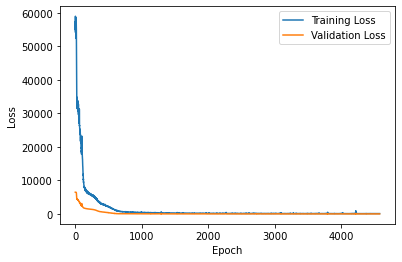

In [51]:
hidden_size = 6
num_layers = 10
lr = 0.00056
model = FeedforwardNN(input_size, output_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 10000
losses, val_losses, early_stop = train_feed(model, 
                                            train_loader, 
                                            val_loader, 
                                            optimizer, 
                                            criterion, 
                                            num_epochs, 
                                            print_every=100, 
                                            save_models=False, 
                                            patience=1000)
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

Epoch [100/10000], Train Loss: 4747.9576, Validation Loss: 1258.1383
Epoch [200/10000], Train Loss: 3653.8172, Validation Loss: 1156.6899
Epoch [300/10000], Train Loss: 3512.8168, Validation Loss: 1130.1262
Epoch [400/10000], Train Loss: 3312.9915, Validation Loss: 1126.0669
Epoch [500/10000], Train Loss: 3307.2129, Validation Loss: 1125.2266
Epoch [600/10000], Train Loss: 2909.9117, Validation Loss: 1119.8710
Epoch [700/10000], Train Loss: 3009.4613, Validation Loss: 1116.9323
Epoch [800/10000], Train Loss: 3193.5545, Validation Loss: 1114.6240
Epoch [900/10000], Train Loss: 3132.3660, Validation Loss: 1114.3009
Epoch [1000/10000], Train Loss: 3122.9868, Validation Loss: 1112.6549
Epoch [1100/10000], Train Loss: 2972.7957, Validation Loss: 1112.6022
Epoch [1200/10000], Train Loss: 3172.3488, Validation Loss: 1112.3407
Epoch [1300/10000], Train Loss: 3362.8524, Validation Loss: 1112.0867
Epoch [1400/10000], Train Loss: 2960.3994, Validation Loss: 1112.1718
Epoch [1500/10000], Train Los

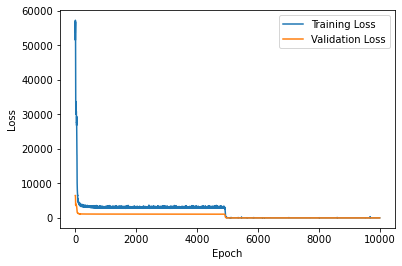

In [53]:
hidden_size = 20
num_layers = 4
lr = 0.016297186309040205
model2 = FeedforwardNN(input_size, output_size, hidden_size, num_layers)
optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 10000
losses, val_losses, early_stop = train_feed(model2, 
                                            train_loader, 
                                            val_loader, 
                                            optimizer, 
                                            criterion, 
                                            num_epochs, 
                                            print_every=100, 
                                            save_models=False, 
                                            patience=1000)
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [54]:
test_loss_model_1 = cal_loss(model,test_loader,criterion)
test_loss_model_2 = cal_loss(model2,test_loader,criterion)
print(f'Test loss for model 1: {test_loss_model_1}')
print(f'Test loss for model 2: {test_loss_model_2}')

Test loss for model 1: 12.496554374694824
Test loss for model 2: 1.1841840744018555


In [60]:
class Visualization:
    def __init__(self, data):
        # convert invariants to tensor
        invariants = torch.tensor(data['invriants'], dtype=torch.float32)
        invariants.requires_grad = True
        self.invariants = invariants
        self.bases = data['bases']
        self.base1_list = [b.base1 for b in self.bases]
        self.base2_list = [b.base2 for b in self.bases]
        self.base3_list = [b.base3 for b in self.bases]
        self.base4_list = [b.base4 for b in self.bases]
        self.base5_list = [b.base5 for b in self.bases]
        self.base1_list = torch.stack(self.base1_list)
        self.base2_list = torch.stack(self.base2_list)
        self.base3_list = torch.stack(self.base3_list)
        self.base4_list = torch.stack(self.base4_list)
        self.base5_list = torch.stack(self.base5_list)
        # target_stress = torch.tensor(data['target_stress'], dtype=torch.float32)
        # target_stress.requires_grad = True
        target_stress = torch.stack(data['target_stress'])
        self.target_stress = target_stress
        self.plot_configs = [
            {'xrange': (0, 170)  , 'eps_idx': 0, 'subplot_idx': 1, 'xy_idx':11},
            {'xrange': (171, 255), 'eps_idx': 1, 'subplot_idx': 2, 'xy_idx':22},
            {'xrange': (256, 425), 'eps_idx': 2, 'subplot_idx': 3, 'xy_idx':33},
            {'xrange': (426, 595), 'eps_idx': 3, 'subplot_idx': 4, 'xy_idx':12},
            {'xrange': (596, 748), 'eps_idx': 4, 'subplot_idx': 5, 'xy_idx':13},
            {'xrange': (749, 918), 'eps_idx': 5, 'subplot_idx': 6, 'xy_idx':23},
        ]
        self.fontsize = 14
    def forward(self,model):
        psi = model(self.invariants)
        dPsidX = torch.autograd.grad(psi, self.invariants, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        sigma = cauchy_stress_vectorized(self.invariants,dPsidX,self.base1_list,self.base2_list,self.base3_list,self.base4_list,self.base5_list)
        return sigma
    def get_sigma_lin(self,model):
        sigma = self.forward(model).detach().numpy()
        sigma_labeled = self.target_stress.detach().numpy()
        sigma_pred_lin = np.zeros((sigma.shape[0],6))
        sigma_labeled_lin = np.zeros((sigma.shape[0],6))
        for i in range(sigma.shape[0]):
            sigma_pred_lin[i,:] = [sigma[i,0,0],sigma[i,1,1],sigma[i,2,2],sigma[i,0,1],sigma[i,0,2],sigma[i,1,2]]
            sigma_labeled_lin[i,:] = [sigma_labeled[i,0,0],sigma_labeled[i,1,1],sigma_labeled[i,2,2],sigma_labeled[i,0,1],sigma_labeled[i,0,2],sigma_labeled[i,1,2]]
        return sigma_pred_lin,sigma_labeled_lin
    def get_psi(self,model):
        model.eval()
        with torch.no_grad():
            psi = model(self.invariants)
        return psi.detach().numpy()
    def plot_stresses(self,model,epsMatrix = eps_nominal):
        sig_list_pred, stressList_exp = self.get_sigma_lin(model)
        # Configuration settings
        plt.figure(figsize=(10, 15))  # Adjust figure size as needed

        for config in self.plot_configs:
            start, end = config['xrange']
            eps_idx = config['eps_idx']
            subplot_idx = config['subplot_idx']

            xrange = range(start, end)
            eps = epsMatrix[xrange, eps_idx]
            sig = sig_list_pred[xrange, eps_idx]
            sig_exp = stressList_exp[xrange, eps_idx]

            plt.subplot(3, 2, subplot_idx)
            plt.plot(eps, sig, label='Predicted')
            plt.plot(eps, sig_exp, '.', label='Experimental')
            plt.xlabel(f'$\epsilon_{{{config["xy_idx"]}}}$', fontsize=self.fontsize)
            plt.ylabel(f'$\sigma_{{{config["xy_idx"]}}}$', fontsize=self.fontsize)
            plt.legend()

        plt.tight_layout()
    def plot_psi(self,model,epsMatrix = eps_nominal):
        psi = self.get_psi(model)
        plt.figure(figsize=(10, 15))
        for config in self.plot_configs:
            start, end = config['xrange']
            eps_idx = config['eps_idx']
            subplot_idx = config['subplot_idx']

            xrange = range(start, end)
            eps = epsMatrix[xrange, eps_idx]

            plt.subplot(3, 2, subplot_idx)
            plt.plot(eps, psi[xrange])
            plt.xlabel(f'$\epsilon_{{{config["xy_idx"]}}}$', fontsize=self.fontsize)
            plt.ylabel(f'$\Psi$', fontsize=self.fontsize)
        plt.tight_layout()
        
visualizer = Visualization(data_dict)


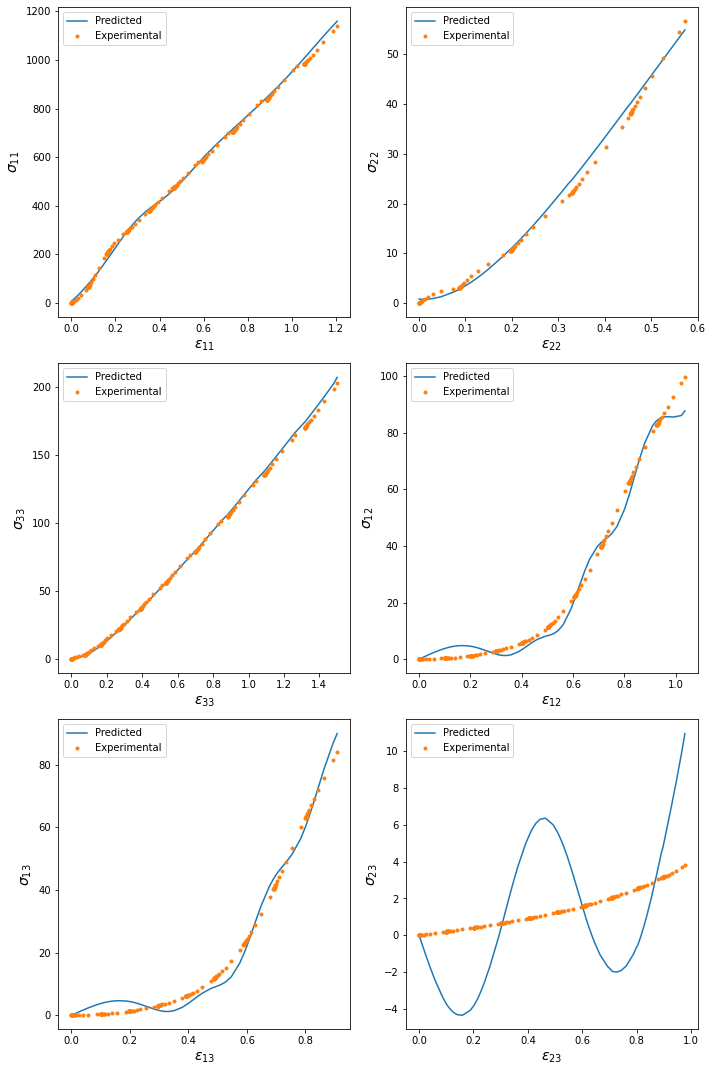

In [56]:
visualizer.plot_stresses(model)

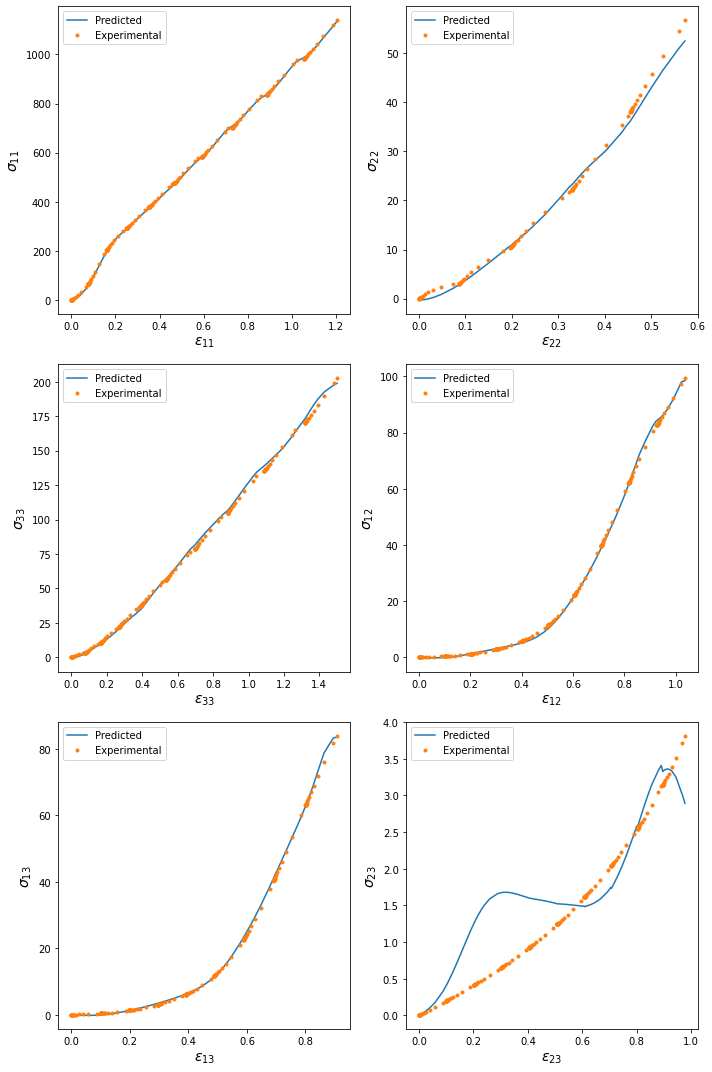

In [57]:
visualizer.plot_stresses(model2)

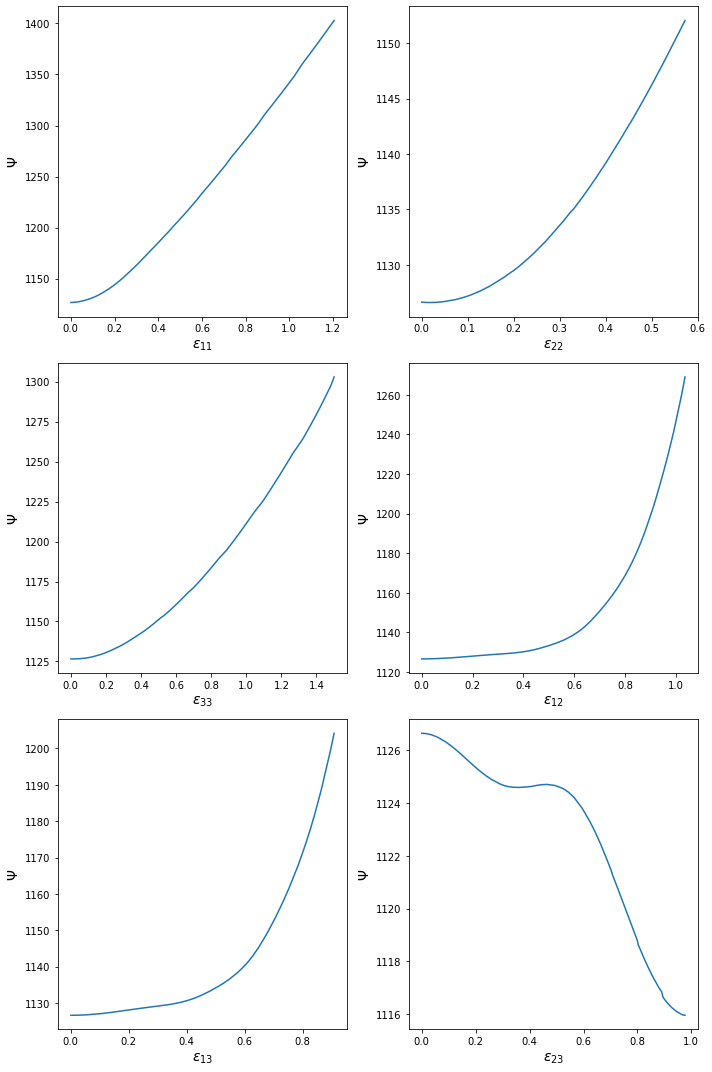

In [61]:
visualizer.plot_psi(model)

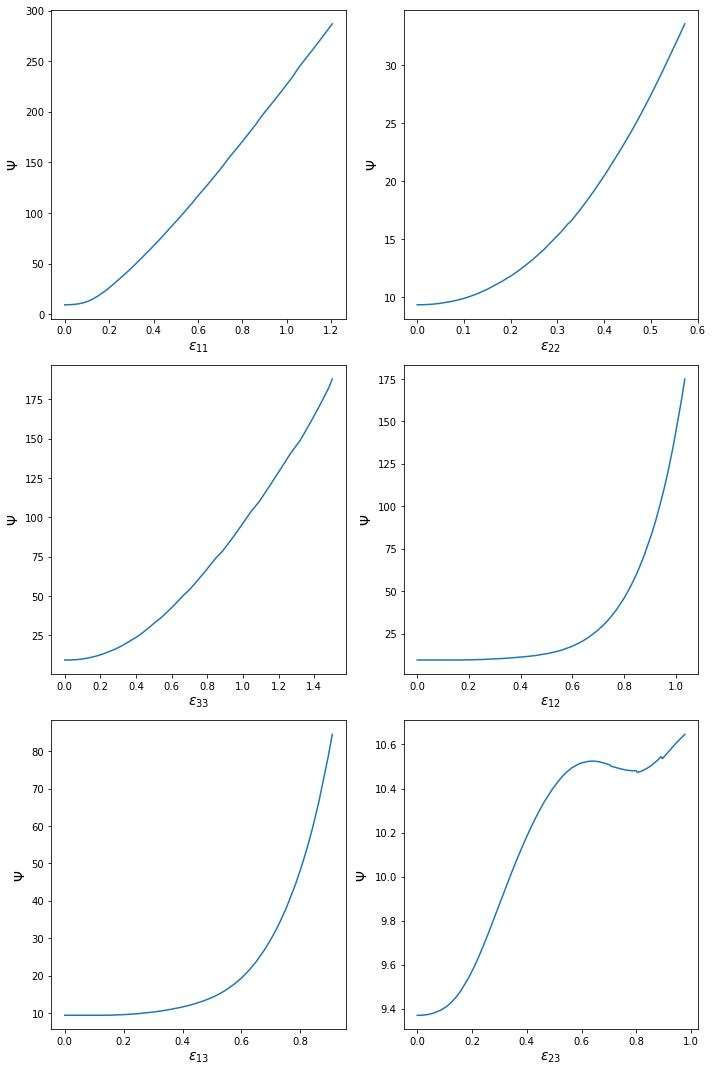

In [62]:
visualizer.plot_psi(model2)